In [218]:
import requests
import pandas as pd
from bs4 import BeautifulSoup
from datetime import date

url = 'https://www.cnnbrasil.com.br/eleicoes/quem-sao-os-candidatos-a-vereador-em-florianopolis/'

response = requests.get(url)

soup = BeautifulSoup(response.content, 'html.parser')

html_list = soup.find_all('li', class_="candidate")


# Initialize lists to store the parsed data
links = []
candidates = []
numbers = []
parties = []

# Loop through the list of HTML items and parse with BeautifulSoup
for html_item in html_list:
    soup_ = html_item
    # Extract the link
    link = soup_.find('a')['href']
    
    # Extract the candidate name
    candidate = soup_.find('a').get_text()
    
    # Extract the party using regex (match content in parentheses)
    party = soup_.find(text=re.compile(r'\((.*?)\)')).strip('()')
    
    # Extract the number (float) using regex (match number before '–')
    number = float(re.search(r'– (\d+)', soup_.get_text()).group(1))
    
    # Append the parsed data to the respective lists
    links.append(link)
    candidates.append(candidate)
    numbers.append(number)
    parties.append(party)

# Create a DataFrame from the extracted lists
df = pd.DataFrame({
    'links': links,
    'Candidato': candidates,
    'Número': numbers,
    'Partido': parties
})

def extract_party(value):
    # Check if the value contains parentheses
    if '(' in value and ')' in value:
        try:
            # Extract the party name inside the parentheses
            return value.split('–')[0].split('(')[1].split(')')[0]
        except IndexError:
            return None  # Return None for values that don't follow the expected structure
    else:
        return None  # Return None for values that don't have parentheses

# Apply the function to the 'Partido' column and rewrite it
df['Partido'] = df['Partido'].apply(extract_party)

df

C:\Users\caoco\AppData\Local\Temp\ipykernel_22452\2457118642.py:31: DeprecationWarning: The 'text' argument to find()-type methods is deprecated. Use 'string' instead.
  party = soup_.find(text=re.compile(r'\((.*?)\)')).strip('()')


,links,Candidato,Número,Partido
0,https://www.cnnbrasil.com.br/eleicoes/2024/can...,A Alex Professor de Direita,22000.0,PL
1,https://www.cnnbrasil.com.br/eleicoes/2024/can...,Adelio Jose da Costa,70777.0,AVANTE
2,https://www.cnnbrasil.com.br/eleicoes/2024/can...,Adi Mensageiro Sertanejo,20456.0,PODE
3,https://www.cnnbrasil.com.br/eleicoes/2024/can...,Adriana Fernandes,22422.0,PL
4,https://www.cnnbrasil.com.br/eleicoes/2024/can...,Adrianinho,10111.0,REPUBLICANOS
...,...,...,...,...
303,https://www.cnnbrasil.com.br/eleicoes/2024/can...,Walter Nogueira,44007.0,UNIÃO
304,https://www.cnnbrasil.com.br/eleicoes/2024/can...,Wilson Lapa,45300.0,PSDB
305,https://www.cnnbrasil.com.br/eleicoes/2024/can...,Zé Beto,20123.0,PODE
306,https://www.cnnbrasil.com.br/eleicoes/2024/can...,Zete,12555.0,PDT


In [314]:
import requests
import pandas as pd
from bs4 import BeautifulSoup
from datetime import date
import re

# Initialize an empty DataFrame to store all candidates' data
all_data = pd.DataFrame()

# Function to calculate the candidate's age
def calculate_age(born):
    today = date.today()
    return today.year - born.year - ((today.month, today.day) < (born.month, born.day))

# Function to handle HTTP requests
def fetch_url(link):
    try:
        response = requests.get(link)
        response.raise_for_status()
        return response.content
    except requests.exceptions.RequestException as e:
        print(f"Error fetching link {link}: {e}")
        return None

# Function to parse and safely extract text from a BeautifulSoup tag
def safe_extract_text(tag, default=None):
    return tag.get_text(strip=True) if tag else default

# Function to parse candidate general info
def parse_candidate_info(soup):
    try:
        soup_general = soup.find('div', class_='election__card')

        # Extract candidate information
        candidate_info = {
            'Candidato': safe_extract_text(soup_general.find('span', class_='election__x-ray-candidate__name')),
            'Número': safe_extract_text(soup_general.find('span', class_='election__x-ray-candidate__number')),
            'Partido': safe_extract_text(soup_general.find('span', class_='election__x-ray-candidate__party')),
            'Gênero': safe_extract_text(soup_general.find('p', string='Gênero').find_next('p', class_='x-ray__text')),
            'Naturalidade': safe_extract_text(soup_general.find('p', string='Naturalidade').find_next('p', class_='x-ray__text')),
            'Cor': safe_extract_text(soup_general.find('p', string='Cor/raça').find_next('p', class_='x-ray__text--ethnicity')),
            'Estado civil': safe_extract_text(soup_general.find('p', string='Estado civil').find_next('p', class_='x-ray__text')),
            'Grau de instrução': safe_extract_text(soup_general.find('p', string='Grau de instrução').find_next('p', class_='x-ray__text')),
            'Data de nascimento': safe_extract_text(soup_general.find('p', string='Data de nascimento').find_next('p', class_='x-ray__text')),
            'Coalisão': safe_extract_text(soup_general.find('p', string='Coligação').find_next('p', class_='x-ray__text')),
            'Image URL': soup_general.find('img', class_='election__x-ray-candidate__img')['src'] if soup_general.find('img', class_='election__x-ray-candidate__img') else None
        }
        
        # Parse and calculate the candidate's age, if 'Data de nascimento' is available
        if candidate_info['Data de nascimento']:
            candidate_info['Data de nascimento'] = pd.to_datetime(candidate_info['Data de nascimento'], dayfirst=True, errors='coerce')
            candidate_info['Idade'] = calculate_age(candidate_info['Data de nascimento']) if pd.notnull(candidate_info['Data de nascimento']) else None

        return pd.DataFrame([candidate_info])
    
    except (IndexError, AttributeError) as e:
        print(f"Error parsing candidate info: {e}")
        return pd.DataFrame()
    # Function to convert Brazilian formatted numbers to Python float
def brazilian_str_to_float(value_str):
    if not value_str:  # Check for empty or None values
        return 0.0
    try:
        # Remove currency symbol and any non-numeric characters
        clean_str = re.sub(r'[^\d,]', '', value_str)  # Removes everything except digits and comma
        clean_str = clean_str.replace(',', '.')  # Replaces comma with dot for decimal conversion
        return float(clean_str)
    except ValueError:
        print(f"Error converting value: {value_str}")
        return 0.0
    
def parse_percentage(value_str):
    if not value_str:
        return 0.0
    try:
        clean_str = value_str.replace('%', '').replace(',', '.').strip()
        return float(clean_str)
    except ValueError:
        print(f"Error converting percentage: {value_str}")
        return 0.0


# Function to parse donations (updated with brazilian_str_to_float)
def parse_donations(soup):
    try:
        soup_receipts = soup.find_all('div', class_='election__card')[1]
        total_resources = brazilian_str_to_float(soup_receipts.find('p', class_='x-ray__currency').text)

        # Extract progress bars and values
        progress_titles = [t.text.strip() for t in soup_receipts.find_all('h3', class_='election__progress__title')]
        progress_values = [parse_percentage(v.text.strip()) for v in soup_receipts.find_all('span', class_='election__progress__percent')]

        donation_details = {'Total de recursos recebidos (R$)': total_resources}
        donation_details.update({title: value for title, value in zip(progress_titles, progress_values)})

        return pd.DataFrame([donation_details])

    except (IndexError, AttributeError, ValueError) as e:
        print(f"Error parsing donation details: {e}")
        return pd.DataFrame()

# Function to parse expenses (updated with brazilian_str_to_float)
def parse_expenses(soup):
    try:
        soup_despesas = soup.find_all('div', class_='election__card')[2]
        items = [h3.get_text(strip=True) for h3 in soup_despesas.find_all('h3', class_='x-ray__subtitle')]
        values = [brazilian_str_to_float(v.get_text(strip=True)) for v in soup_despesas.find_all('p', class_='x-ray__currency bg-grey')]

        despesas_data = {'Item': items, 'Value (R$)': values}
        return pd.DataFrame(despesas_data).set_index('Item').T.rename(columns={
            'Limite de gastos': 'Limite de gastos (R$)',
            'Total de despesas contratadas': 'Total de despesas contratadas (R$)',
            'Total de despesas pagas': 'Total de despesas pagas (R$)'
        }).reset_index(drop=True)

    except (IndexError, AttributeError, ValueError) as e:
        print(f"Error parsing expenses: {e}")
        return pd.DataFrame()

# Function to parse assets (updated with brazilian_str_to_float)
def parse_assets(soup):
    try:
        soup_bens = soup.find_all('div', class_='election__card')[3]
        asset_items = soup_bens.find_all('div', class_='election__x-ray-property__item bulleted')

        bens_data = {
            'Asset Type': [safe_extract_text(item.find('h4', class_='election__x-ray-property__h4')) for item in asset_items],
            'Description': [safe_extract_text(item.find('p', class_='election__x-ray-property__p')) for item in asset_items],
            'Value (R$)': [brazilian_str_to_float(item.find_all('h4', class_='election__x-ray-property__h4')[-1].get_text(strip=True)) for item in asset_items]
        }
        return pd.DataFrame(bens_data)

    except (IndexError, AttributeError, ValueError) as e:
        print(f"Error parsing assets: {e}")
        return pd.DataFrame()

# Apply the same logic to other places where you extract monetary values


# Function to parse previous elections
def parse_previous_elections(soup):
    try:
        # Encontrar o contêiner principal que envolve todas as eleições anteriores
        elections_container = soup.find('div', class_='election__x-ray-previous-elections')

        # Lista para armazenar os dados extraídos
        elections_data = []

        # Encontrar todos os inputs que representam cada eleição
        inputs = elections_container.find_all('input', class_='election__x-ray-previous-elections__radio')

        for input_tag in inputs:
            election = {}

            # Obter o ID do input para relacionar com o label
            input_id = input_tag.get('id')

            # Encontrar o label correspondente usando o atributo 'for'
            label = elections_container.find('label', attrs={'for': input_id})
            if label:
                # Extrair o ano da eleição
                year_span = label.find('span', class_='election__x-ray-previous-elections__title')
                election['Ano'] = year_span.text.strip() if year_span else None
            else:
                election['Ano'] = None

            # Encontrar o conteúdo associado à eleição
            content_div = input_tag.find_next_sibling('label').find_next_sibling('div', class_='election__x-ray-previous-elections__content')
            if content_div:
                # Extrair Cargo
                cargo_span = content_div.find('span', text=lambda x: x and 'Cargo:' in x)
                if not cargo_span:
                    # Alternativa: encontrar o span que contém 'Cargo:'
                    cargo_span = content_div.find('span', class_='election__x-ray-previous-elections__content-item')
                cargo_strong = content_div.find('strong', text='Cargo:')
                if cargo_strong and cargo_strong.next_sibling:
                    election['Cargo'] = cargo_strong.next_sibling.strip()
                else:
                    election['Cargo'] = None

                # Extrair Partido
                partido_strong = content_div.find('strong', text='Partido:')
                if partido_strong and partido_strong.next_sibling:
                    election['Partido'] = partido_strong.next_sibling.strip()
                else:
                    election['Partido'] = None

                # Extrair Situação
                situacao_strong = content_div.find('strong', text='Situação:')
                if situacao_strong and situacao_strong.next_sibling:
                    election['Situação'] = situacao_strong.next_sibling.strip()
                else:
                    election['Situação'] = None

                # Extrair Link
                link_tag = content_div.find('a', class_='election__x-ray-previous-elections__link')
                if link_tag and link_tag.get('href'):
                    election['Link'] = link_tag['href']
                else:
                    election['Link'] = None
            else:
                election['Cargo'] = None
                election['Partido'] = None
                election['Situação'] = None
                election['Link'] = None

            elections_data.append(election)

            # Criar o DataFrame a partir da lista de dicionários
            df_elections = pd.DataFrame(elections_data)

            # Exibir o DataFrame
        return df_elections

    except (IndexError, AttributeError) as e:
        print(f"Error parsing previous elections: {e}")
        return pd.DataFrame()

# Main loop
for row, link in enumerate(df['links']):
    print(f"Processing candidate {row+1}/{len(df['links'])}: {link}")
    
    # Fetch the page content
    content = fetch_url(link)
    if content is None:
        print('veio None aqui')
        continue
    
    # Parse the page
    soup = BeautifulSoup(content, 'html.parser')
    
    # Extract data from various sections
    df_candidate_info = parse_candidate_info(soup)
    #print('AAAAAAAAAAAAAAAAAAAAAAA')
    df_donations = parse_donations(soup)
    #print('EEEEEEEEEEEEEEEEEEEEEEE')

    df_expenses = parse_expenses(soup)
    #print('IIIIIIIIIIIIIIIIIIIIIII')

    df_assets = parse_assets(soup)
    #print('OOOOOOOOOOOOOOOOOOOOOOO')

    df_previous_elections = parse_previous_elections(soup)
    #print(df_previous_elections)
    #print('UUUUUUUUUUUUUUUUUUUUUUU')


    # Combine data into a single DataFrame for the candidate
    final_df = pd.concat([df_candidate_info, df_donations, df_expenses], axis=1)
    final_df['Total de Bens Declarados'] = df_assets['Value (R$)'].sum() if not df_assets.empty else 0
    final_df['Vezes em que concorreu'] = len(df_previous_elections)
    # Append the candidate's data to the main DataFrame
    all_data = pd.concat([all_data, final_df], ignore_index=True)
    #print(all_data)


# Output the final DataFrame
all_data

Processing candidate 1/308: https://www.cnnbrasil.com.br/eleicoes/2024/candidatos/sc/florianopolis/vereador/22000-a-alex-professor-de-direita
AAAAAAAAAAAAAAAAAAAAAAA
EEEEEEEEEEEEEEEEEEEEEEE
IIIIIIIIIIIIIIIIIIIIIII
OOOOOOOOOOOOOOOOOOOOOOO
    Ano              Cargo Partido  Situação  \
0  2022  Deputado Estadual      PL  Suplente   

                                                Link  
0  https://divulgacandcontas.tse.jus.br/divulga/#...  
UUUUUUUUUUUUUUUUUUUUUUU
                     Candidato Número Partido     Gênero        Naturalidade  \
0  A ALEX PROFESSOR DE DIREITA  22000      PL  Masculino  FLORIANÓPOLIS / SC   

      Cor Estado civil  Grau de instrução Data de nascimento Coalisão  ...  \
0  branca   Divorciado  Superior completo         1983-06-17       PL  ...   

  Recursos financeiros  Doação de pessoas físicas  Recursos estimáveis  \
0                100.0                        0.0                  0.0   

   Doação de partidos  Recursos próprios  Limite de gastos (R$) 

C:\Users\caoco\AppData\Local\Temp\ipykernel_22452\592847770.py:171: DeprecationWarning:

The 'text' argument to find()-type methods is deprecated. Use 'string' instead.

C:\Users\caoco\AppData\Local\Temp\ipykernel_22452\592847770.py:175: DeprecationWarning:

The 'text' argument to find()-type methods is deprecated. Use 'string' instead.

C:\Users\caoco\AppData\Local\Temp\ipykernel_22452\592847770.py:182: DeprecationWarning:

The 'text' argument to find()-type methods is deprecated. Use 'string' instead.

C:\Users\caoco\AppData\Local\Temp\ipykernel_22452\592847770.py:189: DeprecationWarning:

The 'text' argument to find()-type methods is deprecated. Use 'string' instead.



AAAAAAAAAAAAAAAAAAAAAAA
EEEEEEEEEEEEEEEEEEEEEEE
IIIIIIIIIIIIIIIIIIIIIII
OOOOOOOOOOOOOOOOOOOOOOO
Error parsing previous elections: 'NoneType' object has no attribute 'find_all'
Empty DataFrame
Columns: []
Index: []
UUUUUUUUUUUUUUUUUUUUUUU
                     Candidato Número Partido     Gênero        Naturalidade  \
0  A ALEX PROFESSOR DE DIREITA  22000      PL  Masculino  FLORIANÓPOLIS / SC   
1         ADELIO JOSE DA COSTA  70777  AVANTE  Masculino  FLORIANÓPOLIS / SC   

      Cor Estado civil      Grau de instrução Data de nascimento Coalisão  \
0  branca   Divorciado      Superior completo         1983-06-17       PL   
1  branca       Casado  Ensino Médio completo         1953-12-26   AVANTE   

   ... Recursos financeiros  Doação de pessoas físicas  Recursos estimáveis  \
0  ...                100.0                        0.0                  0.0   
1  ...                100.0                        0.0                  0.0   

   Doação de partidos  Recursos próprios  Limite de

C:\Users\caoco\AppData\Local\Temp\ipykernel_22452\592847770.py:171: DeprecationWarning:

The 'text' argument to find()-type methods is deprecated. Use 'string' instead.

C:\Users\caoco\AppData\Local\Temp\ipykernel_22452\592847770.py:175: DeprecationWarning:

The 'text' argument to find()-type methods is deprecated. Use 'string' instead.

C:\Users\caoco\AppData\Local\Temp\ipykernel_22452\592847770.py:182: DeprecationWarning:

The 'text' argument to find()-type methods is deprecated. Use 'string' instead.

C:\Users\caoco\AppData\Local\Temp\ipykernel_22452\592847770.py:189: DeprecationWarning:

The 'text' argument to find()-type methods is deprecated. Use 'string' instead.



AAAAAAAAAAAAAAAAAAAAAAA
EEEEEEEEEEEEEEEEEEEEEEE
IIIIIIIIIIIIIIIIIIIIIII
OOOOOOOOOOOOOOOOOOOOOOO
    Ano     Cargo Partido  Situação  \
0  2020  Vereador     DEM  Suplente   
1  2016  Vereador      SD  Suplente   

                                                Link  
0  https://divulgacandcontas.tse.jus.br/divulga/#...  
1  https://divulgacandcontas.tse.jus.br/divulga/#...  
UUUUUUUUUUUUUUUUUUUUUUU
                     Candidato Número       Partido     Gênero  \
0  A ALEX PROFESSOR DE DIREITA  22000            PL  Masculino   
1         ADELIO JOSE DA COSTA  70777        AVANTE  Masculino   
2     ADI MENSAGEIRO SERTANEJO  20456          PODE   Feminino   
3            ADRIANA FERNANDES  22422            PL   Feminino   
4                   ADRIANINHO  10111  REPUBLICANOS  Masculino   
5             ADRIANO DA PESCA  44244         UNIÃO   Feminino   

         Naturalidade     Cor Estado civil              Grau de instrução  \
0  FLORIANÓPOLIS / SC  branca   Divorciado              S

C:\Users\caoco\AppData\Local\Temp\ipykernel_22452\592847770.py:171: DeprecationWarning:

The 'text' argument to find()-type methods is deprecated. Use 'string' instead.

C:\Users\caoco\AppData\Local\Temp\ipykernel_22452\592847770.py:175: DeprecationWarning:

The 'text' argument to find()-type methods is deprecated. Use 'string' instead.

C:\Users\caoco\AppData\Local\Temp\ipykernel_22452\592847770.py:182: DeprecationWarning:

The 'text' argument to find()-type methods is deprecated. Use 'string' instead.

C:\Users\caoco\AppData\Local\Temp\ipykernel_22452\592847770.py:189: DeprecationWarning:

The 'text' argument to find()-type methods is deprecated. Use 'string' instead.



AAAAAAAAAAAAAAAAAAAAAAA
EEEEEEEEEEEEEEEEEEEEEEE
IIIIIIIIIIIIIIIIIIIIIII
OOOOOOOOOOOOOOOOOOOOOOO
    Ano              Cargo Partido       Situação  \
0  2022            Senador    PSOL     Não eleito   
1  2020           Vereador    PSOL  Eleito por QP   
2  2018   Deputado Federal    PSOL     Não eleito   
3  2016           Vereador    PSOL  Eleito por QP   
4  2014         Governador    PSOL     Não eleito   
5  2012           Vereador    PSOL  Eleito por QP   
6  2008           Prefeito    PSOL     Não eleito   
7  2006  Deputado Estadual    PSOL    Concorrendo   
8  2004           Prefeito      PT     Não eleito   

                                                Link  
0  https://divulgacandcontas.tse.jus.br/divulga/#...  
1  https://divulgacandcontas.tse.jus.br/divulga/#...  
2  https://divulgacandcontas.tse.jus.br/divulga/#...  
3  https://divulgacandcontas.tse.jus.br/divulga/#...  
4  https://divulgacandcontas.tse.jus.br/divulga/#...  
5  https://divulgacandcontas.tse.jus.br/div

C:\Users\caoco\AppData\Local\Temp\ipykernel_22452\592847770.py:171: DeprecationWarning:

The 'text' argument to find()-type methods is deprecated. Use 'string' instead.

C:\Users\caoco\AppData\Local\Temp\ipykernel_22452\592847770.py:175: DeprecationWarning:

The 'text' argument to find()-type methods is deprecated. Use 'string' instead.

C:\Users\caoco\AppData\Local\Temp\ipykernel_22452\592847770.py:182: DeprecationWarning:

The 'text' argument to find()-type methods is deprecated. Use 'string' instead.

C:\Users\caoco\AppData\Local\Temp\ipykernel_22452\592847770.py:189: DeprecationWarning:

The 'text' argument to find()-type methods is deprecated. Use 'string' instead.



AAAAAAAAAAAAAAAAAAAAAAA
EEEEEEEEEEEEEEEEEEEEEEE
IIIIIIIIIIIIIIIIIIIIIII
OOOOOOOOOOOOOOOOOOOOOOO
Error parsing previous elections: 'NoneType' object has no attribute 'find_all'
Empty DataFrame
Columns: []
Index: []
UUUUUUUUUUUUUUUUUUUUUUU
                     Candidato Número       Partido     Gênero  \
0  A ALEX PROFESSOR DE DIREITA  22000            PL  Masculino   
1         ADELIO JOSE DA COSTA  70777        AVANTE  Masculino   
2     ADI MENSAGEIRO SERTANEJO  20456          PODE   Feminino   
3            ADRIANA FERNANDES  22422            PL   Feminino   
4                   ADRIANINHO  10111  REPUBLICANOS  Masculino   
5             ADRIANO DA PESCA  44244         UNIÃO   Feminino   
6               AFRÂNIO BOPPRÉ  50100          PSOL   Feminino   
7   ALÉSIO O BRUXO DAS PLANTAS  13111            PT  Masculino   

         Naturalidade     Cor Estado civil              Grau de instrução  \
0  FLORIANÓPOLIS / SC  branca   Divorciado              Superior completo   
1  FLORIANÓPO

AAAAAAAAAAAAAAAAAAAAAAA
EEEEEEEEEEEEEEEEEEEEEEE
IIIIIIIIIIIIIIIIIIIIIII
OOOOOOOOOOOOOOOOOOOOOOO
    Ano     Cargo Partido  Situação  \
0  2016  Vereador      PR  Suplente   

                                                Link  
0  https://divulgacandcontas.tse.jus.br/divulga/#...  
UUUUUUUUUUUUUUUUUUUUUUU
                     Candidato Número       Partido     Gênero  \
0  A ALEX PROFESSOR DE DIREITA  22000            PL  Masculino   
1         ADELIO JOSE DA COSTA  70777        AVANTE  Masculino   
2     ADI MENSAGEIRO SERTANEJO  20456          PODE   Feminino   
3            ADRIANA FERNANDES  22422            PL   Feminino   
4                   ADRIANINHO  10111  REPUBLICANOS  Masculino   
5             ADRIANO DA PESCA  44244         UNIÃO   Feminino   
6               AFRÂNIO BOPPRÉ  50100          PSOL   Feminino   
7   ALÉSIO O BRUXO DAS PLANTAS  13111            PT  Masculino   
8              ALESSANDRA LIMA  55620           PSD   Feminino   
9                 ALEX SANTANA 

C:\Users\caoco\AppData\Local\Temp\ipykernel_22452\592847770.py:171: DeprecationWarning:

The 'text' argument to find()-type methods is deprecated. Use 'string' instead.

C:\Users\caoco\AppData\Local\Temp\ipykernel_22452\592847770.py:175: DeprecationWarning:

The 'text' argument to find()-type methods is deprecated. Use 'string' instead.

C:\Users\caoco\AppData\Local\Temp\ipykernel_22452\592847770.py:182: DeprecationWarning:

The 'text' argument to find()-type methods is deprecated. Use 'string' instead.

C:\Users\caoco\AppData\Local\Temp\ipykernel_22452\592847770.py:189: DeprecationWarning:

The 'text' argument to find()-type methods is deprecated. Use 'string' instead.



AAAAAAAAAAAAAAAAAAAAAAA
EEEEEEEEEEEEEEEEEEEEEEE
IIIIIIIIIIIIIIIIIIIIIII
OOOOOOOOOOOOOOOOOOOOOOO
Error parsing previous elections: 'NoneType' object has no attribute 'find_all'
Empty DataFrame
Columns: []
Index: []
UUUUUUUUUUUUUUUUUUUUUUU
                      Candidato Número       Partido     Gênero  \
0   A ALEX PROFESSOR DE DIREITA  22000            PL  Masculino   
1          ADELIO JOSE DA COSTA  70777        AVANTE  Masculino   
2      ADI MENSAGEIRO SERTANEJO  20456          PODE   Feminino   
3             ADRIANA FERNANDES  22422            PL   Feminino   
4                    ADRIANINHO  10111  REPUBLICANOS  Masculino   
5              ADRIANO DA PESCA  44244         UNIÃO   Feminino   
6                AFRÂNIO BOPPRÉ  50100          PSOL   Feminino   
7    ALÉSIO O BRUXO DAS PLANTAS  13111            PT  Masculino   
8               ALESSANDRA LIMA  55620           PSD   Feminino   
9                  ALEX SANTANA  45888          PSDB  Masculino   
10   ALEXANDRE FAUSTINO G

C:\Users\caoco\AppData\Local\Temp\ipykernel_22452\592847770.py:171: DeprecationWarning:

The 'text' argument to find()-type methods is deprecated. Use 'string' instead.

C:\Users\caoco\AppData\Local\Temp\ipykernel_22452\592847770.py:175: DeprecationWarning:

The 'text' argument to find()-type methods is deprecated. Use 'string' instead.

C:\Users\caoco\AppData\Local\Temp\ipykernel_22452\592847770.py:182: DeprecationWarning:

The 'text' argument to find()-type methods is deprecated. Use 'string' instead.

C:\Users\caoco\AppData\Local\Temp\ipykernel_22452\592847770.py:189: DeprecationWarning:

The 'text' argument to find()-type methods is deprecated. Use 'string' instead.



AAAAAAAAAAAAAAAAAAAAAAA
EEEEEEEEEEEEEEEEEEEEEEE
IIIIIIIIIIIIIIIIIIIIIII
OOOOOOOOOOOOOOOOOOOOOOO
Error parsing previous elections: 'NoneType' object has no attribute 'find_all'
Empty DataFrame
Columns: []
Index: []
UUUUUUUUUUUUUUUUUUUUUUU
                      Candidato Número       Partido     Gênero  \
0   A ALEX PROFESSOR DE DIREITA  22000            PL  Masculino   
1          ADELIO JOSE DA COSTA  70777        AVANTE  Masculino   
2      ADI MENSAGEIRO SERTANEJO  20456          PODE   Feminino   
3             ADRIANA FERNANDES  22422            PL   Feminino   
4                    ADRIANINHO  10111  REPUBLICANOS  Masculino   
5              ADRIANO DA PESCA  44244         UNIÃO   Feminino   
6                AFRÂNIO BOPPRÉ  50100          PSOL   Feminino   
7    ALÉSIO O BRUXO DAS PLANTAS  13111            PT  Masculino   
8               ALESSANDRA LIMA  55620           PSD   Feminino   
9                  ALEX SANTANA  45888          PSDB  Masculino   
10   ALEXANDRE FAUSTINO G

AAAAAAAAAAAAAAAAAAAAAAA
EEEEEEEEEEEEEEEEEEEEEEE
IIIIIIIIIIIIIIIIIIIIIII
OOOOOOOOOOOOOOOOOOOOOOO
Error parsing previous elections: 'NoneType' object has no attribute 'find_all'
Empty DataFrame
Columns: []
Index: []
UUUUUUUUUUUUUUUUUUUUUUU
                        Candidato Número       Partido     Gênero  \
0     A ALEX PROFESSOR DE DIREITA  22000            PL  Masculino   
1            ADELIO JOSE DA COSTA  70777        AVANTE  Masculino   
2        ADI MENSAGEIRO SERTANEJO  20456          PODE   Feminino   
3               ADRIANA FERNANDES  22422            PL   Feminino   
4                      ADRIANINHO  10111  REPUBLICANOS  Masculino   
5                ADRIANO DA PESCA  44244         UNIÃO   Feminino   
6                  AFRÂNIO BOPPRÉ  50100          PSOL   Feminino   
7      ALÉSIO O BRUXO DAS PLANTAS  13111            PT  Masculino   
8                 ALESSANDRA LIMA  55620           PSD   Feminino   
9                    ALEX SANTANA  45888          PSDB  Masculino   
10 

AAAAAAAAAAAAAAAAAAAAAAA
EEEEEEEEEEEEEEEEEEEEEEE
IIIIIIIIIIIIIIIIIIIIIII
OOOOOOOOOOOOOOOOOOOOOOO
Error parsing previous elections: 'NoneType' object has no attribute 'find_all'
Empty DataFrame
Columns: []
Index: []
UUUUUUUUUUUUUUUUUUUUUUU
                        Candidato Número       Partido     Gênero  \
0     A ALEX PROFESSOR DE DIREITA  22000            PL  Masculino   
1            ADELIO JOSE DA COSTA  70777        AVANTE  Masculino   
2        ADI MENSAGEIRO SERTANEJO  20456          PODE   Feminino   
3               ADRIANA FERNANDES  22422            PL   Feminino   
4                      ADRIANINHO  10111  REPUBLICANOS  Masculino   
5                ADRIANO DA PESCA  44244         UNIÃO   Feminino   
6                  AFRÂNIO BOPPRÉ  50100          PSOL   Feminino   
7      ALÉSIO O BRUXO DAS PLANTAS  13111            PT  Masculino   
8                 ALESSANDRA LIMA  55620           PSD   Feminino   
9                    ALEX SANTANA  45888          PSDB  Masculino   
10 

AAAAAAAAAAAAAAAAAAAAAAA
Error parsing donation details: 'NoneType' object has no attribute 'text'
EEEEEEEEEEEEEEEEEEEEEEE
IIIIIIIIIIIIIIIIIIIIIII
OOOOOOOOOOOOOOOOOOOOOOO
    Ano             Cargo   Partido    Situação  \
0  2020          Vereador       PSC    Suplente   
1  2018  Deputado Federal       MDB  Não eleito   
2  2016          Vereador  PATRIOTA  Não eleito   
3  2014  Deputado Federal      PMDB    Suplente   
4  2012          Vereador      PMDB    Suplente   
5  2008          Vereador      PMDB    Suplente   
6  2004          Vereador      PMDB    Suplente   

                                                Link  
0  https://divulgacandcontas.tse.jus.br/divulga/#...  
1  https://divulgacandcontas.tse.jus.br/divulga/#...  
2  https://divulgacandcontas.tse.jus.br/divulga/#...  
3  https://divulgacandcontas.tse.jus.br/divulga/#...  
4  https://divulgacandcontas.tse.jus.br/divulga/#...  
5  https://divulgacandcontas.tse.jus.br/divulga/#...  
6  https://divulgacandcontas.tse.jus

C:\Users\caoco\AppData\Local\Temp\ipykernel_22452\592847770.py:171: DeprecationWarning:

The 'text' argument to find()-type methods is deprecated. Use 'string' instead.

C:\Users\caoco\AppData\Local\Temp\ipykernel_22452\592847770.py:175: DeprecationWarning:

The 'text' argument to find()-type methods is deprecated. Use 'string' instead.

C:\Users\caoco\AppData\Local\Temp\ipykernel_22452\592847770.py:182: DeprecationWarning:

The 'text' argument to find()-type methods is deprecated. Use 'string' instead.

C:\Users\caoco\AppData\Local\Temp\ipykernel_22452\592847770.py:189: DeprecationWarning:

The 'text' argument to find()-type methods is deprecated. Use 'string' instead.



AAAAAAAAAAAAAAAAAAAAAAA
EEEEEEEEEEEEEEEEEEEEEEE
IIIIIIIIIIIIIIIIIIIIIII
OOOOOOOOOOOOOOOOOOOOOOO
Error parsing previous elections: 'NoneType' object has no attribute 'find_all'
Empty DataFrame
Columns: []
Index: []
UUUUUUUUUUUUUUUUUUUUUUU
                        Candidato Número       Partido     Gênero  \
0     A ALEX PROFESSOR DE DIREITA  22000            PL  Masculino   
1            ADELIO JOSE DA COSTA  70777        AVANTE  Masculino   
2        ADI MENSAGEIRO SERTANEJO  20456          PODE   Feminino   
3               ADRIANA FERNANDES  22422            PL   Feminino   
4                      ADRIANINHO  10111  REPUBLICANOS  Masculino   
5                ADRIANO DA PESCA  44244         UNIÃO   Feminino   
6                  AFRÂNIO BOPPRÉ  50100          PSOL   Feminino   
7      ALÉSIO O BRUXO DAS PLANTAS  13111            PT  Masculino   
8                 ALESSANDRA LIMA  55620           PSD   Feminino   
9                    ALEX SANTANA  45888          PSDB  Masculino   
10 

AAAAAAAAAAAAAAAAAAAAAAA
EEEEEEEEEEEEEEEEEEEEEEE
IIIIIIIIIIIIIIIIIIIIIII
OOOOOOOOOOOOOOOOOOOOOOO
    Ano             Cargo   Partido    Situação  \
0  2018  Deputado Federal       PTC  Não eleito   
1  2016          Vereador  PATRIOTA  Não eleito   
2  2012          Vereador       PDT    Suplente   

                                                Link  
0  https://divulgacandcontas.tse.jus.br/divulga/#...  
1  https://divulgacandcontas.tse.jus.br/divulga/#...  
2  https://divulgacandcontas.tse.jus.br/divulga/#...  
UUUUUUUUUUUUUUUUUUUUUUU
                        Candidato Número       Partido     Gênero  \
0     A ALEX PROFESSOR DE DIREITA  22000            PL  Masculino   
1            ADELIO JOSE DA COSTA  70777        AVANTE  Masculino   
2        ADI MENSAGEIRO SERTANEJO  20456          PODE   Feminino   
3               ADRIANA FERNANDES  22422            PL   Feminino   
4                      ADRIANINHO  10111  REPUBLICANOS  Masculino   
5                ADRIANO DA PESCA  44244 

C:\Users\caoco\AppData\Local\Temp\ipykernel_22452\592847770.py:171: DeprecationWarning:

The 'text' argument to find()-type methods is deprecated. Use 'string' instead.

C:\Users\caoco\AppData\Local\Temp\ipykernel_22452\592847770.py:175: DeprecationWarning:

The 'text' argument to find()-type methods is deprecated. Use 'string' instead.

C:\Users\caoco\AppData\Local\Temp\ipykernel_22452\592847770.py:182: DeprecationWarning:

The 'text' argument to find()-type methods is deprecated. Use 'string' instead.

C:\Users\caoco\AppData\Local\Temp\ipykernel_22452\592847770.py:189: DeprecationWarning:

The 'text' argument to find()-type methods is deprecated. Use 'string' instead.



AAAAAAAAAAAAAAAAAAAAAAA
EEEEEEEEEEEEEEEEEEEEEEE
IIIIIIIIIIIIIIIIIIIIIII
OOOOOOOOOOOOOOOOOOOOOOO
Error parsing previous elections: 'NoneType' object has no attribute 'find_all'
Empty DataFrame
Columns: []
Index: []
UUUUUUUUUUUUUUUUUUUUUUU
                        Candidato Número       Partido     Gênero  \
0     A ALEX PROFESSOR DE DIREITA  22000            PL  Masculino   
1            ADELIO JOSE DA COSTA  70777        AVANTE  Masculino   
2        ADI MENSAGEIRO SERTANEJO  20456          PODE   Feminino   
3               ADRIANA FERNANDES  22422            PL   Feminino   
4                      ADRIANINHO  10111  REPUBLICANOS  Masculino   
5                ADRIANO DA PESCA  44244         UNIÃO   Feminino   
6                  AFRÂNIO BOPPRÉ  50100          PSOL   Feminino   
7      ALÉSIO O BRUXO DAS PLANTAS  13111            PT  Masculino   
8                 ALESSANDRA LIMA  55620           PSD   Feminino   
9                    ALEX SANTANA  45888          PSDB  Masculino   
10 

AAAAAAAAAAAAAAAAAAAAAAA
Error parsing donation details: 'NoneType' object has no attribute 'text'
EEEEEEEEEEEEEEEEEEEEEEE
IIIIIIIIIIIIIIIIIIIIIII
OOOOOOOOOOOOOOOOOOOOOOO
    Ano              Cargo Partido    Situação  \
0  2018  Deputado Estadual    REDE  Não eleito   

                                                Link  
0  https://divulgacandcontas.tse.jus.br/divulga/#...  
UUUUUUUUUUUUUUUUUUUUUUU
                        Candidato Número       Partido     Gênero  \
0     A ALEX PROFESSOR DE DIREITA  22000            PL  Masculino   
1            ADELIO JOSE DA COSTA  70777        AVANTE  Masculino   
2        ADI MENSAGEIRO SERTANEJO  20456          PODE   Feminino   
3               ADRIANA FERNANDES  22422            PL   Feminino   
4                      ADRIANINHO  10111  REPUBLICANOS  Masculino   
5                ADRIANO DA PESCA  44244         UNIÃO   Feminino   
6                  AFRÂNIO BOPPRÉ  50100          PSOL   Feminino   
7      ALÉSIO O BRUXO DAS PLANTAS  13111   

C:\Users\caoco\AppData\Local\Temp\ipykernel_22452\592847770.py:171: DeprecationWarning:

The 'text' argument to find()-type methods is deprecated. Use 'string' instead.

C:\Users\caoco\AppData\Local\Temp\ipykernel_22452\592847770.py:175: DeprecationWarning:

The 'text' argument to find()-type methods is deprecated. Use 'string' instead.

C:\Users\caoco\AppData\Local\Temp\ipykernel_22452\592847770.py:182: DeprecationWarning:

The 'text' argument to find()-type methods is deprecated. Use 'string' instead.

C:\Users\caoco\AppData\Local\Temp\ipykernel_22452\592847770.py:189: DeprecationWarning:

The 'text' argument to find()-type methods is deprecated. Use 'string' instead.



AAAAAAAAAAAAAAAAAAAAAAA
EEEEEEEEEEEEEEEEEEEEEEE
IIIIIIIIIIIIIIIIIIIIIII
OOOOOOOOOOOOOOOOOOOOOOO
    Ano     Cargo Partido  Situação  \
0  2020  Vereador    PODE  Suplente   

                                                Link  
0  https://divulgacandcontas.tse.jus.br/divulga/#...  
UUUUUUUUUUUUUUUUUUUUUUU
                        Candidato Número       Partido     Gênero  \
0     A ALEX PROFESSOR DE DIREITA  22000            PL  Masculino   
1            ADELIO JOSE DA COSTA  70777        AVANTE  Masculino   
2        ADI MENSAGEIRO SERTANEJO  20456          PODE   Feminino   
3               ADRIANA FERNANDES  22422            PL   Feminino   
4                      ADRIANINHO  10111  REPUBLICANOS  Masculino   
5                ADRIANO DA PESCA  44244         UNIÃO   Feminino   
6                  AFRÂNIO BOPPRÉ  50100          PSOL   Feminino   
7      ALÉSIO O BRUXO DAS PLANTAS  13111            PT  Masculino   
8                 ALESSANDRA LIMA  55620           PSD   Feminino   
9

C:\Users\caoco\AppData\Local\Temp\ipykernel_22452\592847770.py:171: DeprecationWarning:

The 'text' argument to find()-type methods is deprecated. Use 'string' instead.

C:\Users\caoco\AppData\Local\Temp\ipykernel_22452\592847770.py:175: DeprecationWarning:

The 'text' argument to find()-type methods is deprecated. Use 'string' instead.

C:\Users\caoco\AppData\Local\Temp\ipykernel_22452\592847770.py:182: DeprecationWarning:

The 'text' argument to find()-type methods is deprecated. Use 'string' instead.

C:\Users\caoco\AppData\Local\Temp\ipykernel_22452\592847770.py:189: DeprecationWarning:

The 'text' argument to find()-type methods is deprecated. Use 'string' instead.



AAAAAAAAAAAAAAAAAAAAAAA
EEEEEEEEEEEEEEEEEEEEEEE
IIIIIIIIIIIIIIIIIIIIIII
OOOOOOOOOOOOOOOOOOOOOOO
Error parsing previous elections: 'NoneType' object has no attribute 'find_all'
Empty DataFrame
Columns: []
Index: []
UUUUUUUUUUUUUUUUUUUUUUU
                        Candidato Número       Partido     Gênero  \
0     A ALEX PROFESSOR DE DIREITA  22000            PL  Masculino   
1            ADELIO JOSE DA COSTA  70777        AVANTE  Masculino   
2        ADI MENSAGEIRO SERTANEJO  20456          PODE   Feminino   
3               ADRIANA FERNANDES  22422            PL   Feminino   
4                      ADRIANINHO  10111  REPUBLICANOS  Masculino   
5                ADRIANO DA PESCA  44244         UNIÃO   Feminino   
6                  AFRÂNIO BOPPRÉ  50100          PSOL   Feminino   
7      ALÉSIO O BRUXO DAS PLANTAS  13111            PT  Masculino   
8                 ALESSANDRA LIMA  55620           PSD   Feminino   
9                    ALEX SANTANA  45888          PSDB  Masculino   
10 

AAAAAAAAAAAAAAAAAAAAAAA
EEEEEEEEEEEEEEEEEEEEEEE
IIIIIIIIIIIIIIIIIIIIIII
OOOOOOOOOOOOOOOOOOOOOOO
Error parsing previous elections: 'NoneType' object has no attribute 'find_all'
Empty DataFrame
Columns: []
Index: []
UUUUUUUUUUUUUUUUUUUUUUU
                        Candidato Número       Partido     Gênero  \
0     A ALEX PROFESSOR DE DIREITA  22000            PL  Masculino   
1            ADELIO JOSE DA COSTA  70777        AVANTE  Masculino   
2        ADI MENSAGEIRO SERTANEJO  20456          PODE   Feminino   
3               ADRIANA FERNANDES  22422            PL   Feminino   
4                      ADRIANINHO  10111  REPUBLICANOS  Masculino   
5                ADRIANO DA PESCA  44244         UNIÃO   Feminino   
6                  AFRÂNIO BOPPRÉ  50100          PSOL   Feminino   
7      ALÉSIO O BRUXO DAS PLANTAS  13111            PT  Masculino   
8                 ALESSANDRA LIMA  55620           PSD   Feminino   
9                    ALEX SANTANA  45888          PSDB  Masculino   
10 

AAAAAAAAAAAAAAAAAAAAAAA
EEEEEEEEEEEEEEEEEEEEEEE
IIIIIIIIIIIIIIIIIIIIIII
OOOOOOOOOOOOOOOOOOOOOOO
    Ano              Cargo Partido  Situação  \
0  2022  Deputado Estadual   UNIÃO  Suplente   
1  2020           Vereador     DEM  Suplente   
2  2018  Deputado Estadual    PSDB  Suplente   
3  2016           Vereador     PRP  Suplente   

                                                Link  
0  https://divulgacandcontas.tse.jus.br/divulga/#...  
1  https://divulgacandcontas.tse.jus.br/divulga/#...  
2  https://divulgacandcontas.tse.jus.br/divulga/#...  
3  https://divulgacandcontas.tse.jus.br/divulga/#...  
UUUUUUUUUUUUUUUUUUUUUUU
                        Candidato Número       Partido     Gênero  \
0     A ALEX PROFESSOR DE DIREITA  22000            PL  Masculino   
1            ADELIO JOSE DA COSTA  70777        AVANTE  Masculino   
2        ADI MENSAGEIRO SERTANEJO  20456          PODE   Feminino   
3               ADRIANA FERNANDES  22422            PL   Feminino   
4                  

C:\Users\caoco\AppData\Local\Temp\ipykernel_22452\592847770.py:171: DeprecationWarning:

The 'text' argument to find()-type methods is deprecated. Use 'string' instead.

C:\Users\caoco\AppData\Local\Temp\ipykernel_22452\592847770.py:175: DeprecationWarning:

The 'text' argument to find()-type methods is deprecated. Use 'string' instead.

C:\Users\caoco\AppData\Local\Temp\ipykernel_22452\592847770.py:182: DeprecationWarning:

The 'text' argument to find()-type methods is deprecated. Use 'string' instead.

C:\Users\caoco\AppData\Local\Temp\ipykernel_22452\592847770.py:189: DeprecationWarning:

The 'text' argument to find()-type methods is deprecated. Use 'string' instead.



AAAAAAAAAAAAAAAAAAAAAAA
EEEEEEEEEEEEEEEEEEEEEEE
IIIIIIIIIIIIIIIIIIIIIII
OOOOOOOOOOOOOOOOOOOOOOO
Error parsing previous elections: 'NoneType' object has no attribute 'find_all'
Empty DataFrame
Columns: []
Index: []
UUUUUUUUUUUUUUUUUUUUUUU
                        Candidato Número       Partido     Gênero  \
0     A ALEX PROFESSOR DE DIREITA  22000            PL  Masculino   
1            ADELIO JOSE DA COSTA  70777        AVANTE  Masculino   
2        ADI MENSAGEIRO SERTANEJO  20456          PODE   Feminino   
3               ADRIANA FERNANDES  22422            PL   Feminino   
4                      ADRIANINHO  10111  REPUBLICANOS  Masculino   
5                ADRIANO DA PESCA  44244         UNIÃO   Feminino   
6                  AFRÂNIO BOPPRÉ  50100          PSOL   Feminino   
7      ALÉSIO O BRUXO DAS PLANTAS  13111            PT  Masculino   
8                 ALESSANDRA LIMA  55620           PSD   Feminino   
9                    ALEX SANTANA  45888          PSDB  Masculino   
10 

AAAAAAAAAAAAAAAAAAAAAAA
EEEEEEEEEEEEEEEEEEEEEEE
IIIIIIIIIIIIIIIIIIIIIII
OOOOOOOOOOOOOOOOOOOOOOO
    Ano     Cargo       Partido  Situação  \
0  2020  Vereador  REPUBLICANOS  Suplente   

                                                Link  
0  https://divulgacandcontas.tse.jus.br/divulga/#...  
UUUUUUUUUUUUUUUUUUUUUUU
                        Candidato Número       Partido     Gênero  \
0     A ALEX PROFESSOR DE DIREITA  22000            PL  Masculino   
1            ADELIO JOSE DA COSTA  70777        AVANTE  Masculino   
2        ADI MENSAGEIRO SERTANEJO  20456          PODE   Feminino   
3               ADRIANA FERNANDES  22422            PL   Feminino   
4                      ADRIANINHO  10111  REPUBLICANOS  Masculino   
5                ADRIANO DA PESCA  44244         UNIÃO   Feminino   
6                  AFRÂNIO BOPPRÉ  50100          PSOL   Feminino   
7      ALÉSIO O BRUXO DAS PLANTAS  13111            PT  Masculino   
8                 ALESSANDRA LIMA  55620           PSD   F

C:\Users\caoco\AppData\Local\Temp\ipykernel_22452\592847770.py:171: DeprecationWarning:

The 'text' argument to find()-type methods is deprecated. Use 'string' instead.

C:\Users\caoco\AppData\Local\Temp\ipykernel_22452\592847770.py:175: DeprecationWarning:

The 'text' argument to find()-type methods is deprecated. Use 'string' instead.

C:\Users\caoco\AppData\Local\Temp\ipykernel_22452\592847770.py:182: DeprecationWarning:

The 'text' argument to find()-type methods is deprecated. Use 'string' instead.

C:\Users\caoco\AppData\Local\Temp\ipykernel_22452\592847770.py:189: DeprecationWarning:

The 'text' argument to find()-type methods is deprecated. Use 'string' instead.



AAAAAAAAAAAAAAAAAAAAAAA
EEEEEEEEEEEEEEEEEEEEEEE
IIIIIIIIIIIIIIIIIIIIIII
OOOOOOOOOOOOOOOOOOOOOOO
Error parsing previous elections: 'NoneType' object has no attribute 'find_all'
Empty DataFrame
Columns: []
Index: []
UUUUUUUUUUUUUUUUUUUUUUU
                        Candidato Número       Partido     Gênero  \
0     A ALEX PROFESSOR DE DIREITA  22000            PL  Masculino   
1            ADELIO JOSE DA COSTA  70777        AVANTE  Masculino   
2        ADI MENSAGEIRO SERTANEJO  20456          PODE   Feminino   
3               ADRIANA FERNANDES  22422            PL   Feminino   
4                      ADRIANINHO  10111  REPUBLICANOS  Masculino   
5                ADRIANO DA PESCA  44244         UNIÃO   Feminino   
6                  AFRÂNIO BOPPRÉ  50100          PSOL   Feminino   
7      ALÉSIO O BRUXO DAS PLANTAS  13111            PT  Masculino   
8                 ALESSANDRA LIMA  55620           PSD   Feminino   
9                    ALEX SANTANA  45888          PSDB  Masculino   
10 

AAAAAAAAAAAAAAAAAAAAAAA
EEEEEEEEEEEEEEEEEEEEEEE
IIIIIIIIIIIIIIIIIIIIIII
OOOOOOOOOOOOOOOOOOOOOOO
    Ano     Cargo Partido       Situação  \
0  2020  Vereador     PSL  Eleito por QP   

                                                Link  
0  https://divulgacandcontas.tse.jus.br/divulga/#...  
UUUUUUUUUUUUUUUUUUUUUUU
                        Candidato Número       Partido     Gênero  \
0     A ALEX PROFESSOR DE DIREITA  22000            PL  Masculino   
1            ADELIO JOSE DA COSTA  70777        AVANTE  Masculino   
2        ADI MENSAGEIRO SERTANEJO  20456          PODE   Feminino   
3               ADRIANA FERNANDES  22422            PL   Feminino   
4                      ADRIANINHO  10111  REPUBLICANOS  Masculino   
5                ADRIANO DA PESCA  44244         UNIÃO   Feminino   
6                  AFRÂNIO BOPPRÉ  50100          PSOL   Feminino   
7      ALÉSIO O BRUXO DAS PLANTAS  13111            PT  Masculino   
8                 ALESSANDRA LIMA  55620           PSD   Fem

C:\Users\caoco\AppData\Local\Temp\ipykernel_22452\592847770.py:171: DeprecationWarning:

The 'text' argument to find()-type methods is deprecated. Use 'string' instead.

C:\Users\caoco\AppData\Local\Temp\ipykernel_22452\592847770.py:175: DeprecationWarning:

The 'text' argument to find()-type methods is deprecated. Use 'string' instead.

C:\Users\caoco\AppData\Local\Temp\ipykernel_22452\592847770.py:182: DeprecationWarning:

The 'text' argument to find()-type methods is deprecated. Use 'string' instead.

C:\Users\caoco\AppData\Local\Temp\ipykernel_22452\592847770.py:189: DeprecationWarning:

The 'text' argument to find()-type methods is deprecated. Use 'string' instead.



AAAAAAAAAAAAAAAAAAAAAAA
EEEEEEEEEEEEEEEEEEEEEEE
IIIIIIIIIIIIIIIIIIIIIII
OOOOOOOOOOOOOOOOOOOOOOO
Error parsing previous elections: 'NoneType' object has no attribute 'find_all'
Empty DataFrame
Columns: []
Index: []
UUUUUUUUUUUUUUUUUUUUUUU
                        Candidato Número       Partido     Gênero  \
0     A ALEX PROFESSOR DE DIREITA  22000            PL  Masculino   
1            ADELIO JOSE DA COSTA  70777        AVANTE  Masculino   
2        ADI MENSAGEIRO SERTANEJO  20456          PODE   Feminino   
3               ADRIANA FERNANDES  22422            PL   Feminino   
4                      ADRIANINHO  10111  REPUBLICANOS  Masculino   
5                ADRIANO DA PESCA  44244         UNIÃO   Feminino   
6                  AFRÂNIO BOPPRÉ  50100          PSOL   Feminino   
7      ALÉSIO O BRUXO DAS PLANTAS  13111            PT  Masculino   
8                 ALESSANDRA LIMA  55620           PSD   Feminino   
9                    ALEX SANTANA  45888          PSDB  Masculino   
10 

AAAAAAAAAAAAAAAAAAAAAAA
EEEEEEEEEEEEEEEEEEEEEEE
IIIIIIIIIIIIIIIIIIIIIII
OOOOOOOOOOOOOOOOOOOOOOO
    Ano     Cargo Partido  Situação  \
0  2020  Vereador     PSL  Suplente   
1  2016  Vereador    PSDB  Suplente   

                                                Link  
0  https://divulgacandcontas.tse.jus.br/divulga/#...  
1  https://divulgacandcontas.tse.jus.br/divulga/#...  
UUUUUUUUUUUUUUUUUUUUUUU
                        Candidato Número       Partido     Gênero  \
0     A ALEX PROFESSOR DE DIREITA  22000            PL  Masculino   
1            ADELIO JOSE DA COSTA  70777        AVANTE  Masculino   
2        ADI MENSAGEIRO SERTANEJO  20456          PODE   Feminino   
3               ADRIANA FERNANDES  22422            PL   Feminino   
4                      ADRIANINHO  10111  REPUBLICANOS  Masculino   
5                ADRIANO DA PESCA  44244         UNIÃO   Feminino   
6                  AFRÂNIO BOPPRÉ  50100          PSOL   Feminino   
7      ALÉSIO O BRUXO DAS PLANTAS  13111     

C:\Users\caoco\AppData\Local\Temp\ipykernel_22452\592847770.py:171: DeprecationWarning:

The 'text' argument to find()-type methods is deprecated. Use 'string' instead.

C:\Users\caoco\AppData\Local\Temp\ipykernel_22452\592847770.py:175: DeprecationWarning:

The 'text' argument to find()-type methods is deprecated. Use 'string' instead.

C:\Users\caoco\AppData\Local\Temp\ipykernel_22452\592847770.py:182: DeprecationWarning:

The 'text' argument to find()-type methods is deprecated. Use 'string' instead.

C:\Users\caoco\AppData\Local\Temp\ipykernel_22452\592847770.py:189: DeprecationWarning:

The 'text' argument to find()-type methods is deprecated. Use 'string' instead.



AAAAAAAAAAAAAAAAAAAAAAA
EEEEEEEEEEEEEEEEEEEEEEE
IIIIIIIIIIIIIIIIIIIIIII
OOOOOOOOOOOOOOOOOOOOOOO
    Ano            Cargo Partido    Situação  \
0  2022  Vice-governador     PSB    2º turno   
1  2020    Vice-prefeito     PSB  Não eleito   

                                                Link  
0  https://divulgacandcontas.tse.jus.br/divulga/#...  
1  https://divulgacandcontas.tse.jus.br/divulga/#...  
UUUUUUUUUUUUUUUUUUUUUUU
                        Candidato Número       Partido     Gênero  \
0     A ALEX PROFESSOR DE DIREITA  22000            PL  Masculino   
1            ADELIO JOSE DA COSTA  70777        AVANTE  Masculino   
2        ADI MENSAGEIRO SERTANEJO  20456          PODE   Feminino   
3               ADRIANA FERNANDES  22422            PL   Feminino   
4                      ADRIANINHO  10111  REPUBLICANOS  Masculino   
5                ADRIANO DA PESCA  44244         UNIÃO   Feminino   
6                  AFRÂNIO BOPPRÉ  50100          PSOL   Feminino   
7      ALÉSIO O BR

C:\Users\caoco\AppData\Local\Temp\ipykernel_22452\592847770.py:171: DeprecationWarning:

The 'text' argument to find()-type methods is deprecated. Use 'string' instead.

C:\Users\caoco\AppData\Local\Temp\ipykernel_22452\592847770.py:175: DeprecationWarning:

The 'text' argument to find()-type methods is deprecated. Use 'string' instead.

C:\Users\caoco\AppData\Local\Temp\ipykernel_22452\592847770.py:182: DeprecationWarning:

The 'text' argument to find()-type methods is deprecated. Use 'string' instead.

C:\Users\caoco\AppData\Local\Temp\ipykernel_22452\592847770.py:189: DeprecationWarning:

The 'text' argument to find()-type methods is deprecated. Use 'string' instead.



AAAAAAAAAAAAAAAAAAAAAAA
EEEEEEEEEEEEEEEEEEEEEEE
IIIIIIIIIIIIIIIIIIIIIII
OOOOOOOOOOOOOOOOOOOOOOO
    Ano     Cargo   Partido    Situação  \
0  2020  Vereador  PATRIOTA  Não eleito   

                                                Link  
0  https://divulgacandcontas.tse.jus.br/divulga/#...  
UUUUUUUUUUUUUUUUUUUUUUU
                        Candidato Número       Partido     Gênero  \
0     A ALEX PROFESSOR DE DIREITA  22000            PL  Masculino   
1            ADELIO JOSE DA COSTA  70777        AVANTE  Masculino   
2        ADI MENSAGEIRO SERTANEJO  20456          PODE   Feminino   
3               ADRIANA FERNANDES  22422            PL   Feminino   
4                      ADRIANINHO  10111  REPUBLICANOS  Masculino   
5                ADRIANO DA PESCA  44244         UNIÃO   Feminino   
6                  AFRÂNIO BOPPRÉ  50100          PSOL   Feminino   
7      ALÉSIO O BRUXO DAS PLANTAS  13111            PT  Masculino   
8                 ALESSANDRA LIMA  55620           PSD   Femin

C:\Users\caoco\AppData\Local\Temp\ipykernel_22452\592847770.py:171: DeprecationWarning:

The 'text' argument to find()-type methods is deprecated. Use 'string' instead.

C:\Users\caoco\AppData\Local\Temp\ipykernel_22452\592847770.py:175: DeprecationWarning:

The 'text' argument to find()-type methods is deprecated. Use 'string' instead.

C:\Users\caoco\AppData\Local\Temp\ipykernel_22452\592847770.py:182: DeprecationWarning:

The 'text' argument to find()-type methods is deprecated. Use 'string' instead.

C:\Users\caoco\AppData\Local\Temp\ipykernel_22452\592847770.py:189: DeprecationWarning:

The 'text' argument to find()-type methods is deprecated. Use 'string' instead.



AAAAAAAAAAAAAAAAAAAAAAA
EEEEEEEEEEEEEEEEEEEEEEE
IIIIIIIIIIIIIIIIIIIIIII
OOOOOOOOOOOOOOOOOOOOOOO
    Ano     Cargo Partido       Situação  \
0  2012  Vereador    PSDB  Eleito por QP   
1  2008  Vereador    PSDB          Média   

                                                Link  
0  https://divulgacandcontas.tse.jus.br/divulga/#...  
1  https://divulgacandcontas.tse.jus.br/divulga/#...  
UUUUUUUUUUUUUUUUUUUUUUU
                        Candidato Número       Partido     Gênero  \
0     A ALEX PROFESSOR DE DIREITA  22000            PL  Masculino   
1            ADELIO JOSE DA COSTA  70777        AVANTE  Masculino   
2        ADI MENSAGEIRO SERTANEJO  20456          PODE   Feminino   
3               ADRIANA FERNANDES  22422            PL   Feminino   
4                      ADRIANINHO  10111  REPUBLICANOS  Masculino   
5                ADRIANO DA PESCA  44244         UNIÃO   Feminino   
6                  AFRÂNIO BOPPRÉ  50100          PSOL   Feminino   
7      ALÉSIO O BRUXO DAS PLAN

C:\Users\caoco\AppData\Local\Temp\ipykernel_22452\592847770.py:171: DeprecationWarning:

The 'text' argument to find()-type methods is deprecated. Use 'string' instead.

C:\Users\caoco\AppData\Local\Temp\ipykernel_22452\592847770.py:175: DeprecationWarning:

The 'text' argument to find()-type methods is deprecated. Use 'string' instead.

C:\Users\caoco\AppData\Local\Temp\ipykernel_22452\592847770.py:182: DeprecationWarning:

The 'text' argument to find()-type methods is deprecated. Use 'string' instead.

C:\Users\caoco\AppData\Local\Temp\ipykernel_22452\592847770.py:189: DeprecationWarning:

The 'text' argument to find()-type methods is deprecated. Use 'string' instead.



AAAAAAAAAAAAAAAAAAAAAAA
EEEEEEEEEEEEEEEEEEEEEEE
IIIIIIIIIIIIIIIIIIIIIII
OOOOOOOOOOOOOOOOOOOOOOO
    Ano     Cargo Partido  Situação  \
0  2020  Vereador      PL  Suplente   

                                                Link  
0  https://divulgacandcontas.tse.jus.br/divulga/#...  
UUUUUUUUUUUUUUUUUUUUUUU
                        Candidato Número       Partido     Gênero  \
0     A ALEX PROFESSOR DE DIREITA  22000            PL  Masculino   
1            ADELIO JOSE DA COSTA  70777        AVANTE  Masculino   
2        ADI MENSAGEIRO SERTANEJO  20456          PODE   Feminino   
3               ADRIANA FERNANDES  22422            PL   Feminino   
4                      ADRIANINHO  10111  REPUBLICANOS  Masculino   
5                ADRIANO DA PESCA  44244         UNIÃO   Feminino   
6                  AFRÂNIO BOPPRÉ  50100          PSOL   Feminino   
7      ALÉSIO O BRUXO DAS PLANTAS  13111            PT  Masculino   
8                 ALESSANDRA LIMA  55620           PSD   Feminino   
9

C:\Users\caoco\AppData\Local\Temp\ipykernel_22452\592847770.py:171: DeprecationWarning:

The 'text' argument to find()-type methods is deprecated. Use 'string' instead.

C:\Users\caoco\AppData\Local\Temp\ipykernel_22452\592847770.py:175: DeprecationWarning:

The 'text' argument to find()-type methods is deprecated. Use 'string' instead.

C:\Users\caoco\AppData\Local\Temp\ipykernel_22452\592847770.py:182: DeprecationWarning:

The 'text' argument to find()-type methods is deprecated. Use 'string' instead.

C:\Users\caoco\AppData\Local\Temp\ipykernel_22452\592847770.py:189: DeprecationWarning:

The 'text' argument to find()-type methods is deprecated. Use 'string' instead.



AAAAAAAAAAAAAAAAAAAAAAA
EEEEEEEEEEEEEEEEEEEEEEE
IIIIIIIIIIIIIIIIIIIIIII
OOOOOOOOOOOOOOOOOOOOOOO
Error parsing previous elections: 'NoneType' object has no attribute 'find_all'
Empty DataFrame
Columns: []
Index: []
UUUUUUUUUUUUUUUUUUUUUUU
                        Candidato Número       Partido     Gênero  \
0     A ALEX PROFESSOR DE DIREITA  22000            PL  Masculino   
1            ADELIO JOSE DA COSTA  70777        AVANTE  Masculino   
2        ADI MENSAGEIRO SERTANEJO  20456          PODE   Feminino   
3               ADRIANA FERNANDES  22422            PL   Feminino   
4                      ADRIANINHO  10111  REPUBLICANOS  Masculino   
5                ADRIANO DA PESCA  44244         UNIÃO   Feminino   
6                  AFRÂNIO BOPPRÉ  50100          PSOL   Feminino   
7      ALÉSIO O BRUXO DAS PLANTAS  13111            PT  Masculino   
8                 ALESSANDRA LIMA  55620           PSD   Feminino   
9                    ALEX SANTANA  45888          PSDB  Masculino   
10 

AAAAAAAAAAAAAAAAAAAAAAA
EEEEEEEEEEEEEEEEEEEEEEE
IIIIIIIIIIIIIIIIIIIIIII
OOOOOOOOOOOOOOOOOOOOOOO
    Ano              Cargo Partido    Situação  \
0  2022   Deputado Federal    PSOL  Não eleito   
1  2020           Vereador    PSOL    Suplente   
2  2018         Governador    PSOL  Não eleito   
3  2014  Deputado Estadual    PSOL  Não eleito   
4  2012           Prefeito    PSOL  Não eleito   
5  2010   Deputado Federal    PSOL  Não eleito   

                                                Link  
0  https://divulgacandcontas.tse.jus.br/divulga/#...  
1  https://divulgacandcontas.tse.jus.br/divulga/#...  
2  https://divulgacandcontas.tse.jus.br/divulga/#...  
3  https://divulgacandcontas.tse.jus.br/divulga/#...  
4  https://divulgacandcontas.tse.jus.br/divulga/#...  
5  https://divulgacandcontas.tse.jus.br/divulga/#...  
UUUUUUUUUUUUUUUUUUUUUUU
                        Candidato Número       Partido     Gênero  \
0     A ALEX PROFESSOR DE DIREITA  22000            PL  Masculino   
1     

C:\Users\caoco\AppData\Local\Temp\ipykernel_22452\592847770.py:171: DeprecationWarning:

The 'text' argument to find()-type methods is deprecated. Use 'string' instead.

C:\Users\caoco\AppData\Local\Temp\ipykernel_22452\592847770.py:175: DeprecationWarning:

The 'text' argument to find()-type methods is deprecated. Use 'string' instead.

C:\Users\caoco\AppData\Local\Temp\ipykernel_22452\592847770.py:182: DeprecationWarning:

The 'text' argument to find()-type methods is deprecated. Use 'string' instead.

C:\Users\caoco\AppData\Local\Temp\ipykernel_22452\592847770.py:189: DeprecationWarning:

The 'text' argument to find()-type methods is deprecated. Use 'string' instead.



AAAAAAAAAAAAAAAAAAAAAAA
EEEEEEEEEEEEEEEEEEEEEEE
IIIIIIIIIIIIIIIIIIIIIII
OOOOOOOOOOOOOOOOOOOOOOO
    Ano              Cargo Partido       Situação  \
0  2022   Deputado Federal      PT       Suplente   
1  2020           Vereador      PT  Eleito por QP   
2  2018  Deputado Estadual      PT       Suplente   
3  2016           Vereador      PT       Suplente   

                                                Link  
0  https://divulgacandcontas.tse.jus.br/divulga/#...  
1  https://divulgacandcontas.tse.jus.br/divulga/#...  
2  https://divulgacandcontas.tse.jus.br/divulga/#...  
3  https://divulgacandcontas.tse.jus.br/divulga/#...  
UUUUUUUUUUUUUUUUUUUUUUU
                        Candidato Número       Partido     Gênero  \
0     A ALEX PROFESSOR DE DIREITA  22000            PL  Masculino   
1            ADELIO JOSE DA COSTA  70777        AVANTE  Masculino   
2        ADI MENSAGEIRO SERTANEJO  20456          PODE   Feminino   
3               ADRIANA FERNANDES  22422            PL   Femini

C:\Users\caoco\AppData\Local\Temp\ipykernel_22452\592847770.py:171: DeprecationWarning:

The 'text' argument to find()-type methods is deprecated. Use 'string' instead.

C:\Users\caoco\AppData\Local\Temp\ipykernel_22452\592847770.py:175: DeprecationWarning:

The 'text' argument to find()-type methods is deprecated. Use 'string' instead.

C:\Users\caoco\AppData\Local\Temp\ipykernel_22452\592847770.py:182: DeprecationWarning:

The 'text' argument to find()-type methods is deprecated. Use 'string' instead.

C:\Users\caoco\AppData\Local\Temp\ipykernel_22452\592847770.py:189: DeprecationWarning:

The 'text' argument to find()-type methods is deprecated. Use 'string' instead.



AAAAAAAAAAAAAAAAAAAAAAA
EEEEEEEEEEEEEEEEEEEEEEE
IIIIIIIIIIIIIIIIIIIIIII
OOOOOOOOOOOOOOOOOOOOOOO
Error parsing previous elections: 'NoneType' object has no attribute 'find_all'
Empty DataFrame
Columns: []
Index: []
UUUUUUUUUUUUUUUUUUUUUUU
                        Candidato Número       Partido     Gênero  \
0     A ALEX PROFESSOR DE DIREITA  22000            PL  Masculino   
1            ADELIO JOSE DA COSTA  70777        AVANTE  Masculino   
2        ADI MENSAGEIRO SERTANEJO  20456          PODE   Feminino   
3               ADRIANA FERNANDES  22422            PL   Feminino   
4                      ADRIANINHO  10111  REPUBLICANOS  Masculino   
5                ADRIANO DA PESCA  44244         UNIÃO   Feminino   
6                  AFRÂNIO BOPPRÉ  50100          PSOL   Feminino   
7      ALÉSIO O BRUXO DAS PLANTAS  13111            PT  Masculino   
8                 ALESSANDRA LIMA  55620           PSD   Feminino   
9                    ALEX SANTANA  45888          PSDB  Masculino   
10 

AAAAAAAAAAAAAAAAAAAAAAA
EEEEEEEEEEEEEEEEEEEEEEE
IIIIIIIIIIIIIIIIIIIIIII
OOOOOOOOOOOOOOOOOOOOOOO
    Ano              Cargo Partido    Situação  \
0  2022  Deputado Estadual    PSTU  Não eleito   

                                                Link  
0  https://divulgacandcontas.tse.jus.br/divulga/#...  
UUUUUUUUUUUUUUUUUUUUUUU
                        Candidato Número       Partido     Gênero  \
0     A ALEX PROFESSOR DE DIREITA  22000            PL  Masculino   
1            ADELIO JOSE DA COSTA  70777        AVANTE  Masculino   
2        ADI MENSAGEIRO SERTANEJO  20456          PODE   Feminino   
3               ADRIANA FERNANDES  22422            PL   Feminino   
4                      ADRIANINHO  10111  REPUBLICANOS  Masculino   
5                ADRIANO DA PESCA  44244         UNIÃO   Feminino   
6                  AFRÂNIO BOPPRÉ  50100          PSOL   Feminino   
7      ALÉSIO O BRUXO DAS PLANTAS  13111            PT  Masculino   
8                 ALESSANDRA LIMA  55620        

C:\Users\caoco\AppData\Local\Temp\ipykernel_22452\592847770.py:171: DeprecationWarning:

The 'text' argument to find()-type methods is deprecated. Use 'string' instead.

C:\Users\caoco\AppData\Local\Temp\ipykernel_22452\592847770.py:175: DeprecationWarning:

The 'text' argument to find()-type methods is deprecated. Use 'string' instead.

C:\Users\caoco\AppData\Local\Temp\ipykernel_22452\592847770.py:182: DeprecationWarning:

The 'text' argument to find()-type methods is deprecated. Use 'string' instead.

C:\Users\caoco\AppData\Local\Temp\ipykernel_22452\592847770.py:189: DeprecationWarning:

The 'text' argument to find()-type methods is deprecated. Use 'string' instead.



AAAAAAAAAAAAAAAAAAAAAAA
EEEEEEEEEEEEEEEEEEEEEEE
IIIIIIIIIIIIIIIIIIIIIII
OOOOOOOOOOOOOOOOOOOOOOO
Error parsing previous elections: 'NoneType' object has no attribute 'find_all'
Empty DataFrame
Columns: []
Index: []
UUUUUUUUUUUUUUUUUUUUUUU
                        Candidato Número       Partido     Gênero  \
0     A ALEX PROFESSOR DE DIREITA  22000            PL  Masculino   
1            ADELIO JOSE DA COSTA  70777        AVANTE  Masculino   
2        ADI MENSAGEIRO SERTANEJO  20456          PODE   Feminino   
3               ADRIANA FERNANDES  22422            PL   Feminino   
4                      ADRIANINHO  10111  REPUBLICANOS  Masculino   
5                ADRIANO DA PESCA  44244         UNIÃO   Feminino   
6                  AFRÂNIO BOPPRÉ  50100          PSOL   Feminino   
7      ALÉSIO O BRUXO DAS PLANTAS  13111            PT  Masculino   
8                 ALESSANDRA LIMA  55620           PSD   Feminino   
9                    ALEX SANTANA  45888          PSDB  Masculino   
10 

AAAAAAAAAAAAAAAAAAAAAAA
EEEEEEEEEEEEEEEEEEEEEEE
IIIIIIIIIIIIIIIIIIIIIII
OOOOOOOOOOOOOOOOOOOOOOO
Error parsing previous elections: 'NoneType' object has no attribute 'find_all'
Empty DataFrame
Columns: []
Index: []
UUUUUUUUUUUUUUUUUUUUUUU
                        Candidato Número       Partido     Gênero  \
0     A ALEX PROFESSOR DE DIREITA  22000            PL  Masculino   
1            ADELIO JOSE DA COSTA  70777        AVANTE  Masculino   
2        ADI MENSAGEIRO SERTANEJO  20456          PODE   Feminino   
3               ADRIANA FERNANDES  22422            PL   Feminino   
4                      ADRIANINHO  10111  REPUBLICANOS  Masculino   
5                ADRIANO DA PESCA  44244         UNIÃO   Feminino   
6                  AFRÂNIO BOPPRÉ  50100          PSOL   Feminino   
7      ALÉSIO O BRUXO DAS PLANTAS  13111            PT  Masculino   
8                 ALESSANDRA LIMA  55620           PSD   Feminino   
9                    ALEX SANTANA  45888          PSDB  Masculino   
10 

AAAAAAAAAAAAAAAAAAAAAAA
EEEEEEEEEEEEEEEEEEEEEEE
IIIIIIIIIIIIIIIIIIIIIII
OOOOOOOOOOOOOOOOOOOOOOO
    Ano              Cargo Partido          Situação  \
0  2022  Deputado Estadual    PSOL          Suplente   
1  2020           Vereador    PSOL  Eleito por média   

                                                Link  
0  https://divulgacandcontas.tse.jus.br/divulga/#...  
1  https://divulgacandcontas.tse.jus.br/divulga/#...  
UUUUUUUUUUUUUUUUUUUUUUU
                        Candidato Número       Partido     Gênero  \
0     A ALEX PROFESSOR DE DIREITA  22000            PL  Masculino   
1            ADELIO JOSE DA COSTA  70777        AVANTE  Masculino   
2        ADI MENSAGEIRO SERTANEJO  20456          PODE   Feminino   
3               ADRIANA FERNANDES  22422            PL   Feminino   
4                      ADRIANINHO  10111  REPUBLICANOS  Masculino   
5                ADRIANO DA PESCA  44244         UNIÃO   Feminino   
6                  AFRÂNIO BOPPRÉ  50100          PSOL   Femini

C:\Users\caoco\AppData\Local\Temp\ipykernel_22452\592847770.py:171: DeprecationWarning:

The 'text' argument to find()-type methods is deprecated. Use 'string' instead.

C:\Users\caoco\AppData\Local\Temp\ipykernel_22452\592847770.py:175: DeprecationWarning:

The 'text' argument to find()-type methods is deprecated. Use 'string' instead.

C:\Users\caoco\AppData\Local\Temp\ipykernel_22452\592847770.py:182: DeprecationWarning:

The 'text' argument to find()-type methods is deprecated. Use 'string' instead.

C:\Users\caoco\AppData\Local\Temp\ipykernel_22452\592847770.py:189: DeprecationWarning:

The 'text' argument to find()-type methods is deprecated. Use 'string' instead.



AAAAAAAAAAAAAAAAAAAAAAA
EEEEEEEEEEEEEEEEEEEEEEE
IIIIIIIIIIIIIIIIIIIIIII
OOOOOOOOOOOOOOOOOOOOOOO
Error parsing previous elections: 'NoneType' object has no attribute 'find_all'
Empty DataFrame
Columns: []
Index: []
UUUUUUUUUUUUUUUUUUUUUUU
                        Candidato Número       Partido     Gênero  \
0     A ALEX PROFESSOR DE DIREITA  22000            PL  Masculino   
1            ADELIO JOSE DA COSTA  70777        AVANTE  Masculino   
2        ADI MENSAGEIRO SERTANEJO  20456          PODE   Feminino   
3               ADRIANA FERNANDES  22422            PL   Feminino   
4                      ADRIANINHO  10111  REPUBLICANOS  Masculino   
5                ADRIANO DA PESCA  44244         UNIÃO   Feminino   
6                  AFRÂNIO BOPPRÉ  50100          PSOL   Feminino   
7      ALÉSIO O BRUXO DAS PLANTAS  13111            PT  Masculino   
8                 ALESSANDRA LIMA  55620           PSD   Feminino   
9                    ALEX SANTANA  45888          PSDB  Masculino   
10 

AAAAAAAAAAAAAAAAAAAAAAA
EEEEEEEEEEEEEEEEEEEEEEE
IIIIIIIIIIIIIIIIIIIIIII
OOOOOOOOOOOOOOOOOOOOOOO
Error parsing previous elections: 'NoneType' object has no attribute 'find_all'
Empty DataFrame
Columns: []
Index: []
UUUUUUUUUUUUUUUUUUUUUUU
                        Candidato Número       Partido     Gênero  \
0     A ALEX PROFESSOR DE DIREITA  22000            PL  Masculino   
1            ADELIO JOSE DA COSTA  70777        AVANTE  Masculino   
2        ADI MENSAGEIRO SERTANEJO  20456          PODE   Feminino   
3               ADRIANA FERNANDES  22422            PL   Feminino   
4                      ADRIANINHO  10111  REPUBLICANOS  Masculino   
5                ADRIANO DA PESCA  44244         UNIÃO   Feminino   
6                  AFRÂNIO BOPPRÉ  50100          PSOL   Feminino   
7      ALÉSIO O BRUXO DAS PLANTAS  13111            PT  Masculino   
8                 ALESSANDRA LIMA  55620           PSD   Feminino   
9                    ALEX SANTANA  45888          PSDB  Masculino   
10 

AAAAAAAAAAAAAAAAAAAAAAA
EEEEEEEEEEEEEEEEEEEEEEE
IIIIIIIIIIIIIIIIIIIIIII
OOOOOOOOOOOOOOOOOOOOOOO
    Ano             Cargo       Partido       Situação  \
0  2022  Deputado Federal  REPUBLICANOS     Não eleito   
1  2020          Vereador  REPUBLICANOS  Eleito por QP   
2  2016          Vereador           PRB  Eleito por QP   

                                                Link  
0  https://divulgacandcontas.tse.jus.br/divulga/#...  
1  https://divulgacandcontas.tse.jus.br/divulga/#...  
2  https://divulgacandcontas.tse.jus.br/divulga/#...  
UUUUUUUUUUUUUUUUUUUUUUU
                        Candidato Número       Partido     Gênero  \
0     A ALEX PROFESSOR DE DIREITA  22000            PL  Masculino   
1            ADELIO JOSE DA COSTA  70777        AVANTE  Masculino   
2        ADI MENSAGEIRO SERTANEJO  20456          PODE   Feminino   
3               ADRIANA FERNANDES  22422            PL   Feminino   
4                      ADRIANINHO  10111  REPUBLICANOS  Masculino   
5            

C:\Users\caoco\AppData\Local\Temp\ipykernel_22452\592847770.py:171: DeprecationWarning:

The 'text' argument to find()-type methods is deprecated. Use 'string' instead.

C:\Users\caoco\AppData\Local\Temp\ipykernel_22452\592847770.py:175: DeprecationWarning:

The 'text' argument to find()-type methods is deprecated. Use 'string' instead.

C:\Users\caoco\AppData\Local\Temp\ipykernel_22452\592847770.py:182: DeprecationWarning:

The 'text' argument to find()-type methods is deprecated. Use 'string' instead.

C:\Users\caoco\AppData\Local\Temp\ipykernel_22452\592847770.py:189: DeprecationWarning:

The 'text' argument to find()-type methods is deprecated. Use 'string' instead.



AAAAAAAAAAAAAAAAAAAAAAA
EEEEEEEEEEEEEEEEEEEEEEE
IIIIIIIIIIIIIIIIIIIIIII
OOOOOOOOOOOOOOOOOOOOOOO
    Ano              Cargo Partido  Situação  \
0  2022  Deputado Estadual     PSD  Suplente   

                                                Link  
0  https://divulgacandcontas.tse.jus.br/divulga/#...  
UUUUUUUUUUUUUUUUUUUUUUU
                         Candidato Número       Partido     Gênero  \
0      A ALEX PROFESSOR DE DIREITA  22000            PL  Masculino   
1             ADELIO JOSE DA COSTA  70777        AVANTE  Masculino   
2         ADI MENSAGEIRO SERTANEJO  20456          PODE   Feminino   
3                ADRIANA FERNANDES  22422            PL   Feminino   
4                       ADRIANINHO  10111  REPUBLICANOS  Masculino   
5                 ADRIANO DA PESCA  44244         UNIÃO   Feminino   
6                   AFRÂNIO BOPPRÉ  50100          PSOL   Feminino   
7       ALÉSIO O BRUXO DAS PLANTAS  13111            PT  Masculino   
8                  ALESSANDRA LIMA  55620  

C:\Users\caoco\AppData\Local\Temp\ipykernel_22452\592847770.py:171: DeprecationWarning:

The 'text' argument to find()-type methods is deprecated. Use 'string' instead.

C:\Users\caoco\AppData\Local\Temp\ipykernel_22452\592847770.py:175: DeprecationWarning:

The 'text' argument to find()-type methods is deprecated. Use 'string' instead.

C:\Users\caoco\AppData\Local\Temp\ipykernel_22452\592847770.py:182: DeprecationWarning:

The 'text' argument to find()-type methods is deprecated. Use 'string' instead.

C:\Users\caoco\AppData\Local\Temp\ipykernel_22452\592847770.py:189: DeprecationWarning:

The 'text' argument to find()-type methods is deprecated. Use 'string' instead.



AAAAAAAAAAAAAAAAAAAAAAA
EEEEEEEEEEEEEEEEEEEEEEE
IIIIIIIIIIIIIIIIIIIIIII
OOOOOOOOOOOOOOOOOOOOOOO
Error parsing previous elections: 'NoneType' object has no attribute 'find_all'
Empty DataFrame
Columns: []
Index: []
UUUUUUUUUUUUUUUUUUUUUUU
                         Candidato Número       Partido     Gênero  \
0      A ALEX PROFESSOR DE DIREITA  22000            PL  Masculino   
1             ADELIO JOSE DA COSTA  70777        AVANTE  Masculino   
2         ADI MENSAGEIRO SERTANEJO  20456          PODE   Feminino   
3                ADRIANA FERNANDES  22422            PL   Feminino   
4                       ADRIANINHO  10111  REPUBLICANOS  Masculino   
5                 ADRIANO DA PESCA  44244         UNIÃO   Feminino   
6                   AFRÂNIO BOPPRÉ  50100          PSOL   Feminino   
7       ALÉSIO O BRUXO DAS PLANTAS  13111            PT  Masculino   
8                  ALESSANDRA LIMA  55620           PSD   Feminino   
9                     ALEX SANTANA  45888          PSDB  Mascu

AAAAAAAAAAAAAAAAAAAAAAA
EEEEEEEEEEEEEEEEEEEEEEE
IIIIIIIIIIIIIIIIIIIIIII
OOOOOOOOOOOOOOOOOOOOOOO
    Ano              Cargo Partido  Situação  \
0  2022  Deputado Estadual   UNIÃO  Suplente   
1  2020           Vereador     PSD  Suplente   

                                                Link  
0  https://divulgacandcontas.tse.jus.br/divulga/#...  
1  https://divulgacandcontas.tse.jus.br/divulga/#...  
UUUUUUUUUUUUUUUUUUUUUUU
                         Candidato Número       Partido     Gênero  \
0      A ALEX PROFESSOR DE DIREITA  22000            PL  Masculino   
1             ADELIO JOSE DA COSTA  70777        AVANTE  Masculino   
2         ADI MENSAGEIRO SERTANEJO  20456          PODE   Feminino   
3                ADRIANA FERNANDES  22422            PL   Feminino   
4                       ADRIANINHO  10111  REPUBLICANOS  Masculino   
5                 ADRIANO DA PESCA  44244         UNIÃO   Feminino   
6                   AFRÂNIO BOPPRÉ  50100          PSOL   Feminino   
7       AL

C:\Users\caoco\AppData\Local\Temp\ipykernel_22452\592847770.py:171: DeprecationWarning:

The 'text' argument to find()-type methods is deprecated. Use 'string' instead.

C:\Users\caoco\AppData\Local\Temp\ipykernel_22452\592847770.py:175: DeprecationWarning:

The 'text' argument to find()-type methods is deprecated. Use 'string' instead.

C:\Users\caoco\AppData\Local\Temp\ipykernel_22452\592847770.py:182: DeprecationWarning:

The 'text' argument to find()-type methods is deprecated. Use 'string' instead.

C:\Users\caoco\AppData\Local\Temp\ipykernel_22452\592847770.py:189: DeprecationWarning:

The 'text' argument to find()-type methods is deprecated. Use 'string' instead.



AAAAAAAAAAAAAAAAAAAAAAA
EEEEEEEEEEEEEEEEEEEEEEE
IIIIIIIIIIIIIIIIIIIIIII
OOOOOOOOOOOOOOOOOOOOOOO
    Ano     Cargo       Partido  Situação  \
0  2020  Vereador  REPUBLICANOS  Suplente   

                                                Link  
0  https://divulgacandcontas.tse.jus.br/divulga/#...  
UUUUUUUUUUUUUUUUUUUUUUU
                         Candidato Número       Partido     Gênero  \
0      A ALEX PROFESSOR DE DIREITA  22000            PL  Masculino   
1             ADELIO JOSE DA COSTA  70777        AVANTE  Masculino   
2         ADI MENSAGEIRO SERTANEJO  20456          PODE   Feminino   
3                ADRIANA FERNANDES  22422            PL   Feminino   
4                       ADRIANINHO  10111  REPUBLICANOS  Masculino   
5                 ADRIANO DA PESCA  44244         UNIÃO   Feminino   
6                   AFRÂNIO BOPPRÉ  50100          PSOL   Feminino   
7       ALÉSIO O BRUXO DAS PLANTAS  13111            PT  Masculino   
8                  ALESSANDRA LIMA  55620        

C:\Users\caoco\AppData\Local\Temp\ipykernel_22452\592847770.py:171: DeprecationWarning:

The 'text' argument to find()-type methods is deprecated. Use 'string' instead.

C:\Users\caoco\AppData\Local\Temp\ipykernel_22452\592847770.py:175: DeprecationWarning:

The 'text' argument to find()-type methods is deprecated. Use 'string' instead.

C:\Users\caoco\AppData\Local\Temp\ipykernel_22452\592847770.py:182: DeprecationWarning:

The 'text' argument to find()-type methods is deprecated. Use 'string' instead.

C:\Users\caoco\AppData\Local\Temp\ipykernel_22452\592847770.py:189: DeprecationWarning:

The 'text' argument to find()-type methods is deprecated. Use 'string' instead.



AAAAAAAAAAAAAAAAAAAAAAA
EEEEEEEEEEEEEEEEEEEEEEE
IIIIIIIIIIIIIIIIIIIIIII
OOOOOOOOOOOOOOOOOOOOOOO
    Ano             Cargo Partido    Situação  \
0  2018  Deputado Federal     PSL    Suplente   
1  2016     Vice-prefeito     PSB  Não eleito   

                                                Link  
0  https://divulgacandcontas.tse.jus.br/divulga/#...  
1  https://divulgacandcontas.tse.jus.br/divulga/#...  
UUUUUUUUUUUUUUUUUUUUUUU
                         Candidato Número       Partido     Gênero  \
0      A ALEX PROFESSOR DE DIREITA  22000            PL  Masculino   
1             ADELIO JOSE DA COSTA  70777        AVANTE  Masculino   
2         ADI MENSAGEIRO SERTANEJO  20456          PODE   Feminino   
3                ADRIANA FERNANDES  22422            PL   Feminino   
4                       ADRIANINHO  10111  REPUBLICANOS  Masculino   
5                 ADRIANO DA PESCA  44244         UNIÃO   Feminino   
6                   AFRÂNIO BOPPRÉ  50100          PSOL   Feminino   
7      

C:\Users\caoco\AppData\Local\Temp\ipykernel_22452\592847770.py:171: DeprecationWarning:

The 'text' argument to find()-type methods is deprecated. Use 'string' instead.

C:\Users\caoco\AppData\Local\Temp\ipykernel_22452\592847770.py:175: DeprecationWarning:

The 'text' argument to find()-type methods is deprecated. Use 'string' instead.

C:\Users\caoco\AppData\Local\Temp\ipykernel_22452\592847770.py:182: DeprecationWarning:

The 'text' argument to find()-type methods is deprecated. Use 'string' instead.

C:\Users\caoco\AppData\Local\Temp\ipykernel_22452\592847770.py:189: DeprecationWarning:

The 'text' argument to find()-type methods is deprecated. Use 'string' instead.



AAAAAAAAAAAAAAAAAAAAAAA
EEEEEEEEEEEEEEEEEEEEEEE
IIIIIIIIIIIIIIIIIIIIIII
OOOOOOOOOOOOOOOOOOOOOOO
Error parsing previous elections: 'NoneType' object has no attribute 'find_all'
Empty DataFrame
Columns: []
Index: []
UUUUUUUUUUUUUUUUUUUUUUU
                         Candidato Número       Partido     Gênero  \
0      A ALEX PROFESSOR DE DIREITA  22000            PL  Masculino   
1             ADELIO JOSE DA COSTA  70777        AVANTE  Masculino   
2         ADI MENSAGEIRO SERTANEJO  20456          PODE   Feminino   
3                ADRIANA FERNANDES  22422            PL   Feminino   
4                       ADRIANINHO  10111  REPUBLICANOS  Masculino   
5                 ADRIANO DA PESCA  44244         UNIÃO   Feminino   
6                   AFRÂNIO BOPPRÉ  50100          PSOL   Feminino   
7       ALÉSIO O BRUXO DAS PLANTAS  13111            PT  Masculino   
8                  ALESSANDRA LIMA  55620           PSD   Feminino   
9                     ALEX SANTANA  45888          PSDB  Mascu

AAAAAAAAAAAAAAAAAAAAAAA
EEEEEEEEEEEEEEEEEEEEEEE
IIIIIIIIIIIIIIIIIIIIIII
OOOOOOOOOOOOOOOOOOOOOOO
    Ano     Cargo       Partido          Situação  \
0  2020  Vereador  REPUBLICANOS          Suplente   
1  2016  Vereador           PDT          Suplente   
2  2012  Vereador           PDT  Eleito por média   

                                                Link  
0  https://divulgacandcontas.tse.jus.br/divulga/#...  
1  https://divulgacandcontas.tse.jus.br/divulga/#...  
2  https://divulgacandcontas.tse.jus.br/divulga/#...  
UUUUUUUUUUUUUUUUUUUUUUU
                         Candidato Número       Partido     Gênero  \
0      A ALEX PROFESSOR DE DIREITA  22000            PL  Masculino   
1             ADELIO JOSE DA COSTA  70777        AVANTE  Masculino   
2         ADI MENSAGEIRO SERTANEJO  20456          PODE   Feminino   
3                ADRIANA FERNANDES  22422            PL   Feminino   
4                       ADRIANINHO  10111  REPUBLICANOS  Masculino   
5                 ADRIANO D

C:\Users\caoco\AppData\Local\Temp\ipykernel_22452\592847770.py:171: DeprecationWarning:

The 'text' argument to find()-type methods is deprecated. Use 'string' instead.

C:\Users\caoco\AppData\Local\Temp\ipykernel_22452\592847770.py:175: DeprecationWarning:

The 'text' argument to find()-type methods is deprecated. Use 'string' instead.

C:\Users\caoco\AppData\Local\Temp\ipykernel_22452\592847770.py:182: DeprecationWarning:

The 'text' argument to find()-type methods is deprecated. Use 'string' instead.

C:\Users\caoco\AppData\Local\Temp\ipykernel_22452\592847770.py:189: DeprecationWarning:

The 'text' argument to find()-type methods is deprecated. Use 'string' instead.



AAAAAAAAAAAAAAAAAAAAAAA
EEEEEEEEEEEEEEEEEEEEEEE
IIIIIIIIIIIIIIIIIIIIIII
OOOOOOOOOOOOOOOOOOOOOOO
Error parsing previous elections: 'NoneType' object has no attribute 'find_all'
Empty DataFrame
Columns: []
Index: []
UUUUUUUUUUUUUUUUUUUUUUU
                         Candidato Número       Partido     Gênero  \
0      A ALEX PROFESSOR DE DIREITA  22000            PL  Masculino   
1             ADELIO JOSE DA COSTA  70777        AVANTE  Masculino   
2         ADI MENSAGEIRO SERTANEJO  20456          PODE   Feminino   
3                ADRIANA FERNANDES  22422            PL   Feminino   
4                       ADRIANINHO  10111  REPUBLICANOS  Masculino   
5                 ADRIANO DA PESCA  44244         UNIÃO   Feminino   
6                   AFRÂNIO BOPPRÉ  50100          PSOL   Feminino   
7       ALÉSIO O BRUXO DAS PLANTAS  13111            PT  Masculino   
8                  ALESSANDRA LIMA  55620           PSD   Feminino   
9                     ALEX SANTANA  45888          PSDB  Mascu

AAAAAAAAAAAAAAAAAAAAAAA
EEEEEEEEEEEEEEEEEEEEEEE
IIIIIIIIIIIIIIIIIIIIIII
OOOOOOOOOOOOOOOOOOOOOOO
Error parsing previous elections: 'NoneType' object has no attribute 'find_all'
Empty DataFrame
Columns: []
Index: []
UUUUUUUUUUUUUUUUUUUUUUU
                         Candidato Número       Partido     Gênero  \
0      A ALEX PROFESSOR DE DIREITA  22000            PL  Masculino   
1             ADELIO JOSE DA COSTA  70777        AVANTE  Masculino   
2         ADI MENSAGEIRO SERTANEJO  20456          PODE   Feminino   
3                ADRIANA FERNANDES  22422            PL   Feminino   
4                       ADRIANINHO  10111  REPUBLICANOS  Masculino   
5                 ADRIANO DA PESCA  44244         UNIÃO   Feminino   
6                   AFRÂNIO BOPPRÉ  50100          PSOL   Feminino   
7       ALÉSIO O BRUXO DAS PLANTAS  13111            PT  Masculino   
8                  ALESSANDRA LIMA  55620           PSD   Feminino   
9                     ALEX SANTANA  45888          PSDB  Mascu

AAAAAAAAAAAAAAAAAAAAAAA
EEEEEEEEEEEEEEEEEEEEEEE
IIIIIIIIIIIIIIIIIIIIIII
OOOOOOOOOOOOOOOOOOOOOOO
    Ano     Cargo Partido          Situação  \
0  2020  Vereador     DEM  Eleito por média   
1  2016  Vereador     PSD  Eleito por média   
2  2012  Vereador      PP     Eleito por QP   
3  2008  Vereador      PP             Média   
4  2004  Vereador      PP          Suplente   

                                                Link  
0  https://divulgacandcontas.tse.jus.br/divulga/#...  
1  https://divulgacandcontas.tse.jus.br/divulga/#...  
2  https://divulgacandcontas.tse.jus.br/divulga/#...  
3  https://divulgacandcontas.tse.jus.br/divulga/#...  
4  https://divulgacandcontas.tse.jus.br/divulga/#...  
UUUUUUUUUUUUUUUUUUUUUUU
                         Candidato Número       Partido     Gênero  \
0      A ALEX PROFESSOR DE DIREITA  22000            PL  Masculino   
1             ADELIO JOSE DA COSTA  70777        AVANTE  Masculino   
2         ADI MENSAGEIRO SERTANEJO  20456          PODE  

C:\Users\caoco\AppData\Local\Temp\ipykernel_22452\592847770.py:171: DeprecationWarning:

The 'text' argument to find()-type methods is deprecated. Use 'string' instead.

C:\Users\caoco\AppData\Local\Temp\ipykernel_22452\592847770.py:175: DeprecationWarning:

The 'text' argument to find()-type methods is deprecated. Use 'string' instead.

C:\Users\caoco\AppData\Local\Temp\ipykernel_22452\592847770.py:182: DeprecationWarning:

The 'text' argument to find()-type methods is deprecated. Use 'string' instead.

C:\Users\caoco\AppData\Local\Temp\ipykernel_22452\592847770.py:189: DeprecationWarning:

The 'text' argument to find()-type methods is deprecated. Use 'string' instead.



AAAAAAAAAAAAAAAAAAAAAAA
EEEEEEEEEEEEEEEEEEEEEEE
IIIIIIIIIIIIIIIIIIIIIII
OOOOOOOOOOOOOOOOOOOOOOO
Error parsing previous elections: 'NoneType' object has no attribute 'find_all'
Empty DataFrame
Columns: []
Index: []
UUUUUUUUUUUUUUUUUUUUUUU
                         Candidato Número       Partido     Gênero  \
0      A ALEX PROFESSOR DE DIREITA  22000            PL  Masculino   
1             ADELIO JOSE DA COSTA  70777        AVANTE  Masculino   
2         ADI MENSAGEIRO SERTANEJO  20456          PODE   Feminino   
3                ADRIANA FERNANDES  22422            PL   Feminino   
4                       ADRIANINHO  10111  REPUBLICANOS  Masculino   
5                 ADRIANO DA PESCA  44244         UNIÃO   Feminino   
6                   AFRÂNIO BOPPRÉ  50100          PSOL   Feminino   
7       ALÉSIO O BRUXO DAS PLANTAS  13111            PT  Masculino   
8                  ALESSANDRA LIMA  55620           PSD   Feminino   
9                     ALEX SANTANA  45888          PSDB  Mascu

AAAAAAAAAAAAAAAAAAAAAAA
EEEEEEEEEEEEEEEEEEEEEEE
IIIIIIIIIIIIIIIIIIIIIII
OOOOOOOOOOOOOOOOOOOOOOO
    Ano     Cargo Partido    Situação  \
0  2020  Vereador      PP  Não eleito   
1  2016  Vereador    PMDB    Suplente   

                                                Link  
0  https://divulgacandcontas.tse.jus.br/divulga/#...  
1  https://divulgacandcontas.tse.jus.br/divulga/#...  
UUUUUUUUUUUUUUUUUUUUUUU
                         Candidato Número       Partido     Gênero  \
0      A ALEX PROFESSOR DE DIREITA  22000            PL  Masculino   
1             ADELIO JOSE DA COSTA  70777        AVANTE  Masculino   
2         ADI MENSAGEIRO SERTANEJO  20456          PODE   Feminino   
3                ADRIANA FERNANDES  22422            PL   Feminino   
4                       ADRIANINHO  10111  REPUBLICANOS  Masculino   
5                 ADRIANO DA PESCA  44244         UNIÃO   Feminino   
6                   AFRÂNIO BOPPRÉ  50100          PSOL   Feminino   
7       ALÉSIO O BRUXO DAS PLAN

C:\Users\caoco\AppData\Local\Temp\ipykernel_22452\592847770.py:171: DeprecationWarning:

The 'text' argument to find()-type methods is deprecated. Use 'string' instead.

C:\Users\caoco\AppData\Local\Temp\ipykernel_22452\592847770.py:175: DeprecationWarning:

The 'text' argument to find()-type methods is deprecated. Use 'string' instead.

C:\Users\caoco\AppData\Local\Temp\ipykernel_22452\592847770.py:182: DeprecationWarning:

The 'text' argument to find()-type methods is deprecated. Use 'string' instead.

C:\Users\caoco\AppData\Local\Temp\ipykernel_22452\592847770.py:189: DeprecationWarning:

The 'text' argument to find()-type methods is deprecated. Use 'string' instead.



AAAAAAAAAAAAAAAAAAAAAAA
EEEEEEEEEEEEEEEEEEEEEEE
IIIIIIIIIIIIIIIIIIIIIII
OOOOOOOOOOOOOOOOOOOOOOO
Error parsing previous elections: 'NoneType' object has no attribute 'find_all'
Empty DataFrame
Columns: []
Index: []
UUUUUUUUUUUUUUUUUUUUUUU
                         Candidato Número       Partido     Gênero  \
0      A ALEX PROFESSOR DE DIREITA  22000            PL  Masculino   
1             ADELIO JOSE DA COSTA  70777        AVANTE  Masculino   
2         ADI MENSAGEIRO SERTANEJO  20456          PODE   Feminino   
3                ADRIANA FERNANDES  22422            PL   Feminino   
4                       ADRIANINHO  10111  REPUBLICANOS  Masculino   
5                 ADRIANO DA PESCA  44244         UNIÃO   Feminino   
6                   AFRÂNIO BOPPRÉ  50100          PSOL   Feminino   
7       ALÉSIO O BRUXO DAS PLANTAS  13111            PT  Masculino   
8                  ALESSANDRA LIMA  55620           PSD   Feminino   
9                     ALEX SANTANA  45888          PSDB  Mascu

AAAAAAAAAAAAAAAAAAAAAAA
EEEEEEEEEEEEEEEEEEEEEEE
IIIIIIIIIIIIIIIIIIIIIII
OOOOOOOOOOOOOOOOOOOOOOO
    Ano              Cargo Partido  Situação  \
0  2022  Deputado Estadual    PSDB  Suplente   

                                                Link  
0  https://divulgacandcontas.tse.jus.br/divulga/#...  
UUUUUUUUUUUUUUUUUUUUUUU
                         Candidato Número       Partido     Gênero  \
0      A ALEX PROFESSOR DE DIREITA  22000            PL  Masculino   
1             ADELIO JOSE DA COSTA  70777        AVANTE  Masculino   
2         ADI MENSAGEIRO SERTANEJO  20456          PODE   Feminino   
3                ADRIANA FERNANDES  22422            PL   Feminino   
4                       ADRIANINHO  10111  REPUBLICANOS  Masculino   
5                 ADRIANO DA PESCA  44244         UNIÃO   Feminino   
6                   AFRÂNIO BOPPRÉ  50100          PSOL   Feminino   
7       ALÉSIO O BRUXO DAS PLANTAS  13111            PT  Masculino   
8                  ALESSANDRA LIMA  55620  

C:\Users\caoco\AppData\Local\Temp\ipykernel_22452\592847770.py:171: DeprecationWarning:

The 'text' argument to find()-type methods is deprecated. Use 'string' instead.

C:\Users\caoco\AppData\Local\Temp\ipykernel_22452\592847770.py:175: DeprecationWarning:

The 'text' argument to find()-type methods is deprecated. Use 'string' instead.

C:\Users\caoco\AppData\Local\Temp\ipykernel_22452\592847770.py:182: DeprecationWarning:

The 'text' argument to find()-type methods is deprecated. Use 'string' instead.

C:\Users\caoco\AppData\Local\Temp\ipykernel_22452\592847770.py:189: DeprecationWarning:

The 'text' argument to find()-type methods is deprecated. Use 'string' instead.



AAAAAAAAAAAAAAAAAAAAAAA
EEEEEEEEEEEEEEEEEEEEEEE
IIIIIIIIIIIIIIIIIIIIIII
OOOOOOOOOOOOOOOOOOOOOOO
Error parsing previous elections: 'NoneType' object has no attribute 'find_all'
Empty DataFrame
Columns: []
Index: []
UUUUUUUUUUUUUUUUUUUUUUU
                      Candidato Número       Partido     Gênero  \
0   A ALEX PROFESSOR DE DIREITA  22000            PL  Masculino   
1          ADELIO JOSE DA COSTA  70777        AVANTE  Masculino   
2      ADI MENSAGEIRO SERTANEJO  20456          PODE   Feminino   
3             ADRIANA FERNANDES  22422            PL   Feminino   
4                    ADRIANINHO  10111  REPUBLICANOS  Masculino   
..                          ...    ...           ...        ...   
56                       DALTON  12777           PDT   Feminino   
57                DALTON SANTOS  10333  REPUBLICANOS   Feminino   
58                 DAN CANHADAS  30303          NOVO   Feminino   
59               DANIELA SEBBEN  45456          PSDB   Feminino   
60        DANY NOVAES DA 

AAAAAAAAAAAAAAAAAAAAAAA
Error parsing donation details: 'NoneType' object has no attribute 'text'
EEEEEEEEEEEEEEEEEEEEEEE
IIIIIIIIIIIIIIIIIIIIIII
OOOOOOOOOOOOOOOOOOOOOOO
Error parsing previous elections: 'NoneType' object has no attribute 'find_all'
Empty DataFrame
Columns: []
Index: []
UUUUUUUUUUUUUUUUUUUUUUU
                      Candidato Número       Partido     Gênero  \
0   A ALEX PROFESSOR DE DIREITA  22000            PL  Masculino   
1          ADELIO JOSE DA COSTA  70777        AVANTE  Masculino   
2      ADI MENSAGEIRO SERTANEJO  20456          PODE   Feminino   
3             ADRIANA FERNANDES  22422            PL   Feminino   
4                    ADRIANINHO  10111  REPUBLICANOS  Masculino   
..                          ...    ...           ...        ...   
58                 DAN CANHADAS  30303          NOVO   Feminino   
59               DANIELA SEBBEN  45456          PSDB   Feminino   
60        DANY NOVAES DA AMORIS  44000         UNIÃO   Feminino   
61                

AAAAAAAAAAAAAAAAAAAAAAA
EEEEEEEEEEEEEEEEEEEEEEE
IIIIIIIIIIIIIIIIIIIIIII
OOOOOOOOOOOOOOOOOOOOOOO
    Ano     Cargo Partido          Situação  \
0  2020  Vereador     PSD  Eleito por média   
1  2016  Vereador    PMDB          Suplente   

                                                Link  
0  https://divulgacandcontas.tse.jus.br/divulga/#...  
1  https://divulgacandcontas.tse.jus.br/divulga/#...  
UUUUUUUUUUUUUUUUUUUUUUU
                      Candidato Número       Partido     Gênero  \
0   A ALEX PROFESSOR DE DIREITA  22000            PL  Masculino   
1          ADELIO JOSE DA COSTA  70777        AVANTE  Masculino   
2      ADI MENSAGEIRO SERTANEJO  20456          PODE   Feminino   
3             ADRIANA FERNANDES  22422            PL   Feminino   
4                    ADRIANINHO  10111  REPUBLICANOS  Masculino   
..                          ...    ...           ...        ...   
60        DANY NOVAES DA AMORIS  44000         UNIÃO   Feminino   
61                  DECK VIGANO  5015

C:\Users\caoco\AppData\Local\Temp\ipykernel_22452\592847770.py:171: DeprecationWarning:

The 'text' argument to find()-type methods is deprecated. Use 'string' instead.

C:\Users\caoco\AppData\Local\Temp\ipykernel_22452\592847770.py:175: DeprecationWarning:

The 'text' argument to find()-type methods is deprecated. Use 'string' instead.

C:\Users\caoco\AppData\Local\Temp\ipykernel_22452\592847770.py:182: DeprecationWarning:

The 'text' argument to find()-type methods is deprecated. Use 'string' instead.

C:\Users\caoco\AppData\Local\Temp\ipykernel_22452\592847770.py:189: DeprecationWarning:

The 'text' argument to find()-type methods is deprecated. Use 'string' instead.



AAAAAAAAAAAAAAAAAAAAAAA
EEEEEEEEEEEEEEEEEEEEEEE
IIIIIIIIIIIIIIIIIIIIIII
OOOOOOOOOOOOOOOOOOOOOOO
Error parsing previous elections: 'NoneType' object has no attribute 'find_all'
Empty DataFrame
Columns: []
Index: []
UUUUUUUUUUUUUUUUUUUUUUU
                      Candidato Número       Partido     Gênero  \
0   A ALEX PROFESSOR DE DIREITA  22000            PL  Masculino   
1          ADELIO JOSE DA COSTA  70777        AVANTE  Masculino   
2      ADI MENSAGEIRO SERTANEJO  20456          PODE   Feminino   
3             ADRIANA FERNANDES  22422            PL   Feminino   
4                    ADRIANINHO  10111  REPUBLICANOS  Masculino   
..                          ...    ...           ...        ...   
61                  DECK VIGANO  50150          PSOL  Masculino   
62                    DÉIA SURF  40013           PSB   Feminino   
63                 DELISE STAKE  10477  REPUBLICANOS   Feminino   
64              DIÁCONO RICARDO  55190           PSD   Feminino   
65       DIEGO BARÃO DA N

C:\Users\caoco\AppData\Local\Temp\ipykernel_22452\592847770.py:171: DeprecationWarning:

The 'text' argument to find()-type methods is deprecated. Use 'string' instead.

C:\Users\caoco\AppData\Local\Temp\ipykernel_22452\592847770.py:175: DeprecationWarning:

The 'text' argument to find()-type methods is deprecated. Use 'string' instead.

C:\Users\caoco\AppData\Local\Temp\ipykernel_22452\592847770.py:182: DeprecationWarning:

The 'text' argument to find()-type methods is deprecated. Use 'string' instead.

C:\Users\caoco\AppData\Local\Temp\ipykernel_22452\592847770.py:189: DeprecationWarning:

The 'text' argument to find()-type methods is deprecated. Use 'string' instead.



AAAAAAAAAAAAAAAAAAAAAAA
EEEEEEEEEEEEEEEEEEEEEEE
IIIIIIIIIIIIIIIIIIIIIII
OOOOOOOOOOOOOOOOOOOOOOO
    Ano     Cargo Partido       Situação  \
0  2020  Vereador     DEM  Eleito por QP   
1  2016  Vereador    PMDB  Eleito por QP   
2  2012  Vereador    PMDB  Eleito por QP   
3  2008  Vereador     PSB         Eleito   
4  2004  Vereador      PT       Suplente   

                                                Link  
0  https://divulgacandcontas.tse.jus.br/divulga/#...  
1  https://divulgacandcontas.tse.jus.br/divulga/#...  
2  https://divulgacandcontas.tse.jus.br/divulga/#...  
3  https://divulgacandcontas.tse.jus.br/divulga/#...  
4  https://divulgacandcontas.tse.jus.br/divulga/#...  
UUUUUUUUUUUUUUUUUUUUUUU
                      Candidato Número       Partido     Gênero  \
0   A ALEX PROFESSOR DE DIREITA  22000            PL  Masculino   
1          ADELIO JOSE DA COSTA  70777        AVANTE  Masculino   
2      ADI MENSAGEIRO SERTANEJO  20456          PODE   Feminino   
3             ADR

C:\Users\caoco\AppData\Local\Temp\ipykernel_22452\592847770.py:171: DeprecationWarning:

The 'text' argument to find()-type methods is deprecated. Use 'string' instead.

C:\Users\caoco\AppData\Local\Temp\ipykernel_22452\592847770.py:175: DeprecationWarning:

The 'text' argument to find()-type methods is deprecated. Use 'string' instead.

C:\Users\caoco\AppData\Local\Temp\ipykernel_22452\592847770.py:182: DeprecationWarning:

The 'text' argument to find()-type methods is deprecated. Use 'string' instead.

C:\Users\caoco\AppData\Local\Temp\ipykernel_22452\592847770.py:189: DeprecationWarning:

The 'text' argument to find()-type methods is deprecated. Use 'string' instead.



Error parsing candidate info: 'NoneType' object has no attribute 'find'
AAAAAAAAAAAAAAAAAAAAAAA
Error parsing donation details: list index out of range
EEEEEEEEEEEEEEEEEEEEEEE
Error parsing expenses: list index out of range
IIIIIIIIIIIIIIIIIIIIIII
Error parsing assets: list index out of range
OOOOOOOOOOOOOOOOOOOOOOO
Error parsing previous elections: 'NoneType' object has no attribute 'find_all'
Empty DataFrame
Columns: []
Index: []
UUUUUUUUUUUUUUUUUUUUUUU
                      Candidato Número       Partido     Gênero  \
0   A ALEX PROFESSOR DE DIREITA  22000            PL  Masculino   
1          ADELIO JOSE DA COSTA  70777        AVANTE  Masculino   
2      ADI MENSAGEIRO SERTANEJO  20456          PODE   Feminino   
3             ADRIANA FERNANDES  22422            PL   Feminino   
4                    ADRIANINHO  10111  REPUBLICANOS  Masculino   
..                          ...    ...           ...        ...   
63                 DELISE STAKE  10477  REPUBLICANOS   Feminino   
64  

AAAAAAAAAAAAAAAAAAAAAAA
EEEEEEEEEEEEEEEEEEEEEEE
IIIIIIIIIIIIIIIIIIIIIII
OOOOOOOOOOOOOOOOOOOOOOO
    Ano     Cargo Partido  Situação  \
0  2020  Vereador     PSD  Suplente   
1  2016  Vereador      PP  Suplente   
2  2012  Vereador      PP  Suplente   

                                                Link  
0  https://divulgacandcontas.tse.jus.br/divulga/#...  
1  https://divulgacandcontas.tse.jus.br/divulga/#...  
2  https://divulgacandcontas.tse.jus.br/divulga/#...  
UUUUUUUUUUUUUUUUUUUUUUU
                      Candidato Número       Partido     Gênero  \
0   A ALEX PROFESSOR DE DIREITA  22000            PL  Masculino   
1          ADELIO JOSE DA COSTA  70777        AVANTE  Masculino   
2      ADI MENSAGEIRO SERTANEJO  20456          PODE   Feminino   
3             ADRIANA FERNANDES  22422            PL   Feminino   
4                    ADRIANINHO  10111  REPUBLICANOS  Masculino   
..                          ...    ...           ...        ...   
65       DIEGO BARÃO DA NAVALHA  1

C:\Users\caoco\AppData\Local\Temp\ipykernel_22452\592847770.py:171: DeprecationWarning:

The 'text' argument to find()-type methods is deprecated. Use 'string' instead.

C:\Users\caoco\AppData\Local\Temp\ipykernel_22452\592847770.py:175: DeprecationWarning:

The 'text' argument to find()-type methods is deprecated. Use 'string' instead.

C:\Users\caoco\AppData\Local\Temp\ipykernel_22452\592847770.py:182: DeprecationWarning:

The 'text' argument to find()-type methods is deprecated. Use 'string' instead.

C:\Users\caoco\AppData\Local\Temp\ipykernel_22452\592847770.py:189: DeprecationWarning:

The 'text' argument to find()-type methods is deprecated. Use 'string' instead.



AAAAAAAAAAAAAAAAAAAAAAA
EEEEEEEEEEEEEEEEEEEEEEE
IIIIIIIIIIIIIIIIIIIIIII
OOOOOOOOOOOOOOOOOOOOOOO
Error parsing previous elections: 'NoneType' object has no attribute 'find_all'
Empty DataFrame
Columns: []
Index: []
UUUUUUUUUUUUUUUUUUUUUUU
                      Candidato Número       Partido     Gênero  \
0   A ALEX PROFESSOR DE DIREITA  22000            PL  Masculino   
1          ADELIO JOSE DA COSTA  70777        AVANTE  Masculino   
2      ADI MENSAGEIRO SERTANEJO  20456          PODE   Feminino   
3             ADRIANA FERNANDES  22422            PL   Feminino   
4                    ADRIANINHO  10111  REPUBLICANOS  Masculino   
..                          ...    ...           ...        ...   
66                DILETA PENSIN  45233          PSDB   Feminino   
67                        DINHO  44123         UNIÃO   Feminino   
68            DJENIFER CARVALHO  11888            PP   Feminino   
69           DOMINGOS ZANCANARO  11000            PP   Feminino   
70          DONA GEANE DO

AAAAAAAAAAAAAAAAAAAAAAA
Error parsing donation details: 'NoneType' object has no attribute 'text'
EEEEEEEEEEEEEEEEEEEEEEE
IIIIIIIIIIIIIIIIIIIIIII
OOOOOOOOOOOOOOOOOOOOOOO
    Ano              Cargo Partido     Situação  \
0  2012           Vereador    PSDB     Suplente   
1  2010  Deputado Estadual    PSDB     Suplente   
2  2008      Vice-Prefeito    PSDB  Concorrendo   
3  2004           Vereador    PSDB       Eleito   

                                                Link  
0  https://divulgacandcontas.tse.jus.br/divulga/#...  
1  https://divulgacandcontas.tse.jus.br/divulga/#...  
2  https://divulgacandcontas.tse.jus.br/divulga/#...  
3  https://divulgacandcontas.tse.jus.br/divulga/#...  
UUUUUUUUUUUUUUUUUUUUUUU
                      Candidato Número       Partido     Gênero  \
0   A ALEX PROFESSOR DE DIREITA  22000            PL  Masculino   
1          ADELIO JOSE DA COSTA  70777        AVANTE  Masculino   
2      ADI MENSAGEIRO SERTANEJO  20456          PODE   Feminino   
3      

C:\Users\caoco\AppData\Local\Temp\ipykernel_22452\592847770.py:171: DeprecationWarning:

The 'text' argument to find()-type methods is deprecated. Use 'string' instead.

C:\Users\caoco\AppData\Local\Temp\ipykernel_22452\592847770.py:175: DeprecationWarning:

The 'text' argument to find()-type methods is deprecated. Use 'string' instead.

C:\Users\caoco\AppData\Local\Temp\ipykernel_22452\592847770.py:182: DeprecationWarning:

The 'text' argument to find()-type methods is deprecated. Use 'string' instead.

C:\Users\caoco\AppData\Local\Temp\ipykernel_22452\592847770.py:189: DeprecationWarning:

The 'text' argument to find()-type methods is deprecated. Use 'string' instead.



AAAAAAAAAAAAAAAAAAAAAAA
EEEEEEEEEEEEEEEEEEEEEEE
IIIIIIIIIIIIIIIIIIIIIII
OOOOOOOOOOOOOOOOOOOOOOO
    Ano              Cargo Partido  Situação  \
0  2022  Deputado Estadual    PODE  Suplente   

                                                Link  
0  https://divulgacandcontas.tse.jus.br/divulga/#...  
UUUUUUUUUUUUUUUUUUUUUUU
                      Candidato Número       Partido     Gênero  \
0   A ALEX PROFESSOR DE DIREITA  22000            PL  Masculino   
1          ADELIO JOSE DA COSTA  70777        AVANTE  Masculino   
2      ADI MENSAGEIRO SERTANEJO  20456          PODE   Feminino   
3             ADRIANA FERNANDES  22422            PL   Feminino   
4                    ADRIANINHO  10111  REPUBLICANOS  Masculino   
..                          ...    ...           ...        ...   
69           DOMINGOS ZANCANARO  11000            PP   Feminino   
70          DONA GEANE DO MORRO  65500       PC do B   Feminino   
71                 DOUTOR MÁRIO  30111          NOVO   Feminino   
72 

C:\Users\caoco\AppData\Local\Temp\ipykernel_22452\592847770.py:171: DeprecationWarning:

The 'text' argument to find()-type methods is deprecated. Use 'string' instead.

C:\Users\caoco\AppData\Local\Temp\ipykernel_22452\592847770.py:175: DeprecationWarning:

The 'text' argument to find()-type methods is deprecated. Use 'string' instead.

C:\Users\caoco\AppData\Local\Temp\ipykernel_22452\592847770.py:182: DeprecationWarning:

The 'text' argument to find()-type methods is deprecated. Use 'string' instead.

C:\Users\caoco\AppData\Local\Temp\ipykernel_22452\592847770.py:189: DeprecationWarning:

The 'text' argument to find()-type methods is deprecated. Use 'string' instead.



AAAAAAAAAAAAAAAAAAAAAAA
EEEEEEEEEEEEEEEEEEEEEEE
IIIIIIIIIIIIIIIIIIIIIII
OOOOOOOOOOOOOOOOOOOOOOO
Error parsing previous elections: 'NoneType' object has no attribute 'find_all'
Empty DataFrame
Columns: []
Index: []
UUUUUUUUUUUUUUUUUUUUUUU
                      Candidato Número       Partido     Gênero  \
0   A ALEX PROFESSOR DE DIREITA  22000            PL  Masculino   
1          ADELIO JOSE DA COSTA  70777        AVANTE  Masculino   
2      ADI MENSAGEIRO SERTANEJO  20456          PODE   Feminino   
3             ADRIANA FERNANDES  22422            PL   Feminino   
4                    ADRIANINHO  10111  REPUBLICANOS  Masculino   
..                          ...    ...           ...        ...   
70          DONA GEANE DO MORRO  65500       PC do B   Feminino   
71                 DOUTOR MÁRIO  30111          NOVO   Feminino   
72               DR WALTER JUCA  45699          PSDB   Feminino   
73                   DR. CABRAL  20001          PODE   Feminino   
74                    DRA

AAAAAAAAAAAAAAAAAAAAAAA
EEEEEEEEEEEEEEEEEEEEEEE
IIIIIIIIIIIIIIIIIIIIIII
OOOOOOOOOOOOOOOOOOOOOOO
    Ano     Cargo Partido  Situação  \
0  2020  Vereador     PSC  Suplente   
1  2016  Vereador      PP  Suplente   

                                                Link  
0  https://divulgacandcontas.tse.jus.br/divulga/#...  
1  https://divulgacandcontas.tse.jus.br/divulga/#...  
UUUUUUUUUUUUUUUUUUUUUUU
                      Candidato Número       Partido     Gênero  \
0   A ALEX PROFESSOR DE DIREITA  22000            PL  Masculino   
1          ADELIO JOSE DA COSTA  70777        AVANTE  Masculino   
2      ADI MENSAGEIRO SERTANEJO  20456          PODE   Feminino   
3             ADRIANA FERNANDES  22422            PL   Feminino   
4                    ADRIANINHO  10111  REPUBLICANOS  Masculino   
..                          ...    ...           ...        ...   
72               DR WALTER JUCA  45699          PSDB   Feminino   
73                   DR. CABRAL  20001          PODE   Femini

C:\Users\caoco\AppData\Local\Temp\ipykernel_22452\592847770.py:171: DeprecationWarning:

The 'text' argument to find()-type methods is deprecated. Use 'string' instead.

C:\Users\caoco\AppData\Local\Temp\ipykernel_22452\592847770.py:175: DeprecationWarning:

The 'text' argument to find()-type methods is deprecated. Use 'string' instead.

C:\Users\caoco\AppData\Local\Temp\ipykernel_22452\592847770.py:182: DeprecationWarning:

The 'text' argument to find()-type methods is deprecated. Use 'string' instead.

C:\Users\caoco\AppData\Local\Temp\ipykernel_22452\592847770.py:189: DeprecationWarning:

The 'text' argument to find()-type methods is deprecated. Use 'string' instead.



AAAAAAAAAAAAAAAAAAAAAAA
EEEEEEEEEEEEEEEEEEEEEEE
IIIIIIIIIIIIIIIIIIIIIII
OOOOOOOOOOOOOOOOOOOOOOO
    Ano              Cargo Partido  Situação  \
0  2022  Deputado Estadual     PTB  Suplente   

                                                Link  
0  https://divulgacandcontas.tse.jus.br/divulga/#...  
UUUUUUUUUUUUUUUUUUUUUUU
                      Candidato Número       Partido     Gênero  \
0   A ALEX PROFESSOR DE DIREITA  22000            PL  Masculino   
1          ADELIO JOSE DA COSTA  70777        AVANTE  Masculino   
2      ADI MENSAGEIRO SERTANEJO  20456          PODE   Feminino   
3             ADRIANA FERNANDES  22422            PL   Feminino   
4                    ADRIANINHO  10111  REPUBLICANOS  Masculino   
..                          ...    ...           ...        ...   
73                   DR. CABRAL  20001          PODE   Feminino   
74                    DRA.LIDIA  22691            PL   Feminino   
75                ÉDINA ANTUNES  50550          PSOL   Feminino   
76 

C:\Users\caoco\AppData\Local\Temp\ipykernel_22452\592847770.py:171: DeprecationWarning:

The 'text' argument to find()-type methods is deprecated. Use 'string' instead.

C:\Users\caoco\AppData\Local\Temp\ipykernel_22452\592847770.py:175: DeprecationWarning:

The 'text' argument to find()-type methods is deprecated. Use 'string' instead.

C:\Users\caoco\AppData\Local\Temp\ipykernel_22452\592847770.py:182: DeprecationWarning:

The 'text' argument to find()-type methods is deprecated. Use 'string' instead.

C:\Users\caoco\AppData\Local\Temp\ipykernel_22452\592847770.py:189: DeprecationWarning:

The 'text' argument to find()-type methods is deprecated. Use 'string' instead.



AAAAAAAAAAAAAAAAAAAAAAA
EEEEEEEEEEEEEEEEEEEEEEE
IIIIIIIIIIIIIIIIIIIIIII
OOOOOOOOOOOOOOOOOOOOOOO
    Ano     Cargo Partido  Situação  \
0  2020  Vereador    PSOL  Suplente   

                                                Link  
0  https://divulgacandcontas.tse.jus.br/divulga/#...  
UUUUUUUUUUUUUUUUUUUUUUU
                      Candidato Número       Partido     Gênero  \
0   A ALEX PROFESSOR DE DIREITA  22000            PL  Masculino   
1          ADELIO JOSE DA COSTA  70777        AVANTE  Masculino   
2      ADI MENSAGEIRO SERTANEJO  20456          PODE   Feminino   
3             ADRIANA FERNANDES  22422            PL   Feminino   
4                    ADRIANINHO  10111  REPUBLICANOS  Masculino   
..                          ...    ...           ...        ...   
74                    DRA.LIDIA  22691            PL   Feminino   
75                ÉDINA ANTUNES  50550          PSOL   Feminino   
76            EDSON OSMAR PIRES  10027  REPUBLICANOS   Feminino   
77         EDUARDO MO

C:\Users\caoco\AppData\Local\Temp\ipykernel_22452\592847770.py:171: DeprecationWarning:

The 'text' argument to find()-type methods is deprecated. Use 'string' instead.

C:\Users\caoco\AppData\Local\Temp\ipykernel_22452\592847770.py:175: DeprecationWarning:

The 'text' argument to find()-type methods is deprecated. Use 'string' instead.

C:\Users\caoco\AppData\Local\Temp\ipykernel_22452\592847770.py:182: DeprecationWarning:

The 'text' argument to find()-type methods is deprecated. Use 'string' instead.

C:\Users\caoco\AppData\Local\Temp\ipykernel_22452\592847770.py:189: DeprecationWarning:

The 'text' argument to find()-type methods is deprecated. Use 'string' instead.



AAAAAAAAAAAAAAAAAAAAAAA
EEEEEEEEEEEEEEEEEEEEEEE
IIIIIIIIIIIIIIIIIIIIIII
OOOOOOOOOOOOOOOOOOOOOOO
    Ano             Cargo  Partido  Situação  \
0  2020          Vereador       PT  Suplente   
1  2018  Deputado Federal       PT  Suplente   
2  2012          Vereador  PC do B  Suplente   

                                                Link  
0  https://divulgacandcontas.tse.jus.br/divulga/#...  
1  https://divulgacandcontas.tse.jus.br/divulga/#...  
2  https://divulgacandcontas.tse.jus.br/divulga/#...  
UUUUUUUUUUUUUUUUUUUUUUU
                      Candidato Número       Partido     Gênero  \
0   A ALEX PROFESSOR DE DIREITA  22000            PL  Masculino   
1          ADELIO JOSE DA COSTA  70777        AVANTE  Masculino   
2      ADI MENSAGEIRO SERTANEJO  20456          PODE   Feminino   
3             ADRIANA FERNANDES  22422            PL   Feminino   
4                    ADRIANINHO  10111  REPUBLICANOS  Masculino   
..                          ...    ...           ...        ...  

C:\Users\caoco\AppData\Local\Temp\ipykernel_22452\592847770.py:171: DeprecationWarning:

The 'text' argument to find()-type methods is deprecated. Use 'string' instead.

C:\Users\caoco\AppData\Local\Temp\ipykernel_22452\592847770.py:175: DeprecationWarning:

The 'text' argument to find()-type methods is deprecated. Use 'string' instead.

C:\Users\caoco\AppData\Local\Temp\ipykernel_22452\592847770.py:182: DeprecationWarning:

The 'text' argument to find()-type methods is deprecated. Use 'string' instead.

C:\Users\caoco\AppData\Local\Temp\ipykernel_22452\592847770.py:189: DeprecationWarning:

The 'text' argument to find()-type methods is deprecated. Use 'string' instead.



AAAAAAAAAAAAAAAAAAAAAAA
EEEEEEEEEEEEEEEEEEEEEEE
IIIIIIIIIIIIIIIIIIIIIII
OOOOOOOOOOOOOOOOOOOOOOO
Error parsing previous elections: 'NoneType' object has no attribute 'find_all'
Empty DataFrame
Columns: []
Index: []
UUUUUUUUUUUUUUUUUUUUUUU
                      Candidato Número       Partido     Gênero  \
0   A ALEX PROFESSOR DE DIREITA  22000            PL  Masculino   
1          ADELIO JOSE DA COSTA  70777        AVANTE  Masculino   
2      ADI MENSAGEIRO SERTANEJO  20456          PODE   Feminino   
3             ADRIANA FERNANDES  22422            PL   Feminino   
4                    ADRIANINHO  10111  REPUBLICANOS  Masculino   
..                          ...    ...           ...        ...   
76            EDSON OSMAR PIRES  10027  REPUBLICANOS   Feminino   
77         EDUARDO MOREIRA LIMA  22555            PL  Masculino   
78                ELAINE SALLAS  50333          PSOL   Feminino   
79   ELENIRA E COLETIVA POPULAR  13013            PT   Feminino   
80                 ELLEN 

C:\Users\caoco\AppData\Local\Temp\ipykernel_22452\592847770.py:171: DeprecationWarning:

The 'text' argument to find()-type methods is deprecated. Use 'string' instead.

C:\Users\caoco\AppData\Local\Temp\ipykernel_22452\592847770.py:175: DeprecationWarning:

The 'text' argument to find()-type methods is deprecated. Use 'string' instead.

C:\Users\caoco\AppData\Local\Temp\ipykernel_22452\592847770.py:182: DeprecationWarning:

The 'text' argument to find()-type methods is deprecated. Use 'string' instead.

C:\Users\caoco\AppData\Local\Temp\ipykernel_22452\592847770.py:189: DeprecationWarning:

The 'text' argument to find()-type methods is deprecated. Use 'string' instead.



AAAAAAAAAAAAAAAAAAAAAAA
EEEEEEEEEEEEEEEEEEEEEEE
IIIIIIIIIIIIIIIIIIIIIII
OOOOOOOOOOOOOOOOOOOOOOO
Error parsing previous elections: 'NoneType' object has no attribute 'find_all'
Empty DataFrame
Columns: []
Index: []
UUUUUUUUUUUUUUUUUUUUUUU
                      Candidato Número       Partido     Gênero  \
0   A ALEX PROFESSOR DE DIREITA  22000            PL  Masculino   
1          ADELIO JOSE DA COSTA  70777        AVANTE  Masculino   
2      ADI MENSAGEIRO SERTANEJO  20456          PODE   Feminino   
3             ADRIANA FERNANDES  22422            PL   Feminino   
4                    ADRIANINHO  10111  REPUBLICANOS  Masculino   
..                          ...    ...           ...        ...   
78                ELAINE SALLAS  50333          PSOL   Feminino   
79   ELENIRA E COLETIVA POPULAR  13013            PT   Feminino   
80                 ELLEN BUSATO  30183          NOVO   Feminino   
81                  FÁBIO BRAGA  55111           PSD   Feminino   
82                  FAFÁ 

AAAAAAAAAAAAAAAAAAAAAAA
Error parsing donation details: 'NoneType' object has no attribute 'text'
EEEEEEEEEEEEEEEEEEEEEEE
IIIIIIIIIIIIIIIIIIIIIII
OOOOOOOOOOOOOOOOOOOOOOO
Error parsing previous elections: 'NoneType' object has no attribute 'find_all'
Empty DataFrame
Columns: []
Index: []
UUUUUUUUUUUUUUUUUUUUUUU
                      Candidato Número       Partido     Gênero  \
0   A ALEX PROFESSOR DE DIREITA  22000            PL  Masculino   
1          ADELIO JOSE DA COSTA  70777        AVANTE  Masculino   
2      ADI MENSAGEIRO SERTANEJO  20456          PODE   Feminino   
3             ADRIANA FERNANDES  22422            PL   Feminino   
4                    ADRIANINHO  10111  REPUBLICANOS  Masculino   
..                          ...    ...           ...        ...   
80                 ELLEN BUSATO  30183          NOVO   Feminino   
81                  FÁBIO BRAGA  55111           PSD   Feminino   
82                  FAFÁ FLORES  50111          PSOL  Masculino   
83                

AAAAAAAAAAAAAAAAAAAAAAA
Error parsing donation details: 'NoneType' object has no attribute 'text'
EEEEEEEEEEEEEEEEEEEEEEE
IIIIIIIIIIIIIIIIIIIIIII
OOOOOOOOOOOOOOOOOOOOOOO
Error parsing previous elections: 'NoneType' object has no attribute 'find_all'
Empty DataFrame
Columns: []
Index: []
UUUUUUUUUUUUUUUUUUUUUUU
                      Candidato Número       Partido     Gênero  \
0   A ALEX PROFESSOR DE DIREITA  22000            PL  Masculino   
1          ADELIO JOSE DA COSTA  70777        AVANTE  Masculino   
2      ADI MENSAGEIRO SERTANEJO  20456          PODE   Feminino   
3             ADRIANA FERNANDES  22422            PL   Feminino   
4                    ADRIANINHO  10111  REPUBLICANOS  Masculino   
..                          ...    ...           ...        ...   
82                  FAFÁ FLORES  50111          PSOL  Masculino   
83                                                     Feminino   
84                                                     Feminino   
85                

AAAAAAAAAAAAAAAAAAAAAAA
EEEEEEEEEEEEEEEEEEEEEEE
IIIIIIIIIIIIIIIIIIIIIII
OOOOOOOOOOOOOOOOOOOOOOO
    Ano             Cargo Partido     Situação  \
0  2016          Vereador     PDT     Suplente   
1  2012          Vereador     PDT     Suplente   
2  2008          Vereador     PDT     Suplente   
3  2006  Deputado Federal      PV  Concorrendo   

                                                Link  
0  https://divulgacandcontas.tse.jus.br/divulga/#...  
1  https://divulgacandcontas.tse.jus.br/divulga/#...  
2  https://divulgacandcontas.tse.jus.br/divulga/#...  
3  https://divulgacandcontas.tse.jus.br/divulga/#...  
UUUUUUUUUUUUUUUUUUUUUUU
                      Candidato Número       Partido     Gênero  \
0   A ALEX PROFESSOR DE DIREITA  22000            PL  Masculino   
1          ADELIO JOSE DA COSTA  70777        AVANTE  Masculino   
2      ADI MENSAGEIRO SERTANEJO  20456          PODE   Feminino   
3             ADRIANA FERNANDES  22422            PL   Feminino   
4                  

C:\Users\caoco\AppData\Local\Temp\ipykernel_22452\592847770.py:171: DeprecationWarning:

The 'text' argument to find()-type methods is deprecated. Use 'string' instead.

C:\Users\caoco\AppData\Local\Temp\ipykernel_22452\592847770.py:175: DeprecationWarning:

The 'text' argument to find()-type methods is deprecated. Use 'string' instead.

C:\Users\caoco\AppData\Local\Temp\ipykernel_22452\592847770.py:182: DeprecationWarning:

The 'text' argument to find()-type methods is deprecated. Use 'string' instead.

C:\Users\caoco\AppData\Local\Temp\ipykernel_22452\592847770.py:189: DeprecationWarning:

The 'text' argument to find()-type methods is deprecated. Use 'string' instead.



AAAAAAAAAAAAAAAAAAAAAAA
Error parsing donation details: 'NoneType' object has no attribute 'text'
EEEEEEEEEEEEEEEEEEEEEEE
IIIIIIIIIIIIIIIIIIIIIII
OOOOOOOOOOOOOOOOOOOOOOO
Error parsing previous elections: 'NoneType' object has no attribute 'find_all'
Empty DataFrame
Columns: []
Index: []
UUUUUUUUUUUUUUUUUUUUUUU
                      Candidato Número       Partido     Gênero  \
0   A ALEX PROFESSOR DE DIREITA  22000            PL  Masculino   
1          ADELIO JOSE DA COSTA  70777        AVANTE  Masculino   
2      ADI MENSAGEIRO SERTANEJO  20456          PODE   Feminino   
3             ADRIANA FERNANDES  22422            PL   Feminino   
4                    ADRIANINHO  10111  REPUBLICANOS  Masculino   
..                          ...    ...           ...        ...   
85                                                     Feminino   
86                                                     Feminino   
87           FLÁVIO SOBIERAJSKI  11022            PP   Feminino   
88                

C:\Users\caoco\AppData\Local\Temp\ipykernel_22452\592847770.py:171: DeprecationWarning:

The 'text' argument to find()-type methods is deprecated. Use 'string' instead.

C:\Users\caoco\AppData\Local\Temp\ipykernel_22452\592847770.py:175: DeprecationWarning:

The 'text' argument to find()-type methods is deprecated. Use 'string' instead.

C:\Users\caoco\AppData\Local\Temp\ipykernel_22452\592847770.py:182: DeprecationWarning:

The 'text' argument to find()-type methods is deprecated. Use 'string' instead.

C:\Users\caoco\AppData\Local\Temp\ipykernel_22452\592847770.py:189: DeprecationWarning:

The 'text' argument to find()-type methods is deprecated. Use 'string' instead.



AAAAAAAAAAAAAAAAAAAAAAA
EEEEEEEEEEEEEEEEEEEEEEE
IIIIIIIIIIIIIIIIIIIIIII
OOOOOOOOOOOOOOOOOOOOOOO
Error parsing previous elections: 'NoneType' object has no attribute 'find_all'
Empty DataFrame
Columns: []
Index: []
UUUUUUUUUUUUUUUUUUUUUUU
                      Candidato Número       Partido     Gênero  \
0   A ALEX PROFESSOR DE DIREITA  22000            PL  Masculino   
1          ADELIO JOSE DA COSTA  70777        AVANTE  Masculino   
2      ADI MENSAGEIRO SERTANEJO  20456          PODE   Feminino   
3             ADRIANA FERNANDES  22422            PL   Feminino   
4                    ADRIANINHO  10111  REPUBLICANOS  Masculino   
..                          ...    ...           ...        ...   
87           FLÁVIO SOBIERAJSKI  11022            PP   Feminino   
88                       FONTÃO  18100          REDE  Masculino   
89                                                     Feminino   
90                GABRIEL CESAR  30500          NOVO  Masculino   
91              GABRIEL G

C:\Users\caoco\AppData\Local\Temp\ipykernel_22452\592847770.py:171: DeprecationWarning:

The 'text' argument to find()-type methods is deprecated. Use 'string' instead.

C:\Users\caoco\AppData\Local\Temp\ipykernel_22452\592847770.py:175: DeprecationWarning:

The 'text' argument to find()-type methods is deprecated. Use 'string' instead.

C:\Users\caoco\AppData\Local\Temp\ipykernel_22452\592847770.py:182: DeprecationWarning:

The 'text' argument to find()-type methods is deprecated. Use 'string' instead.

C:\Users\caoco\AppData\Local\Temp\ipykernel_22452\592847770.py:189: DeprecationWarning:

The 'text' argument to find()-type methods is deprecated. Use 'string' instead.



AAAAAAAAAAAAAAAAAAAAAAA
EEEEEEEEEEEEEEEEEEEEEEE
IIIIIIIIIIIIIIIIIIIIIII
OOOOOOOOOOOOOOOOOOOOOOO
Error parsing previous elections: 'NoneType' object has no attribute 'find_all'
Empty DataFrame
Columns: []
Index: []
UUUUUUUUUUUUUUUUUUUUUUU
                      Candidato Número       Partido     Gênero  \
0   A ALEX PROFESSOR DE DIREITA  22000            PL  Masculino   
1          ADELIO JOSE DA COSTA  70777        AVANTE  Masculino   
2      ADI MENSAGEIRO SERTANEJO  20456          PODE   Feminino   
3             ADRIANA FERNANDES  22422            PL   Feminino   
4                    ADRIANINHO  10111  REPUBLICANOS  Masculino   
..                          ...    ...           ...        ...   
89                                                     Feminino   
90                GABRIEL CESAR  30500          NOVO  Masculino   
91              GABRIEL GIGANTE  55125           PSD   Feminino   
92                       GEMADA  22500            PL   Feminino   
93              GENISON B

C:\Users\caoco\AppData\Local\Temp\ipykernel_22452\592847770.py:171: DeprecationWarning:

The 'text' argument to find()-type methods is deprecated. Use 'string' instead.

C:\Users\caoco\AppData\Local\Temp\ipykernel_22452\592847770.py:175: DeprecationWarning:

The 'text' argument to find()-type methods is deprecated. Use 'string' instead.

C:\Users\caoco\AppData\Local\Temp\ipykernel_22452\592847770.py:182: DeprecationWarning:

The 'text' argument to find()-type methods is deprecated. Use 'string' instead.

C:\Users\caoco\AppData\Local\Temp\ipykernel_22452\592847770.py:189: DeprecationWarning:

The 'text' argument to find()-type methods is deprecated. Use 'string' instead.



AAAAAAAAAAAAAAAAAAAAAAA
Error parsing donation details: 'NoneType' object has no attribute 'text'
EEEEEEEEEEEEEEEEEEEEEEE
IIIIIIIIIIIIIIIIIIIIIII
OOOOOOOOOOOOOOOOOOOOOOO
Error parsing previous elections: 'NoneType' object has no attribute 'find_all'
Empty DataFrame
Columns: []
Index: []
UUUUUUUUUUUUUUUUUUUUUUU
                      Candidato Número       Partido     Gênero  \
0   A ALEX PROFESSOR DE DIREITA  22000            PL  Masculino   
1          ADELIO JOSE DA COSTA  70777        AVANTE  Masculino   
2      ADI MENSAGEIRO SERTANEJO  20456          PODE   Feminino   
3             ADRIANA FERNANDES  22422            PL   Feminino   
4                    ADRIANINHO  10111  REPUBLICANOS  Masculino   
..                          ...    ...           ...        ...   
91              GABRIEL GIGANTE  55125           PSD   Feminino   
92                       GEMADA  22500            PL   Feminino   
93              GENISON BARBOSA  10456  REPUBLICANOS   Feminino   
94                

AAAAAAAAAAAAAAAAAAAAAAA
EEEEEEEEEEEEEEEEEEEEEEE
IIIIIIIIIIIIIIIIIIIIIII
OOOOOOOOOOOOOOOOOOOOOOO
Error parsing previous elections: 'NoneType' object has no attribute 'find_all'
Empty DataFrame
Columns: []
Index: []
UUUUUUUUUUUUUUUUUUUUUUU
                      Candidato Número       Partido     Gênero  \
0   A ALEX PROFESSOR DE DIREITA  22000            PL  Masculino   
1          ADELIO JOSE DA COSTA  70777        AVANTE  Masculino   
2      ADI MENSAGEIRO SERTANEJO  20456          PODE   Feminino   
3             ADRIANA FERNANDES  22422            PL   Feminino   
4                    ADRIANINHO  10111  REPUBLICANOS  Masculino   
..                          ...    ...           ...        ...   
93              GENISON BARBOSA  10456  REPUBLICANOS   Feminino   
94                    GENIVALDO  11222            PP  Masculino   
95               GERSON HILBERT  45222          PSDB  Masculino   
96                 GI LATRONICO  45677          PSDB   Feminino   
97              GILBERTO 

AAAAAAAAAAAAAAAAAAAAAAA
EEEEEEEEEEEEEEEEEEEEEEE
IIIIIIIIIIIIIIIIIIIIIII
OOOOOOOOOOOOOOOOOOOOOOO
    Ano             Cargo Partido       Situação  \
0  2020          Vereador     PSC  Eleito por QP   
1  2018  Deputado Federal     MDB       Suplente   
2  2016          Vereador      PR  Eleito por QP   
3  2012          Vereador     PSD  Eleito por QP   
4  2008          Vereador     DEM       Suplente   

                                                Link  
0  https://divulgacandcontas.tse.jus.br/divulga/#...  
1  https://divulgacandcontas.tse.jus.br/divulga/#...  
2  https://divulgacandcontas.tse.jus.br/divulga/#...  
3  https://divulgacandcontas.tse.jus.br/divulga/#...  
4  https://divulgacandcontas.tse.jus.br/divulga/#...  
UUUUUUUUUUUUUUUUUUUUUUU
                      Candidato Número       Partido     Gênero  \
0   A ALEX PROFESSOR DE DIREITA  22000            PL  Masculino   
1          ADELIO JOSE DA COSTA  70777        AVANTE  Masculino   
2      ADI MENSAGEIRO SERTANEJO  204

C:\Users\caoco\AppData\Local\Temp\ipykernel_22452\592847770.py:171: DeprecationWarning:

The 'text' argument to find()-type methods is deprecated. Use 'string' instead.

C:\Users\caoco\AppData\Local\Temp\ipykernel_22452\592847770.py:175: DeprecationWarning:

The 'text' argument to find()-type methods is deprecated. Use 'string' instead.

C:\Users\caoco\AppData\Local\Temp\ipykernel_22452\592847770.py:182: DeprecationWarning:

The 'text' argument to find()-type methods is deprecated. Use 'string' instead.

C:\Users\caoco\AppData\Local\Temp\ipykernel_22452\592847770.py:189: DeprecationWarning:

The 'text' argument to find()-type methods is deprecated. Use 'string' instead.



AAAAAAAAAAAAAAAAAAAAAAA
EEEEEEEEEEEEEEEEEEEEEEE
IIIIIIIIIIIIIIIIIIIIIII
OOOOOOOOOOOOOOOOOOOOOOO
Error parsing previous elections: 'NoneType' object has no attribute 'find_all'
Empty DataFrame
Columns: []
Index: []
UUUUUUUUUUUUUUUUUUUUUUU
                       Candidato Número       Partido     Gênero  \
0    A ALEX PROFESSOR DE DIREITA  22000            PL  Masculino   
1           ADELIO JOSE DA COSTA  70777        AVANTE  Masculino   
2       ADI MENSAGEIRO SERTANEJO  20456          PODE   Feminino   
3              ADRIANA FERNANDES  22422            PL   Feminino   
4                     ADRIANINHO  10111  REPUBLICANOS  Masculino   
..                           ...    ...           ...        ...   
96                  GI LATRONICO  45677          PSDB   Feminino   
97               GILBERTO RATEKE  40000           PSB  Masculino   
98                          GUGA  20369          PODE  Masculino   
99                   GUI PEREIRA  55100           PSD  Masculino   
100           

C:\Users\caoco\AppData\Local\Temp\ipykernel_22452\592847770.py:171: DeprecationWarning:

The 'text' argument to find()-type methods is deprecated. Use 'string' instead.

C:\Users\caoco\AppData\Local\Temp\ipykernel_22452\592847770.py:175: DeprecationWarning:

The 'text' argument to find()-type methods is deprecated. Use 'string' instead.

C:\Users\caoco\AppData\Local\Temp\ipykernel_22452\592847770.py:182: DeprecationWarning:

The 'text' argument to find()-type methods is deprecated. Use 'string' instead.

C:\Users\caoco\AppData\Local\Temp\ipykernel_22452\592847770.py:189: DeprecationWarning:

The 'text' argument to find()-type methods is deprecated. Use 'string' instead.



AAAAAAAAAAAAAAAAAAAAAAA
Error parsing donation details: 'NoneType' object has no attribute 'text'
EEEEEEEEEEEEEEEEEEEEEEE
IIIIIIIIIIIIIIIIIIIIIII
OOOOOOOOOOOOOOOOOOOOOOO
Error parsing previous elections: 'NoneType' object has no attribute 'find_all'
Empty DataFrame
Columns: []
Index: []
UUUUUUUUUUUUUUUUUUUUUUU
                       Candidato Número       Partido     Gênero  \
0    A ALEX PROFESSOR DE DIREITA  22000            PL  Masculino   
1           ADELIO JOSE DA COSTA  70777        AVANTE  Masculino   
2       ADI MENSAGEIRO SERTANEJO  20456          PODE   Feminino   
3              ADRIANA FERNANDES  22422            PL   Feminino   
4                     ADRIANINHO  10111  REPUBLICANOS  Masculino   
..                           ...    ...           ...        ...   
98                          GUGA  20369          PODE  Masculino   
99                   GUI PEREIRA  55100           PSD  Masculino   
100              GUILHERME CHINA  20200          PODE  Masculino   
101     

C:\Users\caoco\AppData\Local\Temp\ipykernel_22452\592847770.py:171: DeprecationWarning:

The 'text' argument to find()-type methods is deprecated. Use 'string' instead.

C:\Users\caoco\AppData\Local\Temp\ipykernel_22452\592847770.py:175: DeprecationWarning:

The 'text' argument to find()-type methods is deprecated. Use 'string' instead.

C:\Users\caoco\AppData\Local\Temp\ipykernel_22452\592847770.py:182: DeprecationWarning:

The 'text' argument to find()-type methods is deprecated. Use 'string' instead.

C:\Users\caoco\AppData\Local\Temp\ipykernel_22452\592847770.py:189: DeprecationWarning:

The 'text' argument to find()-type methods is deprecated. Use 'string' instead.



AAAAAAAAAAAAAAAAAAAAAAA
EEEEEEEEEEEEEEEEEEEEEEE
IIIIIIIIIIIIIIIIIIIIIII
OOOOOOOOOOOOOOOOOOOOOOO
Error parsing previous elections: 'NoneType' object has no attribute 'find_all'
Empty DataFrame
Columns: []
Index: []
UUUUUUUUUUUUUUUUUUUUUUU
                         Candidato Número       Partido     Gênero  \
0      A ALEX PROFESSOR DE DIREITA  22000            PL  Masculino   
1             ADELIO JOSE DA COSTA  70777        AVANTE  Masculino   
2         ADI MENSAGEIRO SERTANEJO  20456          PODE   Feminino   
3                ADRIANA FERNANDES  22422            PL   Feminino   
4                       ADRIANINHO  10111  REPUBLICANOS  Masculino   
..                             ...    ...           ...        ...   
100                GUILHERME CHINA  20200          PODE  Masculino   
101                   GUTO CORREIA  10223  REPUBLICANOS  Masculino   
102               HABNER FORTUNATO  45789          PSDB  Masculino   
103                    HELIO COSTA  15010           MDB  Mascu

AAAAAAAAAAAAAAAAAAAAAAA
EEEEEEEEEEEEEEEEEEEEEEE
IIIIIIIIIIIIIIIIIIIIIII
OOOOOOOOOOOOOOOOOOOOOOO
    Ano       Cargo Partido    Situação  \
0  2018  Governador    PSTU  Não eleito   

                                                Link  
0  https://divulgacandcontas.tse.jus.br/divulga/#...  
UUUUUUUUUUUUUUUUUUUUUUU
                         Candidato Número       Partido     Gênero  \
0      A ALEX PROFESSOR DE DIREITA  22000            PL  Masculino   
1             ADELIO JOSE DA COSTA  70777        AVANTE  Masculino   
2         ADI MENSAGEIRO SERTANEJO  20456          PODE   Feminino   
3                ADRIANA FERNANDES  22422            PL   Feminino   
4                       ADRIANINHO  10111  REPUBLICANOS  Masculino   
..                             ...    ...           ...        ...   
102               HABNER FORTUNATO  45789          PSDB  Masculino   
103                    HELIO COSTA  15010           MDB  Masculino   
104  IGOR CHAVES MÉDICO DE FAMÍLIA  13192            

C:\Users\caoco\AppData\Local\Temp\ipykernel_22452\592847770.py:171: DeprecationWarning:

The 'text' argument to find()-type methods is deprecated. Use 'string' instead.

C:\Users\caoco\AppData\Local\Temp\ipykernel_22452\592847770.py:175: DeprecationWarning:

The 'text' argument to find()-type methods is deprecated. Use 'string' instead.

C:\Users\caoco\AppData\Local\Temp\ipykernel_22452\592847770.py:182: DeprecationWarning:

The 'text' argument to find()-type methods is deprecated. Use 'string' instead.

C:\Users\caoco\AppData\Local\Temp\ipykernel_22452\592847770.py:189: DeprecationWarning:

The 'text' argument to find()-type methods is deprecated. Use 'string' instead.



AAAAAAAAAAAAAAAAAAAAAAA
EEEEEEEEEEEEEEEEEEEEEEE
IIIIIIIIIIIIIIIIIIIIIII
OOOOOOOOOOOOOOOOOOOOOOO
Error parsing previous elections: 'NoneType' object has no attribute 'find_all'
Empty DataFrame
Columns: []
Index: []
UUUUUUUUUUUUUUUUUUUUUUU
                         Candidato Número       Partido     Gênero  \
0      A ALEX PROFESSOR DE DIREITA  22000            PL  Masculino   
1             ADELIO JOSE DA COSTA  70777        AVANTE  Masculino   
2         ADI MENSAGEIRO SERTANEJO  20456          PODE   Feminino   
3                ADRIANA FERNANDES  22422            PL   Feminino   
4                       ADRIANINHO  10111  REPUBLICANOS  Masculino   
..                             ...    ...           ...        ...   
103                    HELIO COSTA  15010           MDB  Masculino   
104  IGOR CHAVES MÉDICO DE FAMÍLIA  13192            PT  Masculino   
105                    INGO CAMARA  22100            PL  Masculino   
106             INGRID SATERÉ-MAWÉ  50180          PSOL   Femi

C:\Users\caoco\AppData\Local\Temp\ipykernel_22452\592847770.py:171: DeprecationWarning:

The 'text' argument to find()-type methods is deprecated. Use 'string' instead.

C:\Users\caoco\AppData\Local\Temp\ipykernel_22452\592847770.py:175: DeprecationWarning:

The 'text' argument to find()-type methods is deprecated. Use 'string' instead.

C:\Users\caoco\AppData\Local\Temp\ipykernel_22452\592847770.py:182: DeprecationWarning:

The 'text' argument to find()-type methods is deprecated. Use 'string' instead.

C:\Users\caoco\AppData\Local\Temp\ipykernel_22452\592847770.py:189: DeprecationWarning:

The 'text' argument to find()-type methods is deprecated. Use 'string' instead.



AAAAAAAAAAAAAAAAAAAAAAA
EEEEEEEEEEEEEEEEEEEEEEE
IIIIIIIIIIIIIIIIIIIIIII
OOOOOOOOOOOOOOOOOOOOOOO
Error parsing previous elections: 'NoneType' object has no attribute 'find_all'
Empty DataFrame
Columns: []
Index: []
UUUUUUUUUUUUUUUUUUUUUUU
                       Candidato Número       Partido     Gênero  \
0    A ALEX PROFESSOR DE DIREITA  22000            PL  Masculino   
1           ADELIO JOSE DA COSTA  70777        AVANTE  Masculino   
2       ADI MENSAGEIRO SERTANEJO  20456          PODE   Feminino   
3              ADRIANA FERNANDES  22422            PL   Feminino   
4                     ADRIANINHO  10111  REPUBLICANOS  Masculino   
..                           ...    ...           ...        ...   
105                  INGO CAMARA  22100            PL  Masculino   
106           INGRID SATERÉ-MAWÉ  50180          PSOL   Feminino   
107                   ISA SANTOS  30333          NOVO   Feminino   
108                   IVAN DÁRIO  12444           PDT  Masculino   
109        IVA

AAAAAAAAAAAAAAAAAAAAAAA
EEEEEEEEEEEEEEEEEEEEEEE
IIIIIIIIIIIIIIIIIIIIIII
OOOOOOOOOOOOOOOOOOOOOOO
    Ano     Cargo Partido  Situação  \
0  2020  Vereador     DEM  Suplente   
1  2016  Vereador      PP  Suplente   
2  2012  Vereador     PSB  Suplente   
3  2008  Vereador    PMDB  Suplente   

                                                Link  
0  https://divulgacandcontas.tse.jus.br/divulga/#...  
1  https://divulgacandcontas.tse.jus.br/divulga/#...  
2  https://divulgacandcontas.tse.jus.br/divulga/#...  
3  https://divulgacandcontas.tse.jus.br/divulga/#...  
UUUUUUUUUUUUUUUUUUUUUUU
                       Candidato Número       Partido     Gênero  \
0    A ALEX PROFESSOR DE DIREITA  22000            PL  Masculino   
1           ADELIO JOSE DA COSTA  70777        AVANTE  Masculino   
2       ADI MENSAGEIRO SERTANEJO  20456          PODE   Feminino   
3              ADRIANA FERNANDES  22422            PL   Feminino   
4                     ADRIANINHO  10111  REPUBLICANOS  Masculino   
.

C:\Users\caoco\AppData\Local\Temp\ipykernel_22452\592847770.py:171: DeprecationWarning:

The 'text' argument to find()-type methods is deprecated. Use 'string' instead.

C:\Users\caoco\AppData\Local\Temp\ipykernel_22452\592847770.py:175: DeprecationWarning:

The 'text' argument to find()-type methods is deprecated. Use 'string' instead.

C:\Users\caoco\AppData\Local\Temp\ipykernel_22452\592847770.py:182: DeprecationWarning:

The 'text' argument to find()-type methods is deprecated. Use 'string' instead.

C:\Users\caoco\AppData\Local\Temp\ipykernel_22452\592847770.py:189: DeprecationWarning:

The 'text' argument to find()-type methods is deprecated. Use 'string' instead.



AAAAAAAAAAAAAAAAAAAAAAA
EEEEEEEEEEEEEEEEEEEEEEE
IIIIIIIIIIIIIIIIIIIIIII
OOOOOOOOOOOOOOOOOOOOOOO
    Ano              Cargo Partido  Situação  \
0  2018  Deputado Estadual      PP  Suplente   
1  2012           Vereador      PT  Suplente   
2  2008           Vereador      PT  Suplente   

                                                Link  
0  https://divulgacandcontas.tse.jus.br/divulga/#...  
1  https://divulgacandcontas.tse.jus.br/divulga/#...  
2  https://divulgacandcontas.tse.jus.br/divulga/#...  
UUUUUUUUUUUUUUUUUUUUUUU
                       Candidato Número       Partido     Gênero  \
0    A ALEX PROFESSOR DE DIREITA  22000            PL  Masculino   
1           ADELIO JOSE DA COSTA  70777        AVANTE  Masculino   
2       ADI MENSAGEIRO SERTANEJO  20456          PODE   Feminino   
3              ADRIANA FERNANDES  22422            PL   Feminino   
4                     ADRIANINHO  10111  REPUBLICANOS  Masculino   
..                           ...    ...           ...      

C:\Users\caoco\AppData\Local\Temp\ipykernel_22452\592847770.py:171: DeprecationWarning:

The 'text' argument to find()-type methods is deprecated. Use 'string' instead.

C:\Users\caoco\AppData\Local\Temp\ipykernel_22452\592847770.py:175: DeprecationWarning:

The 'text' argument to find()-type methods is deprecated. Use 'string' instead.

C:\Users\caoco\AppData\Local\Temp\ipykernel_22452\592847770.py:182: DeprecationWarning:

The 'text' argument to find()-type methods is deprecated. Use 'string' instead.

C:\Users\caoco\AppData\Local\Temp\ipykernel_22452\592847770.py:189: DeprecationWarning:

The 'text' argument to find()-type methods is deprecated. Use 'string' instead.



AAAAAAAAAAAAAAAAAAAAAAA
EEEEEEEEEEEEEEEEEEEEEEE
IIIIIIIIIIIIIIIIIIIIIII
OOOOOOOOOOOOOOOOOOOOOOO
    Ano              Cargo       Partido  Situação  \
0  2020           Vereador  REPUBLICANOS  Suplente   
1  2014  Deputado Estadual           PPS  Suplente   
2  2012           Vereador           PPS  Suplente   

                                                Link  
0  https://divulgacandcontas.tse.jus.br/divulga/#...  
1  https://divulgacandcontas.tse.jus.br/divulga/#...  
2  https://divulgacandcontas.tse.jus.br/divulga/#...  
UUUUUUUUUUUUUUUUUUUUUUU
                       Candidato Número       Partido     Gênero  \
0    A ALEX PROFESSOR DE DIREITA  22000            PL  Masculino   
1           ADELIO JOSE DA COSTA  70777        AVANTE  Masculino   
2       ADI MENSAGEIRO SERTANEJO  20456          PODE   Feminino   
3              ADRIANA FERNANDES  22422            PL   Feminino   
4                     ADRIANINHO  10111  REPUBLICANOS  Masculino   
..                           ...   

C:\Users\caoco\AppData\Local\Temp\ipykernel_22452\592847770.py:171: DeprecationWarning:

The 'text' argument to find()-type methods is deprecated. Use 'string' instead.

C:\Users\caoco\AppData\Local\Temp\ipykernel_22452\592847770.py:175: DeprecationWarning:

The 'text' argument to find()-type methods is deprecated. Use 'string' instead.

C:\Users\caoco\AppData\Local\Temp\ipykernel_22452\592847770.py:182: DeprecationWarning:

The 'text' argument to find()-type methods is deprecated. Use 'string' instead.

C:\Users\caoco\AppData\Local\Temp\ipykernel_22452\592847770.py:189: DeprecationWarning:

The 'text' argument to find()-type methods is deprecated. Use 'string' instead.



AAAAAAAAAAAAAAAAAAAAAAA
EEEEEEEEEEEEEEEEEEEEEEE
IIIIIIIIIIIIIIIIIIIIIII
OOOOOOOOOOOOOOOOOOOOOOO
    Ano     Cargo Partido  Situação  \
0  2020  Vereador    PSDB  Suplente   
1  2016  Vereador    PSDB  Suplente   

                                                Link  
0  https://divulgacandcontas.tse.jus.br/divulga/#...  
1  https://divulgacandcontas.tse.jus.br/divulga/#...  
UUUUUUUUUUUUUUUUUUUUUUU
                       Candidato Número       Partido     Gênero  \
0    A ALEX PROFESSOR DE DIREITA  22000            PL  Masculino   
1           ADELIO JOSE DA COSTA  70777        AVANTE  Masculino   
2       ADI MENSAGEIRO SERTANEJO  20456          PODE   Feminino   
3              ADRIANA FERNANDES  22422            PL   Feminino   
4                     ADRIANINHO  10111  REPUBLICANOS  Masculino   
..                           ...    ...           ...        ...   
110             IVONILDE BEZERRA  70070        AVANTE   Feminino   
111           JAJÁ DO CONTINENTE  15001           MDB

C:\Users\caoco\AppData\Local\Temp\ipykernel_22452\592847770.py:171: DeprecationWarning:

The 'text' argument to find()-type methods is deprecated. Use 'string' instead.

C:\Users\caoco\AppData\Local\Temp\ipykernel_22452\592847770.py:175: DeprecationWarning:

The 'text' argument to find()-type methods is deprecated. Use 'string' instead.

C:\Users\caoco\AppData\Local\Temp\ipykernel_22452\592847770.py:182: DeprecationWarning:

The 'text' argument to find()-type methods is deprecated. Use 'string' instead.

C:\Users\caoco\AppData\Local\Temp\ipykernel_22452\592847770.py:189: DeprecationWarning:

The 'text' argument to find()-type methods is deprecated. Use 'string' instead.



AAAAAAAAAAAAAAAAAAAAAAA
EEEEEEEEEEEEEEEEEEEEEEE
IIIIIIIIIIIIIIIIIIIIIII
OOOOOOOOOOOOOOOOOOOOOOO
    Ano              Cargo Partido     Situação  \
0  2020      Vice-prefeito    PSDB   Não eleito   
1  2016      Vice-prefeito    PSDB       Eleito   
2  2014   Deputado Federal    PSDB     Suplente   
3  2010  Deputado Estadual      PR     Suplente   
4  2008      Vice-Prefeito      PR  Concorrendo   
5  2006  Deputado Estadual     PDT  Concorrendo   
6  2004           Vereador     PFL       Eleito   

                                                Link  
0  https://divulgacandcontas.tse.jus.br/divulga/#...  
1  https://divulgacandcontas.tse.jus.br/divulga/#...  
2  https://divulgacandcontas.tse.jus.br/divulga/#...  
3  https://divulgacandcontas.tse.jus.br/divulga/#...  
4  https://divulgacandcontas.tse.jus.br/divulga/#...  
5  https://divulgacandcontas.tse.jus.br/divulga/#...  
6  https://divulgacandcontas.tse.jus.br/divulga/#...  
UUUUUUUUUUUUUUUUUUUUUUU
                       Candidat

C:\Users\caoco\AppData\Local\Temp\ipykernel_22452\592847770.py:171: DeprecationWarning:

The 'text' argument to find()-type methods is deprecated. Use 'string' instead.

C:\Users\caoco\AppData\Local\Temp\ipykernel_22452\592847770.py:175: DeprecationWarning:

The 'text' argument to find()-type methods is deprecated. Use 'string' instead.

C:\Users\caoco\AppData\Local\Temp\ipykernel_22452\592847770.py:182: DeprecationWarning:

The 'text' argument to find()-type methods is deprecated. Use 'string' instead.

C:\Users\caoco\AppData\Local\Temp\ipykernel_22452\592847770.py:189: DeprecationWarning:

The 'text' argument to find()-type methods is deprecated. Use 'string' instead.



AAAAAAAAAAAAAAAAAAAAAAA
EEEEEEEEEEEEEEEEEEEEEEE
IIIIIIIIIIIIIIIIIIIIIII
OOOOOOOOOOOOOOOOOOOOOOO
    Ano     Cargo Partido       Situação  \
0  2020  Vereador     DEM  Eleito por QP   

                                                Link  
0  https://divulgacandcontas.tse.jus.br/divulga/#...  
UUUUUUUUUUUUUUUUUUUUUUU
                       Candidato Número       Partido     Gênero  \
0    A ALEX PROFESSOR DE DIREITA  22000            PL  Masculino   
1           ADELIO JOSE DA COSTA  70777        AVANTE  Masculino   
2       ADI MENSAGEIRO SERTANEJO  20456          PODE   Feminino   
3              ADRIANA FERNANDES  22422            PL   Feminino   
4                     ADRIANINHO  10111  REPUBLICANOS  Masculino   
..                           ...    ...           ...        ...   
112                   JEAN RAMOS  43333            PV  Masculino   
113              JEAN SÓ ALEGRIA  10200  REPUBLICANOS  Masculino   
114              JEFERSON BACKER  15055           MDB  Masculino   
1

C:\Users\caoco\AppData\Local\Temp\ipykernel_22452\592847770.py:171: DeprecationWarning:

The 'text' argument to find()-type methods is deprecated. Use 'string' instead.

C:\Users\caoco\AppData\Local\Temp\ipykernel_22452\592847770.py:175: DeprecationWarning:

The 'text' argument to find()-type methods is deprecated. Use 'string' instead.

C:\Users\caoco\AppData\Local\Temp\ipykernel_22452\592847770.py:182: DeprecationWarning:

The 'text' argument to find()-type methods is deprecated. Use 'string' instead.

C:\Users\caoco\AppData\Local\Temp\ipykernel_22452\592847770.py:189: DeprecationWarning:

The 'text' argument to find()-type methods is deprecated. Use 'string' instead.



AAAAAAAAAAAAAAAAAAAAAAA
EEEEEEEEEEEEEEEEEEEEEEE
IIIIIIIIIIIIIIIIIIIIIII
OOOOOOOOOOOOOOOOOOOOOOO
    Ano     Cargo Partido  Situação  \
0  2016  Vereador      PT  Suplente   
1  2012  Vereador      PT  Suplente   

                                                Link  
0  https://divulgacandcontas.tse.jus.br/divulga/#...  
1  https://divulgacandcontas.tse.jus.br/divulga/#...  
UUUUUUUUUUUUUUUUUUUUUUU
                       Candidato Número       Partido     Gênero  \
0    A ALEX PROFESSOR DE DIREITA  22000            PL  Masculino   
1           ADELIO JOSE DA COSTA  70777        AVANTE  Masculino   
2       ADI MENSAGEIRO SERTANEJO  20456          PODE   Feminino   
3              ADRIANA FERNANDES  22422            PL   Feminino   
4                     ADRIANINHO  10111  REPUBLICANOS  Masculino   
..                           ...    ...           ...        ...   
113              JEAN SÓ ALEGRIA  10200  REPUBLICANOS  Masculino   
114              JEFERSON BACKER  15055           MDB

C:\Users\caoco\AppData\Local\Temp\ipykernel_22452\592847770.py:171: DeprecationWarning:

The 'text' argument to find()-type methods is deprecated. Use 'string' instead.

C:\Users\caoco\AppData\Local\Temp\ipykernel_22452\592847770.py:175: DeprecationWarning:

The 'text' argument to find()-type methods is deprecated. Use 'string' instead.

C:\Users\caoco\AppData\Local\Temp\ipykernel_22452\592847770.py:182: DeprecationWarning:

The 'text' argument to find()-type methods is deprecated. Use 'string' instead.

C:\Users\caoco\AppData\Local\Temp\ipykernel_22452\592847770.py:189: DeprecationWarning:

The 'text' argument to find()-type methods is deprecated. Use 'string' instead.



AAAAAAAAAAAAAAAAAAAAAAA
EEEEEEEEEEEEEEEEEEEEEEE
IIIIIIIIIIIIIIIIIIIIIII
OOOOOOOOOOOOOOOOOOOOOOO
Error parsing previous elections: 'NoneType' object has no attribute 'find_all'
Empty DataFrame
Columns: []
Index: []
UUUUUUUUUUUUUUUUUUUUUUU
                       Candidato Número       Partido     Gênero  \
0    A ALEX PROFESSOR DE DIREITA  22000            PL  Masculino   
1           ADELIO JOSE DA COSTA  70777        AVANTE  Masculino   
2       ADI MENSAGEIRO SERTANEJO  20456          PODE   Feminino   
3              ADRIANA FERNANDES  22422            PL   Feminino   
4                     ADRIANINHO  10111  REPUBLICANOS  Masculino   
..                           ...    ...           ...        ...   
114              JEFERSON BACKER  15055           MDB  Masculino   
115           JOÃO BATISTA NUNES  15115           MDB  Masculino   
116              JOÃO COBALCHINI  15600           MDB  Masculino   
117   JOÃO DE PAULA COLETIVA PCD  13004            PT  Masculino   
118           

C:\Users\caoco\AppData\Local\Temp\ipykernel_22452\592847770.py:171: DeprecationWarning:

The 'text' argument to find()-type methods is deprecated. Use 'string' instead.

C:\Users\caoco\AppData\Local\Temp\ipykernel_22452\592847770.py:175: DeprecationWarning:

The 'text' argument to find()-type methods is deprecated. Use 'string' instead.

C:\Users\caoco\AppData\Local\Temp\ipykernel_22452\592847770.py:182: DeprecationWarning:

The 'text' argument to find()-type methods is deprecated. Use 'string' instead.

C:\Users\caoco\AppData\Local\Temp\ipykernel_22452\592847770.py:189: DeprecationWarning:

The 'text' argument to find()-type methods is deprecated. Use 'string' instead.



AAAAAAAAAAAAAAAAAAAAAAA
EEEEEEEEEEEEEEEEEEEEEEE
IIIIIIIIIIIIIIIIIIIIIII
OOOOOOOOOOOOOOOOOOOOOOO
Error parsing previous elections: 'NoneType' object has no attribute 'find_all'
Empty DataFrame
Columns: []
Index: []
UUUUUUUUUUUUUUUUUUUUUUU
                       Candidato Número       Partido     Gênero  \
0    A ALEX PROFESSOR DE DIREITA  22000            PL  Masculino   
1           ADELIO JOSE DA COSTA  70777        AVANTE  Masculino   
2       ADI MENSAGEIRO SERTANEJO  20456          PODE   Feminino   
3              ADRIANA FERNANDES  22422            PL   Feminino   
4                     ADRIANINHO  10111  REPUBLICANOS  Masculino   
..                           ...    ...           ...        ...   
116              JOÃO COBALCHINI  15600           MDB  Masculino   
117   JOÃO DE PAULA COLETIVA PCD  13004            PT  Masculino   
118                JOÃO GANDOLFI  11234            PP  Masculino   
119            JOÃO LUIZ DA BEGA  10690  REPUBLICANOS  Masculino   
120           

C:\Users\caoco\AppData\Local\Temp\ipykernel_22452\592847770.py:171: DeprecationWarning:

The 'text' argument to find()-type methods is deprecated. Use 'string' instead.

C:\Users\caoco\AppData\Local\Temp\ipykernel_22452\592847770.py:175: DeprecationWarning:

The 'text' argument to find()-type methods is deprecated. Use 'string' instead.

C:\Users\caoco\AppData\Local\Temp\ipykernel_22452\592847770.py:182: DeprecationWarning:

The 'text' argument to find()-type methods is deprecated. Use 'string' instead.

C:\Users\caoco\AppData\Local\Temp\ipykernel_22452\592847770.py:189: DeprecationWarning:

The 'text' argument to find()-type methods is deprecated. Use 'string' instead.



AAAAAAAAAAAAAAAAAAAAAAA
EEEEEEEEEEEEEEEEEEEEEEE
IIIIIIIIIIIIIIIIIIIIIII
OOOOOOOOOOOOOOOOOOOOOOO
    Ano     Cargo Partido  Situação  \
0  2020  Vereador    PODE  Suplente   
1  2016  Vereador     PSB  Suplente   

                                                Link  
0  https://divulgacandcontas.tse.jus.br/divulga/#...  
1  https://divulgacandcontas.tse.jus.br/divulga/#...  
UUUUUUUUUUUUUUUUUUUUUUU
                       Candidato Número       Partido     Gênero  \
0    A ALEX PROFESSOR DE DIREITA  22000            PL  Masculino   
1           ADELIO JOSE DA COSTA  70777        AVANTE  Masculino   
2       ADI MENSAGEIRO SERTANEJO  20456          PODE   Feminino   
3              ADRIANA FERNANDES  22422            PL   Feminino   
4                     ADRIANINHO  10111  REPUBLICANOS  Masculino   
..                           ...    ...           ...        ...   
118                JOÃO GANDOLFI  11234            PP  Masculino   
119            JOÃO LUIZ DA BEGA  10690  REPUBLICANOS

C:\Users\caoco\AppData\Local\Temp\ipykernel_22452\592847770.py:171: DeprecationWarning:

The 'text' argument to find()-type methods is deprecated. Use 'string' instead.

C:\Users\caoco\AppData\Local\Temp\ipykernel_22452\592847770.py:175: DeprecationWarning:

The 'text' argument to find()-type methods is deprecated. Use 'string' instead.

C:\Users\caoco\AppData\Local\Temp\ipykernel_22452\592847770.py:182: DeprecationWarning:

The 'text' argument to find()-type methods is deprecated. Use 'string' instead.

C:\Users\caoco\AppData\Local\Temp\ipykernel_22452\592847770.py:189: DeprecationWarning:

The 'text' argument to find()-type methods is deprecated. Use 'string' instead.



AAAAAAAAAAAAAAAAAAAAAAA
EEEEEEEEEEEEEEEEEEEEEEE
IIIIIIIIIIIIIIIIIIIIIII
OOOOOOOOOOOOOOOOOOOOOOO
Error parsing previous elections: 'NoneType' object has no attribute 'find_all'
Empty DataFrame
Columns: []
Index: []
UUUUUUUUUUUUUUUUUUUUUUU
                       Candidato Número       Partido     Gênero  \
0    A ALEX PROFESSOR DE DIREITA  22000            PL  Masculino   
1           ADELIO JOSE DA COSTA  70777        AVANTE  Masculino   
2       ADI MENSAGEIRO SERTANEJO  20456          PODE   Feminino   
3              ADRIANA FERNANDES  22422            PL   Feminino   
4                     ADRIANINHO  10111  REPUBLICANOS  Masculino   
..                           ...    ...           ...        ...   
119            JOÃO LUIZ DA BEGA  10690  REPUBLICANOS  Masculino   
120                  JOÃO MATEUS  40717           PSB  Masculino   
121                 JOÃO PADILHA  22822            PL  Masculino   
122  JORNALISTA FABRICIO CORREIA  22022            PL  Masculino   
123           

C:\Users\caoco\AppData\Local\Temp\ipykernel_22452\592847770.py:171: DeprecationWarning:

The 'text' argument to find()-type methods is deprecated. Use 'string' instead.

C:\Users\caoco\AppData\Local\Temp\ipykernel_22452\592847770.py:175: DeprecationWarning:

The 'text' argument to find()-type methods is deprecated. Use 'string' instead.

C:\Users\caoco\AppData\Local\Temp\ipykernel_22452\592847770.py:182: DeprecationWarning:

The 'text' argument to find()-type methods is deprecated. Use 'string' instead.

C:\Users\caoco\AppData\Local\Temp\ipykernel_22452\592847770.py:189: DeprecationWarning:

The 'text' argument to find()-type methods is deprecated. Use 'string' instead.



AAAAAAAAAAAAAAAAAAAAAAA
EEEEEEEEEEEEEEEEEEEEEEE
IIIIIIIIIIIIIIIIIIIIIII
OOOOOOOOOOOOOOOOOOOOOOO
Error parsing previous elections: 'NoneType' object has no attribute 'find_all'
Empty DataFrame
Columns: []
Index: []
UUUUUUUUUUUUUUUUUUUUUUU
                       Candidato Número       Partido     Gênero  \
0    A ALEX PROFESSOR DE DIREITA  22000            PL  Masculino   
1           ADELIO JOSE DA COSTA  70777        AVANTE  Masculino   
2       ADI MENSAGEIRO SERTANEJO  20456          PODE   Feminino   
3              ADRIANA FERNANDES  22422            PL   Feminino   
4                     ADRIANINHO  10111  REPUBLICANOS  Masculino   
..                           ...    ...           ...        ...   
121                 JOÃO PADILHA  22822            PL  Masculino   
122  JORNALISTA FABRICIO CORREIA  22022            PL  Masculino   
123                 JOSI DO REMO  40040           PSB   Feminino   
124         JOSIMAR PEREIRA MAMÁ  44100         UNIÃO  Masculino   
125           

AAAAAAAAAAAAAAAAAAAAAAA
EEEEEEEEEEEEEEEEEEEEEEE
IIIIIIIIIIIIIIIIIIIIIII
OOOOOOOOOOOOOOOOOOOOOOO
    Ano     Cargo Partido  Situação  \
0  2012  Vereador      PP  Suplente   
1  2004  Vereador     PTB    Eleito   

                                                Link  
0  https://divulgacandcontas.tse.jus.br/divulga/#...  
1  https://divulgacandcontas.tse.jus.br/divulga/#...  
UUUUUUUUUUUUUUUUUUUUUUU
                       Candidato Número       Partido     Gênero  \
0    A ALEX PROFESSOR DE DIREITA  22000            PL  Masculino   
1           ADELIO JOSE DA COSTA  70777        AVANTE  Masculino   
2       ADI MENSAGEIRO SERTANEJO  20456          PODE   Feminino   
3              ADRIANA FERNANDES  22422            PL   Feminino   
4                     ADRIANINHO  10111  REPUBLICANOS  Masculino   
..                           ...    ...           ...        ...   
123                 JOSI DO REMO  40040           PSB   Feminino   
124         JOSIMAR PEREIRA MAMÁ  44100         UNIÃO

C:\Users\caoco\AppData\Local\Temp\ipykernel_22452\592847770.py:171: DeprecationWarning:

The 'text' argument to find()-type methods is deprecated. Use 'string' instead.

C:\Users\caoco\AppData\Local\Temp\ipykernel_22452\592847770.py:175: DeprecationWarning:

The 'text' argument to find()-type methods is deprecated. Use 'string' instead.

C:\Users\caoco\AppData\Local\Temp\ipykernel_22452\592847770.py:182: DeprecationWarning:

The 'text' argument to find()-type methods is deprecated. Use 'string' instead.

C:\Users\caoco\AppData\Local\Temp\ipykernel_22452\592847770.py:189: DeprecationWarning:

The 'text' argument to find()-type methods is deprecated. Use 'string' instead.



AAAAAAAAAAAAAAAAAAAAAAA
EEEEEEEEEEEEEEEEEEEEEEE
IIIIIIIIIIIIIIIIIIIIIII
OOOOOOOOOOOOOOOOOOOOOOO
    Ano     Cargo       Partido  Situação  \
0  2020  Vereador  REPUBLICANOS  Suplente   

                                                Link  
0  https://divulgacandcontas.tse.jus.br/divulga/#...  
UUUUUUUUUUUUUUUUUUUUUUU
                       Candidato Número       Partido     Gênero  \
0    A ALEX PROFESSOR DE DIREITA  22000            PL  Masculino   
1           ADELIO JOSE DA COSTA  70777        AVANTE  Masculino   
2       ADI MENSAGEIRO SERTANEJO  20456          PODE   Feminino   
3              ADRIANA FERNANDES  22422            PL   Feminino   
4                     ADRIANINHO  10111  REPUBLICANOS  Masculino   
..                           ...    ...           ...        ...   
124         JOSIMAR PEREIRA MAMÁ  44100         UNIÃO  Masculino   
125                  JU GALLIANO  44555         UNIÃO   Feminino   
126                JU POLLI LOBO  11122            PP   Feminino   

C:\Users\caoco\AppData\Local\Temp\ipykernel_22452\592847770.py:171: DeprecationWarning:

The 'text' argument to find()-type methods is deprecated. Use 'string' instead.

C:\Users\caoco\AppData\Local\Temp\ipykernel_22452\592847770.py:175: DeprecationWarning:

The 'text' argument to find()-type methods is deprecated. Use 'string' instead.

C:\Users\caoco\AppData\Local\Temp\ipykernel_22452\592847770.py:182: DeprecationWarning:

The 'text' argument to find()-type methods is deprecated. Use 'string' instead.

C:\Users\caoco\AppData\Local\Temp\ipykernel_22452\592847770.py:189: DeprecationWarning:

The 'text' argument to find()-type methods is deprecated. Use 'string' instead.



AAAAAAAAAAAAAAAAAAAAAAA
EEEEEEEEEEEEEEEEEEEEEEE
IIIIIIIIIIIIIIIIIIIIIII
OOOOOOOOOOOOOOOOOOOOOOO
Error parsing previous elections: 'NoneType' object has no attribute 'find_all'
Empty DataFrame
Columns: []
Index: []
UUUUUUUUUUUUUUUUUUUUUUU
                       Candidato Número       Partido     Gênero  \
0    A ALEX PROFESSOR DE DIREITA  22000            PL  Masculino   
1           ADELIO JOSE DA COSTA  70777        AVANTE  Masculino   
2       ADI MENSAGEIRO SERTANEJO  20456          PODE   Feminino   
3              ADRIANA FERNANDES  22422            PL   Feminino   
4                     ADRIANINHO  10111  REPUBLICANOS  Masculino   
..                           ...    ...           ...        ...   
125                  JU GALLIANO  44555         UNIÃO   Feminino   
126                JU POLLI LOBO  11122            PP   Feminino   
127              JUAREZ SILVEIRA  55456           PSD  Masculino   
128                         JUCA  20300          PODE  Masculino   
129           

AAAAAAAAAAAAAAAAAAAAAAA
EEEEEEEEEEEEEEEEEEEEEEE
IIIIIIIIIIIIIIIIIIIIIII
OOOOOOOOOOOOOOOOOOOOOOO
Error parsing previous elections: 'NoneType' object has no attribute 'find_all'
Empty DataFrame
Columns: []
Index: []
UUUUUUUUUUUUUUUUUUUUUUU
                       Candidato Número       Partido     Gênero  \
0    A ALEX PROFESSOR DE DIREITA  22000            PL  Masculino   
1           ADELIO JOSE DA COSTA  70777        AVANTE  Masculino   
2       ADI MENSAGEIRO SERTANEJO  20456          PODE   Feminino   
3              ADRIANA FERNANDES  22422            PL   Feminino   
4                     ADRIANINHO  10111  REPUBLICANOS  Masculino   
..                           ...    ...           ...        ...   
127              JUAREZ SILVEIRA  55456           PSD  Masculino   
128                         JUCA  20300          PODE  Masculino   
129                 JÚLIA OPUSKI  15030           MDB   Feminino   
130                      JUNINHO  40123           PSB  Masculino   
131           

AAAAAAAAAAAAAAAAAAAAAAA
EEEEEEEEEEEEEEEEEEEEEEE
IIIIIIIIIIIIIIIIIIIIIII
OOOOOOOOOOOOOOOOOOOOOOO
Error parsing previous elections: 'NoneType' object has no attribute 'find_all'
Empty DataFrame
Columns: []
Index: []
UUUUUUUUUUUUUUUUUUUUUUU
                       Candidato Número       Partido     Gênero  \
0    A ALEX PROFESSOR DE DIREITA  22000            PL  Masculino   
1           ADELIO JOSE DA COSTA  70777        AVANTE  Masculino   
2       ADI MENSAGEIRO SERTANEJO  20456          PODE   Feminino   
3              ADRIANA FERNANDES  22422            PL   Feminino   
4                     ADRIANINHO  10111  REPUBLICANOS  Masculino   
..                           ...    ...           ...        ...   
129                 JÚLIA OPUSKI  15030           MDB   Feminino   
130                      JUNINHO  40123           PSB  Masculino   
131            JUNIOR DOS SANTOS  45048          PSDB  Masculino   
132             KADU COMUNIDADES  40520           PSB  Masculino   
133           

C:\Users\caoco\AppData\Local\Temp\ipykernel_22452\592847770.py:171: DeprecationWarning:

The 'text' argument to find()-type methods is deprecated. Use 'string' instead.

C:\Users\caoco\AppData\Local\Temp\ipykernel_22452\592847770.py:175: DeprecationWarning:

The 'text' argument to find()-type methods is deprecated. Use 'string' instead.

C:\Users\caoco\AppData\Local\Temp\ipykernel_22452\592847770.py:182: DeprecationWarning:

The 'text' argument to find()-type methods is deprecated. Use 'string' instead.

C:\Users\caoco\AppData\Local\Temp\ipykernel_22452\592847770.py:189: DeprecationWarning:

The 'text' argument to find()-type methods is deprecated. Use 'string' instead.



AAAAAAAAAAAAAAAAAAAAAAA
Error parsing donation details: 'NoneType' object has no attribute 'text'
EEEEEEEEEEEEEEEEEEEEEEE
IIIIIIIIIIIIIIIIIIIIIII
OOOOOOOOOOOOOOOOOOOOOOO
Error parsing previous elections: 'NoneType' object has no attribute 'find_all'
Empty DataFrame
Columns: []
Index: []
UUUUUUUUUUUUUUUUUUUUUUU
                       Candidato Número       Partido     Gênero  \
0    A ALEX PROFESSOR DE DIREITA  22000            PL  Masculino   
1           ADELIO JOSE DA COSTA  70777        AVANTE  Masculino   
2       ADI MENSAGEIRO SERTANEJO  20456          PODE   Feminino   
3              ADRIANA FERNANDES  22422            PL   Feminino   
4                     ADRIANINHO  10111  REPUBLICANOS  Masculino   
..                           ...    ...           ...        ...   
131            JUNIOR DOS SANTOS  45048          PSDB  Masculino   
132             KADU COMUNIDADES  40520           PSB  Masculino   
133                 KAOMA MÔNEGO  22180            PL   Feminino   
134     

AAAAAAAAAAAAAAAAAAAAAAA
EEEEEEEEEEEEEEEEEEEEEEE
IIIIIIIIIIIIIIIIIIIIIII
OOOOOOOOOOOOOOOOOOOOOOO
Error parsing previous elections: 'NoneType' object has no attribute 'find_all'
Empty DataFrame
Columns: []
Index: []
UUUUUUUUUUUUUUUUUUUUUUU
                       Candidato Número       Partido     Gênero  \
0    A ALEX PROFESSOR DE DIREITA  22000            PL  Masculino   
1           ADELIO JOSE DA COSTA  70777        AVANTE  Masculino   
2       ADI MENSAGEIRO SERTANEJO  20456          PODE   Feminino   
3              ADRIANA FERNANDES  22422            PL   Feminino   
4                     ADRIANINHO  10111  REPUBLICANOS  Masculino   
..                           ...    ...           ...        ...   
133                 KAOMA MÔNEGO  22180            PL   Feminino   
134                KATIA CHUBACI  22777            PL   Feminino   
135                 KECO CARDOZO  20007          PODE  Masculino   
136                 KELLY VIEIRA  15678           MDB   Feminino   
137           

AAAAAAAAAAAAAAAAAAAAAAA
EEEEEEEEEEEEEEEEEEEEEEE
IIIIIIIIIIIIIIIIIIIIIII
OOOOOOOOOOOOOOOOOOOOOOO
    Ano     Cargo Partido  Situação  \
0  2020  Vereador    PODE  Suplente   

                                                Link  
0  https://divulgacandcontas.tse.jus.br/divulga/#...  
UUUUUUUUUUUUUUUUUUUUUUU
                       Candidato Número       Partido     Gênero  \
0    A ALEX PROFESSOR DE DIREITA  22000            PL  Masculino   
1           ADELIO JOSE DA COSTA  70777        AVANTE  Masculino   
2       ADI MENSAGEIRO SERTANEJO  20456          PODE   Feminino   
3              ADRIANA FERNANDES  22422            PL   Feminino   
4                     ADRIANINHO  10111  REPUBLICANOS  Masculino   
..                           ...    ...           ...        ...   
135                 KECO CARDOZO  20007          PODE  Masculino   
136                 KELLY VIEIRA  15678           MDB   Feminino   
137           KEVEN LEAL (MC KL)  12200           PDT  Masculino   
138        

C:\Users\caoco\AppData\Local\Temp\ipykernel_22452\592847770.py:171: DeprecationWarning:

The 'text' argument to find()-type methods is deprecated. Use 'string' instead.

C:\Users\caoco\AppData\Local\Temp\ipykernel_22452\592847770.py:175: DeprecationWarning:

The 'text' argument to find()-type methods is deprecated. Use 'string' instead.

C:\Users\caoco\AppData\Local\Temp\ipykernel_22452\592847770.py:182: DeprecationWarning:

The 'text' argument to find()-type methods is deprecated. Use 'string' instead.

C:\Users\caoco\AppData\Local\Temp\ipykernel_22452\592847770.py:189: DeprecationWarning:

The 'text' argument to find()-type methods is deprecated. Use 'string' instead.



AAAAAAAAAAAAAAAAAAAAAAA
EEEEEEEEEEEEEEEEEEEEEEE
IIIIIIIIIIIIIIIIIIIIIII
OOOOOOOOOOOOOOOOOOOOOOO
    Ano              Cargo       Partido  Situação  \
0  2022  Deputado Estadual  REPUBLICANOS  Suplente   

                                                Link  
0  https://divulgacandcontas.tse.jus.br/divulga/#...  
UUUUUUUUUUUUUUUUUUUUUUU
                       Candidato Número       Partido     Gênero  \
0    A ALEX PROFESSOR DE DIREITA  22000            PL  Masculino   
1           ADELIO JOSE DA COSTA  70777        AVANTE  Masculino   
2       ADI MENSAGEIRO SERTANEJO  20456          PODE   Feminino   
3              ADRIANA FERNANDES  22422            PL   Feminino   
4                     ADRIANINHO  10111  REPUBLICANOS  Masculino   
..                           ...    ...           ...        ...   
136                 KELLY VIEIRA  15678           MDB   Feminino   
137           KEVEN LEAL (MC KL)  12200           PDT  Masculino   
138                  LAIS TORMES  30222          

C:\Users\caoco\AppData\Local\Temp\ipykernel_22452\592847770.py:171: DeprecationWarning:

The 'text' argument to find()-type methods is deprecated. Use 'string' instead.

C:\Users\caoco\AppData\Local\Temp\ipykernel_22452\592847770.py:175: DeprecationWarning:

The 'text' argument to find()-type methods is deprecated. Use 'string' instead.

C:\Users\caoco\AppData\Local\Temp\ipykernel_22452\592847770.py:182: DeprecationWarning:

The 'text' argument to find()-type methods is deprecated. Use 'string' instead.

C:\Users\caoco\AppData\Local\Temp\ipykernel_22452\592847770.py:189: DeprecationWarning:

The 'text' argument to find()-type methods is deprecated. Use 'string' instead.



AAAAAAAAAAAAAAAAAAAAAAA
EEEEEEEEEEEEEEEEEEEEEEE
IIIIIIIIIIIIIIIIIIIIIII
OOOOOOOOOOOOOOOOOOOOOOO
Error parsing previous elections: 'NoneType' object has no attribute 'find_all'
Empty DataFrame
Columns: []
Index: []
UUUUUUUUUUUUUUUUUUUUUUU
                       Candidato Número       Partido     Gênero  \
0    A ALEX PROFESSOR DE DIREITA  22000            PL  Masculino   
1           ADELIO JOSE DA COSTA  70777        AVANTE  Masculino   
2       ADI MENSAGEIRO SERTANEJO  20456          PODE   Feminino   
3              ADRIANA FERNANDES  22422            PL   Feminino   
4                     ADRIANINHO  10111  REPUBLICANOS  Masculino   
..                           ...    ...           ...        ...   
137           KEVEN LEAL (MC KL)  12200           PDT  Masculino   
138                  LAIS TORMES  30222          NOVO   Feminino   
139                LARYSSA SMITH  15500           MDB   Feminino   
140                 LEANDRO LIMA  10500  REPUBLICANOS  Masculino   
141           

AAAAAAAAAAAAAAAAAAAAAAA
EEEEEEEEEEEEEEEEEEEEEEE
IIIIIIIIIIIIIIIIIIIIIII
OOOOOOOOOOOOOOOOOOOOOOO
Error parsing previous elections: 'NoneType' object has no attribute 'find_all'
Empty DataFrame
Columns: []
Index: []
UUUUUUUUUUUUUUUUUUUUUUU
                       Candidato Número       Partido     Gênero  \
0    A ALEX PROFESSOR DE DIREITA  22000            PL  Masculino   
1           ADELIO JOSE DA COSTA  70777        AVANTE  Masculino   
2       ADI MENSAGEIRO SERTANEJO  20456          PODE   Feminino   
3              ADRIANA FERNANDES  22422            PL   Feminino   
4                     ADRIANINHO  10111  REPUBLICANOS  Masculino   
..                           ...    ...           ...        ...   
139                LARYSSA SMITH  15500           MDB   Feminino   
140                 LEANDRO LIMA  10500  REPUBLICANOS  Masculino   
141              LEDA PROFESSORA  13456            PT   Feminino   
142                  LEO GODINHO  30048          NOVO  Masculino   
143           

C:\Users\caoco\AppData\Local\Temp\ipykernel_22452\592847770.py:171: DeprecationWarning:

The 'text' argument to find()-type methods is deprecated. Use 'string' instead.

C:\Users\caoco\AppData\Local\Temp\ipykernel_22452\592847770.py:175: DeprecationWarning:

The 'text' argument to find()-type methods is deprecated. Use 'string' instead.

C:\Users\caoco\AppData\Local\Temp\ipykernel_22452\592847770.py:182: DeprecationWarning:

The 'text' argument to find()-type methods is deprecated. Use 'string' instead.

C:\Users\caoco\AppData\Local\Temp\ipykernel_22452\592847770.py:189: DeprecationWarning:

The 'text' argument to find()-type methods is deprecated. Use 'string' instead.



AAAAAAAAAAAAAAAAAAAAAAA
EEEEEEEEEEEEEEEEEEEEEEE
IIIIIIIIIIIIIIIIIIIIIII
OOOOOOOOOOOOOOOOOOOOOOO
Error parsing previous elections: 'NoneType' object has no attribute 'find_all'
Empty DataFrame
Columns: []
Index: []
UUUUUUUUUUUUUUUUUUUUUUU
                       Candidato Número       Partido     Gênero  \
0    A ALEX PROFESSOR DE DIREITA  22000            PL  Masculino   
1           ADELIO JOSE DA COSTA  70777        AVANTE  Masculino   
2       ADI MENSAGEIRO SERTANEJO  20456          PODE   Feminino   
3              ADRIANA FERNANDES  22422            PL   Feminino   
4                     ADRIANINHO  10111  REPUBLICANOS  Masculino   
..                           ...    ...           ...        ...   
141              LEDA PROFESSORA  13456            PT   Feminino   
142                  LEO GODINHO  30048          NOVO  Masculino   
143                         LIDO  13500            PT  Masculino   
144                  LIROUS K'YO  13003            PT   Feminino   
145           

AAAAAAAAAAAAAAAAAAAAAAA
EEEEEEEEEEEEEEEEEEEEEEE
IIIIIIIIIIIIIIIIIIIIIII
OOOOOOOOOOOOOOOOOOOOOOO
Error parsing previous elections: 'NoneType' object has no attribute 'find_all'
Empty DataFrame
Columns: []
Index: []
UUUUUUUUUUUUUUUUUUUUUUU
                       Candidato Número       Partido     Gênero  \
0    A ALEX PROFESSOR DE DIREITA  22000            PL  Masculino   
1           ADELIO JOSE DA COSTA  70777        AVANTE  Masculino   
2       ADI MENSAGEIRO SERTANEJO  20456          PODE   Feminino   
3              ADRIANA FERNANDES  22422            PL   Feminino   
4                     ADRIANINHO  10111  REPUBLICANOS  Masculino   
..                           ...    ...           ...        ...   
143                         LIDO  13500            PT  Masculino   
144                  LIROUS K'YO  13003            PT   Feminino   
145            LUANA DA COSTEIRA  40444           PSB   Feminino   
146        LUANA DE SOUZA FARIAS  40130           PSB   Feminino   
147           

AAAAAAAAAAAAAAAAAAAAAAA
EEEEEEEEEEEEEEEEEEEEEEE
IIIIIIIIIIIIIIIIIIIIIII
OOOOOOOOOOOOOOOOOOOOOOO
Error parsing previous elections: 'NoneType' object has no attribute 'find_all'
Empty DataFrame
Columns: []
Index: []
UUUUUUUUUUUUUUUUUUUUUUU
                       Candidato Número       Partido     Gênero  \
0    A ALEX PROFESSOR DE DIREITA  22000            PL  Masculino   
1           ADELIO JOSE DA COSTA  70777        AVANTE  Masculino   
2       ADI MENSAGEIRO SERTANEJO  20456          PODE   Feminino   
3              ADRIANA FERNANDES  22422            PL   Feminino   
4                     ADRIANINHO  10111  REPUBLICANOS  Masculino   
..                           ...    ...           ...        ...   
145            LUANA DA COSTEIRA  40444           PSB   Feminino   
146        LUANA DE SOUZA FARIAS  40130           PSB   Feminino   
147                 LUANA FARIAS  10025  REPUBLICANOS   Feminino   
148                 LUANA JUTTEL  20667          PODE   Feminino   
149           

AAAAAAAAAAAAAAAAAAAAAAA
EEEEEEEEEEEEEEEEEEEEEEE
IIIIIIIIIIIIIIIIIIIIIII
OOOOOOOOOOOOOOOOOOOOOOO
    Ano              Cargo Partido  Situação  \
0  2018  Deputado Estadual     PSB  Suplente   
1  2016           Vereador     PSB  Suplente   

                                                Link  
0  https://divulgacandcontas.tse.jus.br/divulga/#...  
1  https://divulgacandcontas.tse.jus.br/divulga/#...  
UUUUUUUUUUUUUUUUUUUUUUU
                       Candidato Número       Partido     Gênero  \
0    A ALEX PROFESSOR DE DIREITA  22000            PL  Masculino   
1           ADELIO JOSE DA COSTA  70777        AVANTE  Masculino   
2       ADI MENSAGEIRO SERTANEJO  20456          PODE   Feminino   
3              ADRIANA FERNANDES  22422            PL   Feminino   
4                     ADRIANINHO  10111  REPUBLICANOS  Masculino   
..                           ...    ...           ...        ...   
147                 LUANA FARIAS  10025  REPUBLICANOS   Feminino   
148                 LUANA 

C:\Users\caoco\AppData\Local\Temp\ipykernel_22452\592847770.py:171: DeprecationWarning:

The 'text' argument to find()-type methods is deprecated. Use 'string' instead.

C:\Users\caoco\AppData\Local\Temp\ipykernel_22452\592847770.py:175: DeprecationWarning:

The 'text' argument to find()-type methods is deprecated. Use 'string' instead.

C:\Users\caoco\AppData\Local\Temp\ipykernel_22452\592847770.py:182: DeprecationWarning:

The 'text' argument to find()-type methods is deprecated. Use 'string' instead.

C:\Users\caoco\AppData\Local\Temp\ipykernel_22452\592847770.py:189: DeprecationWarning:

The 'text' argument to find()-type methods is deprecated. Use 'string' instead.



AAAAAAAAAAAAAAAAAAAAAAA
Error parsing donation details: 'NoneType' object has no attribute 'text'
EEEEEEEEEEEEEEEEEEEEEEE
IIIIIIIIIIIIIIIIIIIIIII
OOOOOOOOOOOOOOOOOOOOOOO
Error parsing previous elections: 'NoneType' object has no attribute 'find_all'
Empty DataFrame
Columns: []
Index: []
UUUUUUUUUUUUUUUUUUUUUUU
                       Candidato Número       Partido     Gênero  \
0    A ALEX PROFESSOR DE DIREITA  22000            PL  Masculino   
1           ADELIO JOSE DA COSTA  70777        AVANTE  Masculino   
2       ADI MENSAGEIRO SERTANEJO  20456          PODE   Feminino   
3              ADRIANA FERNANDES  22422            PL   Feminino   
4                     ADRIANINHO  10111  REPUBLICANOS  Masculino   
..                           ...    ...           ...        ...   
148                 LUANA JUTTEL  20667          PODE   Feminino   
149                 LUCAS COELHO  11033            PP  Masculino   
150                LUCIANA ALVES  45100          PSDB   Feminino   
151     

C:\Users\caoco\AppData\Local\Temp\ipykernel_22452\592847770.py:171: DeprecationWarning:

The 'text' argument to find()-type methods is deprecated. Use 'string' instead.

C:\Users\caoco\AppData\Local\Temp\ipykernel_22452\592847770.py:175: DeprecationWarning:

The 'text' argument to find()-type methods is deprecated. Use 'string' instead.

C:\Users\caoco\AppData\Local\Temp\ipykernel_22452\592847770.py:182: DeprecationWarning:

The 'text' argument to find()-type methods is deprecated. Use 'string' instead.

C:\Users\caoco\AppData\Local\Temp\ipykernel_22452\592847770.py:189: DeprecationWarning:

The 'text' argument to find()-type methods is deprecated. Use 'string' instead.



AAAAAAAAAAAAAAAAAAAAAAA
EEEEEEEEEEEEEEEEEEEEEEE
IIIIIIIIIIIIIIIIIIIIIII
OOOOOOOOOOOOOOOOOOOOOOO
Error parsing previous elections: 'NoneType' object has no attribute 'find_all'
Empty DataFrame
Columns: []
Index: []
UUUUUUUUUUUUUUUUUUUUUUU
                       Candidato Número       Partido     Gênero  \
0    A ALEX PROFESSOR DE DIREITA  22000            PL  Masculino   
1           ADELIO JOSE DA COSTA  70777        AVANTE  Masculino   
2       ADI MENSAGEIRO SERTANEJO  20456          PODE   Feminino   
3              ADRIANA FERNANDES  22422            PL   Feminino   
4                     ADRIANINHO  10111  REPUBLICANOS  Masculino   
..                           ...    ...           ...        ...   
150                LUCIANA ALVES  45100          PSDB   Feminino   
151              LUCIANA ANDRADE  20500          PODE   Feminino   
152             LUCIANA PARAENSE  12901           PDT   Feminino   
153              LUCIANO CHAPLIN  10010  REPUBLICANOS  Masculino   
154           

C:\Users\caoco\AppData\Local\Temp\ipykernel_22452\592847770.py:171: DeprecationWarning:

The 'text' argument to find()-type methods is deprecated. Use 'string' instead.

C:\Users\caoco\AppData\Local\Temp\ipykernel_22452\592847770.py:175: DeprecationWarning:

The 'text' argument to find()-type methods is deprecated. Use 'string' instead.

C:\Users\caoco\AppData\Local\Temp\ipykernel_22452\592847770.py:182: DeprecationWarning:

The 'text' argument to find()-type methods is deprecated. Use 'string' instead.

C:\Users\caoco\AppData\Local\Temp\ipykernel_22452\592847770.py:189: DeprecationWarning:

The 'text' argument to find()-type methods is deprecated. Use 'string' instead.



AAAAAAAAAAAAAAAAAAAAAAA
Error parsing donation details: 'NoneType' object has no attribute 'text'
EEEEEEEEEEEEEEEEEEEEEEE
IIIIIIIIIIIIIIIIIIIIIII
OOOOOOOOOOOOOOOOOOOOOOO
Error parsing previous elections: 'NoneType' object has no attribute 'find_all'
Empty DataFrame
Columns: []
Index: []
UUUUUUUUUUUUUUUUUUUUUUU
                       Candidato Número       Partido     Gênero  \
0    A ALEX PROFESSOR DE DIREITA  22000            PL  Masculino   
1           ADELIO JOSE DA COSTA  70777        AVANTE  Masculino   
2       ADI MENSAGEIRO SERTANEJO  20456          PODE   Feminino   
3              ADRIANA FERNANDES  22422            PL   Feminino   
4                     ADRIANINHO  10111  REPUBLICANOS  Masculino   
..                           ...    ...           ...        ...   
152             LUCIANA PARAENSE  12901           PDT   Feminino   
153              LUCIANO CHAPLIN  10010  REPUBLICANOS  Masculino   
154               LUCIANO CORRÊA  44444         UNIÃO  Masculino   
155     

C:\Users\caoco\AppData\Local\Temp\ipykernel_22452\592847770.py:171: DeprecationWarning:

The 'text' argument to find()-type methods is deprecated. Use 'string' instead.

C:\Users\caoco\AppData\Local\Temp\ipykernel_22452\592847770.py:175: DeprecationWarning:

The 'text' argument to find()-type methods is deprecated. Use 'string' instead.

C:\Users\caoco\AppData\Local\Temp\ipykernel_22452\592847770.py:182: DeprecationWarning:

The 'text' argument to find()-type methods is deprecated. Use 'string' instead.

C:\Users\caoco\AppData\Local\Temp\ipykernel_22452\592847770.py:189: DeprecationWarning:

The 'text' argument to find()-type methods is deprecated. Use 'string' instead.



AAAAAAAAAAAAAAAAAAAAAAA
EEEEEEEEEEEEEEEEEEEEEEE
IIIIIIIIIIIIIIIIIIIIIII
OOOOOOOOOOOOOOOOOOOOOOO
Error parsing previous elections: 'NoneType' object has no attribute 'find_all'
Empty DataFrame
Columns: []
Index: []
UUUUUUUUUUUUUUUUUUUUUUU
                       Candidato Número       Partido     Gênero  \
0    A ALEX PROFESSOR DE DIREITA  22000            PL  Masculino   
1           ADELIO JOSE DA COSTA  70777        AVANTE  Masculino   
2       ADI MENSAGEIRO SERTANEJO  20456          PODE   Feminino   
3              ADRIANA FERNANDES  22422            PL   Feminino   
4                     ADRIANINHO  10111  REPUBLICANOS  Masculino   
..                           ...    ...           ...        ...   
154               LUCIANO CORRÊA  44444         UNIÃO  Masculino   
155             LUCIANO MEDEIROS  20222          PODE  Masculino   
156              LUCIANO POPULAR  45321          PSDB  Masculino   
157                    LUIS ZAIA  20555          PODE  Masculino   
158           

C:\Users\caoco\AppData\Local\Temp\ipykernel_22452\592847770.py:171: DeprecationWarning:

The 'text' argument to find()-type methods is deprecated. Use 'string' instead.

C:\Users\caoco\AppData\Local\Temp\ipykernel_22452\592847770.py:175: DeprecationWarning:

The 'text' argument to find()-type methods is deprecated. Use 'string' instead.

C:\Users\caoco\AppData\Local\Temp\ipykernel_22452\592847770.py:182: DeprecationWarning:

The 'text' argument to find()-type methods is deprecated. Use 'string' instead.

C:\Users\caoco\AppData\Local\Temp\ipykernel_22452\592847770.py:189: DeprecationWarning:

The 'text' argument to find()-type methods is deprecated. Use 'string' instead.



AAAAAAAAAAAAAAAAAAAAAAA
EEEEEEEEEEEEEEEEEEEEEEE
IIIIIIIIIIIIIIIIIIIIIII
OOOOOOOOOOOOOOOOOOOOOOO
Error parsing previous elections: 'NoneType' object has no attribute 'find_all'
Empty DataFrame
Columns: []
Index: []
UUUUUUUUUUUUUUUUUUUUUUU
                       Candidato Número       Partido     Gênero  \
0    A ALEX PROFESSOR DE DIREITA  22000            PL  Masculino   
1           ADELIO JOSE DA COSTA  70777        AVANTE  Masculino   
2       ADI MENSAGEIRO SERTANEJO  20456          PODE   Feminino   
3              ADRIANA FERNANDES  22422            PL   Feminino   
4                     ADRIANINHO  10111  REPUBLICANOS  Masculino   
..                           ...    ...           ...        ...   
156              LUCIANO POPULAR  45321          PSDB  Masculino   
157                    LUIS ZAIA  20555          PODE  Masculino   
158                   LUIZ VOLNI  10777  REPUBLICANOS  Masculino   
159                 MAÇAN GUEDES  55999           PSD   Feminino   
160           

AAAAAAAAAAAAAAAAAAAAAAA
EEEEEEEEEEEEEEEEEEEEEEE
IIIIIIIIIIIIIIIIIIIIIII
OOOOOOOOOOOOOOOOOOOOOOO
    Ano             Cargo Partido          Situação  \
0  2022  Deputado Federal      PL          Suplente   
1  2020          Vereador      PL     Eleito por QP   
2  2018  Deputado Federal    PSDB          Suplente   
3  2016          Vereador    PSDB  Eleito por média   
4  2012          Vereador    PSDB          Suplente   

                                                Link  
0  https://divulgacandcontas.tse.jus.br/divulga/#...  
1  https://divulgacandcontas.tse.jus.br/divulga/#...  
2  https://divulgacandcontas.tse.jus.br/divulga/#...  
3  https://divulgacandcontas.tse.jus.br/divulga/#...  
4  https://divulgacandcontas.tse.jus.br/divulga/#...  
UUUUUUUUUUUUUUUUUUUUUUU
                       Candidato Número       Partido     Gênero  \
0    A ALEX PROFESSOR DE DIREITA  22000            PL  Masculino   
1           ADELIO JOSE DA COSTA  70777        AVANTE  Masculino   
2       ADI MEN

C:\Users\caoco\AppData\Local\Temp\ipykernel_22452\592847770.py:171: DeprecationWarning:

The 'text' argument to find()-type methods is deprecated. Use 'string' instead.

C:\Users\caoco\AppData\Local\Temp\ipykernel_22452\592847770.py:175: DeprecationWarning:

The 'text' argument to find()-type methods is deprecated. Use 'string' instead.

C:\Users\caoco\AppData\Local\Temp\ipykernel_22452\592847770.py:182: DeprecationWarning:

The 'text' argument to find()-type methods is deprecated. Use 'string' instead.

C:\Users\caoco\AppData\Local\Temp\ipykernel_22452\592847770.py:189: DeprecationWarning:

The 'text' argument to find()-type methods is deprecated. Use 'string' instead.



AAAAAAAAAAAAAAAAAAAAAAA
EEEEEEEEEEEEEEEEEEEEEEE
IIIIIIIIIIIIIIIIIIIIIII
OOOOOOOOOOOOOOOOOOOOOOO
    Ano     Cargo Partido    Situação  \
0  2020  Vereador     PSB  Não eleito   

                                                Link  
0  https://divulgacandcontas.tse.jus.br/divulga/#...  
UUUUUUUUUUUUUUUUUUUUUUU
                       Candidato Número       Partido     Gênero  \
0    A ALEX PROFESSOR DE DIREITA  22000            PL  Masculino   
1           ADELIO JOSE DA COSTA  70777        AVANTE  Masculino   
2       ADI MENSAGEIRO SERTANEJO  20456          PODE   Feminino   
3              ADRIANA FERNANDES  22422            PL   Feminino   
4                     ADRIANINHO  10111  REPUBLICANOS  Masculino   
..                           ...    ...           ...        ...   
159                 MAÇAN GUEDES  55999           PSD   Feminino   
160              MAESTRO ZEZINHO  11500            PP  Masculino   
161                MAICON COMBAT  44191         UNIÃO  Masculino   
162    

C:\Users\caoco\AppData\Local\Temp\ipykernel_22452\592847770.py:171: DeprecationWarning:

The 'text' argument to find()-type methods is deprecated. Use 'string' instead.

C:\Users\caoco\AppData\Local\Temp\ipykernel_22452\592847770.py:175: DeprecationWarning:

The 'text' argument to find()-type methods is deprecated. Use 'string' instead.

C:\Users\caoco\AppData\Local\Temp\ipykernel_22452\592847770.py:182: DeprecationWarning:

The 'text' argument to find()-type methods is deprecated. Use 'string' instead.

C:\Users\caoco\AppData\Local\Temp\ipykernel_22452\592847770.py:189: DeprecationWarning:

The 'text' argument to find()-type methods is deprecated. Use 'string' instead.



AAAAAAAAAAAAAAAAAAAAAAA
EEEEEEEEEEEEEEEEEEEEEEE
IIIIIIIIIIIIIIIIIIIIIII
OOOOOOOOOOOOOOOOOOOOOOO
Error parsing previous elections: 'NoneType' object has no attribute 'find_all'
Empty DataFrame
Columns: []
Index: []
UUUUUUUUUUUUUUUUUUUUUUU
                       Candidato Número       Partido     Gênero  \
0    A ALEX PROFESSOR DE DIREITA  22000            PL  Masculino   
1           ADELIO JOSE DA COSTA  70777        AVANTE  Masculino   
2       ADI MENSAGEIRO SERTANEJO  20456          PODE   Feminino   
3              ADRIANA FERNANDES  22422            PL   Feminino   
4                     ADRIANINHO  10111  REPUBLICANOS  Masculino   
..                           ...    ...           ...        ...   
160              MAESTRO ZEZINHO  11500            PP  Masculino   
161                MAICON COMBAT  44191         UNIÃO  Masculino   
162                 MAIKON COSTA  11311            PP  Masculino   
163                MAK PEZENATTO  15015           MDB  Masculino   
164           

C:\Users\caoco\AppData\Local\Temp\ipykernel_22452\592847770.py:171: DeprecationWarning:

The 'text' argument to find()-type methods is deprecated. Use 'string' instead.

C:\Users\caoco\AppData\Local\Temp\ipykernel_22452\592847770.py:175: DeprecationWarning:

The 'text' argument to find()-type methods is deprecated. Use 'string' instead.

C:\Users\caoco\AppData\Local\Temp\ipykernel_22452\592847770.py:182: DeprecationWarning:

The 'text' argument to find()-type methods is deprecated. Use 'string' instead.

C:\Users\caoco\AppData\Local\Temp\ipykernel_22452\592847770.py:189: DeprecationWarning:

The 'text' argument to find()-type methods is deprecated. Use 'string' instead.



AAAAAAAAAAAAAAAAAAAAAAA
EEEEEEEEEEEEEEEEEEEEEEE
IIIIIIIIIIIIIIIIIIIIIII
OOOOOOOOOOOOOOOOOOOOOOO
    Ano     Cargo Partido  Situação  \
0  2020  Vereador      PL  Suplente   

                                                Link  
0  https://divulgacandcontas.tse.jus.br/divulga/#...  
UUUUUUUUUUUUUUUUUUUUUUU
                       Candidato Número       Partido     Gênero  \
0    A ALEX PROFESSOR DE DIREITA  22000            PL  Masculino   
1           ADELIO JOSE DA COSTA  70777        AVANTE  Masculino   
2       ADI MENSAGEIRO SERTANEJO  20456          PODE   Feminino   
3              ADRIANA FERNANDES  22422            PL   Feminino   
4                     ADRIANINHO  10111  REPUBLICANOS  Masculino   
..                           ...    ...           ...        ...   
162                 MAIKON COSTA  11311            PP  Masculino   
163                MAK PEZENATTO  15015           MDB  Masculino   
164             MANEZINHO BÁSICO  30001          NOVO  Masculino   
165        

C:\Users\caoco\AppData\Local\Temp\ipykernel_22452\592847770.py:171: DeprecationWarning:

The 'text' argument to find()-type methods is deprecated. Use 'string' instead.

C:\Users\caoco\AppData\Local\Temp\ipykernel_22452\592847770.py:175: DeprecationWarning:

The 'text' argument to find()-type methods is deprecated. Use 'string' instead.

C:\Users\caoco\AppData\Local\Temp\ipykernel_22452\592847770.py:182: DeprecationWarning:

The 'text' argument to find()-type methods is deprecated. Use 'string' instead.

C:\Users\caoco\AppData\Local\Temp\ipykernel_22452\592847770.py:189: DeprecationWarning:

The 'text' argument to find()-type methods is deprecated. Use 'string' instead.



AAAAAAAAAAAAAAAAAAAAAAA
EEEEEEEEEEEEEEEEEEEEEEE
IIIIIIIIIIIIIIIIIIIIIII
OOOOOOOOOOOOOOOOOOOOOOO
    Ano     Cargo       Partido       Situação  \
0  2020  Vereador  REPUBLICANOS       Suplente   
1  2016  Vereador            PP  Eleito por QP   
2  2012  Vereador           PDT  Eleito por QP   
3  2008  Vereador           PSB       Suplente   

                                                Link  
0  https://divulgacandcontas.tse.jus.br/divulga/#...  
1  https://divulgacandcontas.tse.jus.br/divulga/#...  
2  https://divulgacandcontas.tse.jus.br/divulga/#...  
3  https://divulgacandcontas.tse.jus.br/divulga/#...  
UUUUUUUUUUUUUUUUUUUUUUU
                       Candidato Número       Partido     Gênero  \
0    A ALEX PROFESSOR DE DIREITA  22000            PL  Masculino   
1           ADELIO JOSE DA COSTA  70777        AVANTE  Masculino   
2       ADI MENSAGEIRO SERTANEJO  20456          PODE   Feminino   
3              ADRIANA FERNANDES  22422            PL   Feminino   
4             

C:\Users\caoco\AppData\Local\Temp\ipykernel_22452\592847770.py:171: DeprecationWarning:

The 'text' argument to find()-type methods is deprecated. Use 'string' instead.

C:\Users\caoco\AppData\Local\Temp\ipykernel_22452\592847770.py:175: DeprecationWarning:

The 'text' argument to find()-type methods is deprecated. Use 'string' instead.

C:\Users\caoco\AppData\Local\Temp\ipykernel_22452\592847770.py:182: DeprecationWarning:

The 'text' argument to find()-type methods is deprecated. Use 'string' instead.

C:\Users\caoco\AppData\Local\Temp\ipykernel_22452\592847770.py:189: DeprecationWarning:

The 'text' argument to find()-type methods is deprecated. Use 'string' instead.



AAAAAAAAAAAAAAAAAAAAAAA
EEEEEEEEEEEEEEEEEEEEEEE
IIIIIIIIIIIIIIIIIIIIIII
OOOOOOOOOOOOOOOOOOOOOOO
    Ano     Cargo Partido    Situação  \
0  2020  Vereador     MDB  Não eleito   

                                                Link  
0  https://divulgacandcontas.tse.jus.br/divulga/#...  
UUUUUUUUUUUUUUUUUUUUUUU
                       Candidato Número       Partido     Gênero  \
0    A ALEX PROFESSOR DE DIREITA  22000            PL  Masculino   
1           ADELIO JOSE DA COSTA  70777        AVANTE  Masculino   
2       ADI MENSAGEIRO SERTANEJO  20456          PODE   Feminino   
3              ADRIANA FERNANDES  22422            PL   Feminino   
4                     ADRIANINHO  10111  REPUBLICANOS  Masculino   
..                           ...    ...           ...        ...   
164             MANEZINHO BÁSICO  30001          NOVO  Masculino   
165                  MANU VIEIRA  22048            PL   Feminino   
166                MANUEL JÚNIOR  22333            PL  Masculino   
167    

C:\Users\caoco\AppData\Local\Temp\ipykernel_22452\592847770.py:171: DeprecationWarning:

The 'text' argument to find()-type methods is deprecated. Use 'string' instead.

C:\Users\caoco\AppData\Local\Temp\ipykernel_22452\592847770.py:175: DeprecationWarning:

The 'text' argument to find()-type methods is deprecated. Use 'string' instead.

C:\Users\caoco\AppData\Local\Temp\ipykernel_22452\592847770.py:182: DeprecationWarning:

The 'text' argument to find()-type methods is deprecated. Use 'string' instead.

C:\Users\caoco\AppData\Local\Temp\ipykernel_22452\592847770.py:189: DeprecationWarning:

The 'text' argument to find()-type methods is deprecated. Use 'string' instead.



AAAAAAAAAAAAAAAAAAAAAAA
EEEEEEEEEEEEEEEEEEEEEEE
IIIIIIIIIIIIIIIIIIIIIII
OOOOOOOOOOOOOOOOOOOOOOO
Error parsing previous elections: 'NoneType' object has no attribute 'find_all'
Empty DataFrame
Columns: []
Index: []
UUUUUUUUUUUUUUUUUUUUUUU
                       Candidato Número       Partido     Gênero  \
0    A ALEX PROFESSOR DE DIREITA  22000            PL  Masculino   
1           ADELIO JOSE DA COSTA  70777        AVANTE  Masculino   
2       ADI MENSAGEIRO SERTANEJO  20456          PODE   Feminino   
3              ADRIANA FERNANDES  22422            PL   Feminino   
4                     ADRIANINHO  10111  REPUBLICANOS  Masculino   
..                           ...    ...           ...        ...   
165                  MANU VIEIRA  22048            PL   Feminino   
166                MANUEL JÚNIOR  22333            PL  Masculino   
167    MARCELINHO DA INTENDÊNCIA  22111            PL  Masculino   
168              MARCELINO DUTRA  15000           MDB  Masculino   
169           

C:\Users\caoco\AppData\Local\Temp\ipykernel_22452\592847770.py:171: DeprecationWarning:

The 'text' argument to find()-type methods is deprecated. Use 'string' instead.

C:\Users\caoco\AppData\Local\Temp\ipykernel_22452\592847770.py:175: DeprecationWarning:

The 'text' argument to find()-type methods is deprecated. Use 'string' instead.

C:\Users\caoco\AppData\Local\Temp\ipykernel_22452\592847770.py:182: DeprecationWarning:

The 'text' argument to find()-type methods is deprecated. Use 'string' instead.

C:\Users\caoco\AppData\Local\Temp\ipykernel_22452\592847770.py:189: DeprecationWarning:

The 'text' argument to find()-type methods is deprecated. Use 'string' instead.



AAAAAAAAAAAAAAAAAAAAAAA
EEEEEEEEEEEEEEEEEEEEEEE
IIIIIIIIIIIIIIIIIIIIIII
OOOOOOOOOOOOOOOOOOOOOOO
    Ano          Cargo Partido     Situação  \
0  2016       Prefeito    PMDB   Não eleito   
1  2012       Prefeito    PMDB       Eleito   
2  2004  Vice-Prefeito    PSDB  Concorrendo   

                                                Link  
0  https://divulgacandcontas.tse.jus.br/divulga/#...  
1  https://divulgacandcontas.tse.jus.br/divulga/#...  
2  https://divulgacandcontas.tse.jus.br/divulga/#...  
UUUUUUUUUUUUUUUUUUUUUUU
                       Candidato Número       Partido     Gênero  \
0    A ALEX PROFESSOR DE DIREITA  22000            PL  Masculino   
1           ADELIO JOSE DA COSTA  70777        AVANTE  Masculino   
2       ADI MENSAGEIRO SERTANEJO  20456          PODE   Feminino   
3              ADRIANA FERNANDES  22422            PL   Feminino   
4                     ADRIANINHO  10111  REPUBLICANOS  Masculino   
..                           ...    ...           ...        ..

C:\Users\caoco\AppData\Local\Temp\ipykernel_22452\592847770.py:171: DeprecationWarning:

The 'text' argument to find()-type methods is deprecated. Use 'string' instead.

C:\Users\caoco\AppData\Local\Temp\ipykernel_22452\592847770.py:175: DeprecationWarning:

The 'text' argument to find()-type methods is deprecated. Use 'string' instead.

C:\Users\caoco\AppData\Local\Temp\ipykernel_22452\592847770.py:182: DeprecationWarning:

The 'text' argument to find()-type methods is deprecated. Use 'string' instead.

C:\Users\caoco\AppData\Local\Temp\ipykernel_22452\592847770.py:189: DeprecationWarning:

The 'text' argument to find()-type methods is deprecated. Use 'string' instead.



AAAAAAAAAAAAAAAAAAAAAAA
EEEEEEEEEEEEEEEEEEEEEEE
IIIIIIIIIIIIIIIIIIIIIII
OOOOOOOOOOOOOOOOOOOOOOO
    Ano             Cargo Partido    Situação  \
0  2022  Deputado Federal    REDE  Não eleito   
1  2018       2º Suplente    REDE  Não eleito   
2  2014  Deputado Federal     PSB    Suplente   

                                                Link  
0  https://divulgacandcontas.tse.jus.br/divulga/#...  
1  https://divulgacandcontas.tse.jus.br/divulga/#...  
2  https://divulgacandcontas.tse.jus.br/divulga/#...  
UUUUUUUUUUUUUUUUUUUUUUU
                       Candidato Número       Partido     Gênero  \
0    A ALEX PROFESSOR DE DIREITA  22000            PL  Masculino   
1           ADELIO JOSE DA COSTA  70777        AVANTE  Masculino   
2       ADI MENSAGEIRO SERTANEJO  20456          PODE   Feminino   
3              ADRIANA FERNANDES  22422            PL   Feminino   
4                     ADRIANINHO  10111  REPUBLICANOS  Masculino   
..                           ...    ...           ...  

C:\Users\caoco\AppData\Local\Temp\ipykernel_22452\592847770.py:171: DeprecationWarning:

The 'text' argument to find()-type methods is deprecated. Use 'string' instead.

C:\Users\caoco\AppData\Local\Temp\ipykernel_22452\592847770.py:175: DeprecationWarning:

The 'text' argument to find()-type methods is deprecated. Use 'string' instead.

C:\Users\caoco\AppData\Local\Temp\ipykernel_22452\592847770.py:182: DeprecationWarning:

The 'text' argument to find()-type methods is deprecated. Use 'string' instead.

C:\Users\caoco\AppData\Local\Temp\ipykernel_22452\592847770.py:189: DeprecationWarning:

The 'text' argument to find()-type methods is deprecated. Use 'string' instead.



AAAAAAAAAAAAAAAAAAAAAAA
Error parsing donation details: 'NoneType' object has no attribute 'text'
EEEEEEEEEEEEEEEEEEEEEEE
IIIIIIIIIIIIIIIIIIIIIII
OOOOOOOOOOOOOOOOOOOOOOO
Error parsing previous elections: 'NoneType' object has no attribute 'find_all'
Empty DataFrame
Columns: []
Index: []
UUUUUUUUUUUUUUUUUUUUUUU
                       Candidato Número       Partido     Gênero  \
0    A ALEX PROFESSOR DE DIREITA  22000            PL  Masculino   
1           ADELIO JOSE DA COSTA  70777        AVANTE  Masculino   
2       ADI MENSAGEIRO SERTANEJO  20456          PODE   Feminino   
3              ADRIANA FERNANDES  22422            PL   Feminino   
4                     ADRIANINHO  10111  REPUBLICANOS  Masculino   
..                           ...    ...           ...        ...   
169             MARCELO 7 CORDAS  50222          PSOL  Masculino   
170                MÁRCIO VARGAS  50000          PSOL  Masculino   
171               MARCO MEDEIROS  45123          PSDB  Masculino   
172   MA

C:\Users\caoco\AppData\Local\Temp\ipykernel_22452\592847770.py:171: DeprecationWarning:

The 'text' argument to find()-type methods is deprecated. Use 'string' instead.

C:\Users\caoco\AppData\Local\Temp\ipykernel_22452\592847770.py:175: DeprecationWarning:

The 'text' argument to find()-type methods is deprecated. Use 'string' instead.

C:\Users\caoco\AppData\Local\Temp\ipykernel_22452\592847770.py:182: DeprecationWarning:

The 'text' argument to find()-type methods is deprecated. Use 'string' instead.

C:\Users\caoco\AppData\Local\Temp\ipykernel_22452\592847770.py:189: DeprecationWarning:

The 'text' argument to find()-type methods is deprecated. Use 'string' instead.



AAAAAAAAAAAAAAAAAAAAAAA
Error parsing donation details: 'NoneType' object has no attribute 'text'
EEEEEEEEEEEEEEEEEEEEEEE
IIIIIIIIIIIIIIIIIIIIIII
OOOOOOOOOOOOOOOOOOOOOOO
    Ano              Cargo Partido    Situação  \
0  2022   Deputado Federal   UNIÃO    Suplente   
1  2020           Vereador     DEM    Suplente   
2  2018  Deputado Estadual    PSOL  Não eleito   

                                                Link  
0  https://divulgacandcontas.tse.jus.br/divulga/#...  
1  https://divulgacandcontas.tse.jus.br/divulga/#...  
2  https://divulgacandcontas.tse.jus.br/divulga/#...  
UUUUUUUUUUUUUUUUUUUUUUU
                       Candidato Número       Partido     Gênero  \
0    A ALEX PROFESSOR DE DIREITA  22000            PL  Masculino   
1           ADELIO JOSE DA COSTA  70777        AVANTE  Masculino   
2       ADI MENSAGEIRO SERTANEJO  20456          PODE   Feminino   
3              ADRIANA FERNANDES  22422            PL   Feminino   
4                     ADRIANINHO  10111  REPU

C:\Users\caoco\AppData\Local\Temp\ipykernel_22452\592847770.py:171: DeprecationWarning:

The 'text' argument to find()-type methods is deprecated. Use 'string' instead.

C:\Users\caoco\AppData\Local\Temp\ipykernel_22452\592847770.py:175: DeprecationWarning:

The 'text' argument to find()-type methods is deprecated. Use 'string' instead.

C:\Users\caoco\AppData\Local\Temp\ipykernel_22452\592847770.py:182: DeprecationWarning:

The 'text' argument to find()-type methods is deprecated. Use 'string' instead.

C:\Users\caoco\AppData\Local\Temp\ipykernel_22452\592847770.py:189: DeprecationWarning:

The 'text' argument to find()-type methods is deprecated. Use 'string' instead.



AAAAAAAAAAAAAAAAAAAAAAA
EEEEEEEEEEEEEEEEEEEEEEE
IIIIIIIIIIIIIIIIIIIIIII
OOOOOOOOOOOOOOOOOOOOOOO
Error parsing previous elections: 'NoneType' object has no attribute 'find_all'
Empty DataFrame
Columns: []
Index: []
UUUUUUUUUUUUUUUUUUUUUUU
                       Candidato Número       Partido     Gênero  \
0    A ALEX PROFESSOR DE DIREITA  22000            PL  Masculino   
1           ADELIO JOSE DA COSTA  70777        AVANTE  Masculino   
2       ADI MENSAGEIRO SERTANEJO  20456          PODE   Feminino   
3              ADRIANA FERNANDES  22422            PL   Feminino   
4                     ADRIANINHO  10111  REPUBLICANOS  Masculino   
..                           ...    ...           ...        ...   
172   MARGARETE PHILIPPI CECCONI  18888          REDE   Feminino   
173                  MARIA CLARA  70007        AVANTE   Feminino   
174               MARIA DA GRAÇA  12888           PDT   Feminino   
175      MARIA FERNANDA SANTIAGO  15999           MDB   Feminino   
176           

C:\Users\caoco\AppData\Local\Temp\ipykernel_22452\592847770.py:171: DeprecationWarning:

The 'text' argument to find()-type methods is deprecated. Use 'string' instead.

C:\Users\caoco\AppData\Local\Temp\ipykernel_22452\592847770.py:175: DeprecationWarning:

The 'text' argument to find()-type methods is deprecated. Use 'string' instead.

C:\Users\caoco\AppData\Local\Temp\ipykernel_22452\592847770.py:182: DeprecationWarning:

The 'text' argument to find()-type methods is deprecated. Use 'string' instead.

C:\Users\caoco\AppData\Local\Temp\ipykernel_22452\592847770.py:189: DeprecationWarning:

The 'text' argument to find()-type methods is deprecated. Use 'string' instead.



AAAAAAAAAAAAAAAAAAAAAAA
EEEEEEEEEEEEEEEEEEEEEEE
IIIIIIIIIIIIIIIIIIIIIII
OOOOOOOOOOOOOOOOOOOOOOO
    Ano     Cargo Partido  Situação  \
0  2008  Vereador     PSB  Suplente   

                                                Link  
0  https://divulgacandcontas.tse.jus.br/divulga/#...  
UUUUUUUUUUUUUUUUUUUUUUU
                       Candidato Número       Partido     Gênero  \
0    A ALEX PROFESSOR DE DIREITA  22000            PL  Masculino   
1           ADELIO JOSE DA COSTA  70777        AVANTE  Masculino   
2       ADI MENSAGEIRO SERTANEJO  20456          PODE   Feminino   
3              ADRIANA FERNANDES  22422            PL   Feminino   
4                     ADRIANINHO  10111  REPUBLICANOS  Masculino   
..                           ...    ...           ...        ...   
174               MARIA DA GRAÇA  12888           PDT   Feminino   
175      MARIA FERNANDA SANTIAGO  15999           MDB   Feminino   
176                  MARIA LUCIA  45678          PSDB   Feminino   
177        

C:\Users\caoco\AppData\Local\Temp\ipykernel_22452\592847770.py:171: DeprecationWarning:

The 'text' argument to find()-type methods is deprecated. Use 'string' instead.

C:\Users\caoco\AppData\Local\Temp\ipykernel_22452\592847770.py:175: DeprecationWarning:

The 'text' argument to find()-type methods is deprecated. Use 'string' instead.

C:\Users\caoco\AppData\Local\Temp\ipykernel_22452\592847770.py:182: DeprecationWarning:

The 'text' argument to find()-type methods is deprecated. Use 'string' instead.

C:\Users\caoco\AppData\Local\Temp\ipykernel_22452\592847770.py:189: DeprecationWarning:

The 'text' argument to find()-type methods is deprecated. Use 'string' instead.



AAAAAAAAAAAAAAAAAAAAAAA
EEEEEEEEEEEEEEEEEEEEEEE
IIIIIIIIIIIIIIIIIIIIIII
OOOOOOOOOOOOOOOOOOOOOOO
    Ano     Cargo Partido  Situação  \
0  2020  Vereador     PSC  Suplente   
1  2016  Vereador     PTB  Suplente   
2  2012  Vereador    PSDB  Suplente   

                                                Link  
0  https://divulgacandcontas.tse.jus.br/divulga/#...  
1  https://divulgacandcontas.tse.jus.br/divulga/#...  
2  https://divulgacandcontas.tse.jus.br/divulga/#...  
UUUUUUUUUUUUUUUUUUUUUUU
                       Candidato Número       Partido     Gênero  \
0    A ALEX PROFESSOR DE DIREITA  22000            PL  Masculino   
1           ADELIO JOSE DA COSTA  70777        AVANTE  Masculino   
2       ADI MENSAGEIRO SERTANEJO  20456          PODE   Feminino   
3              ADRIANA FERNANDES  22422            PL   Feminino   
4                     ADRIANINHO  10111  REPUBLICANOS  Masculino   
..                           ...    ...           ...        ...   
175      MARIA FERNANDA SAN

C:\Users\caoco\AppData\Local\Temp\ipykernel_22452\592847770.py:171: DeprecationWarning:

The 'text' argument to find()-type methods is deprecated. Use 'string' instead.

C:\Users\caoco\AppData\Local\Temp\ipykernel_22452\592847770.py:175: DeprecationWarning:

The 'text' argument to find()-type methods is deprecated. Use 'string' instead.

C:\Users\caoco\AppData\Local\Temp\ipykernel_22452\592847770.py:182: DeprecationWarning:

The 'text' argument to find()-type methods is deprecated. Use 'string' instead.

C:\Users\caoco\AppData\Local\Temp\ipykernel_22452\592847770.py:189: DeprecationWarning:

The 'text' argument to find()-type methods is deprecated. Use 'string' instead.



AAAAAAAAAAAAAAAAAAAAAAA
EEEEEEEEEEEEEEEEEEEEEEE
IIIIIIIIIIIIIIIIIIIIIII
OOOOOOOOOOOOOOOOOOOOOOO
    Ano              Cargo Partido    Situação  \
0  2016           Vereador     PTC    Suplente   
1  2014  Deputado Estadual     PPL  Não eleito   

                                                Link  
0  https://divulgacandcontas.tse.jus.br/divulga/#...  
1  https://divulgacandcontas.tse.jus.br/divulga/#...  
UUUUUUUUUUUUUUUUUUUUUUU
                       Candidato Número       Partido     Gênero  \
0    A ALEX PROFESSOR DE DIREITA  22000            PL  Masculino   
1           ADELIO JOSE DA COSTA  70777        AVANTE  Masculino   
2       ADI MENSAGEIRO SERTANEJO  20456          PODE   Feminino   
3              ADRIANA FERNANDES  22422            PL   Feminino   
4                     ADRIANINHO  10111  REPUBLICANOS  Masculino   
..                           ...    ...           ...        ...   
176                  MARIA LUCIA  45678          PSDB   Feminino   
177                M

C:\Users\caoco\AppData\Local\Temp\ipykernel_22452\592847770.py:171: DeprecationWarning:

The 'text' argument to find()-type methods is deprecated. Use 'string' instead.

C:\Users\caoco\AppData\Local\Temp\ipykernel_22452\592847770.py:175: DeprecationWarning:

The 'text' argument to find()-type methods is deprecated. Use 'string' instead.

C:\Users\caoco\AppData\Local\Temp\ipykernel_22452\592847770.py:182: DeprecationWarning:

The 'text' argument to find()-type methods is deprecated. Use 'string' instead.

C:\Users\caoco\AppData\Local\Temp\ipykernel_22452\592847770.py:189: DeprecationWarning:

The 'text' argument to find()-type methods is deprecated. Use 'string' instead.



AAAAAAAAAAAAAAAAAAAAAAA
EEEEEEEEEEEEEEEEEEEEEEE
IIIIIIIIIIIIIIIIIIIIIII
OOOOOOOOOOOOOOOOOOOOOOO
Error parsing previous elections: 'NoneType' object has no attribute 'find_all'
Empty DataFrame
Columns: []
Index: []
UUUUUUUUUUUUUUUUUUUUUUU
                       Candidato Número       Partido     Gênero  \
0    A ALEX PROFESSOR DE DIREITA  22000            PL  Masculino   
1           ADELIO JOSE DA COSTA  70777        AVANTE  Masculino   
2       ADI MENSAGEIRO SERTANEJO  20456          PODE   Feminino   
3              ADRIANA FERNANDES  22422            PL   Feminino   
4                     ADRIANINHO  10111  REPUBLICANOS  Masculino   
..                           ...    ...           ...        ...   
177                MARIEL GRANDO  20220          PODE   Feminino   
178           MARQUINHO PATRICIO  45777          PSDB  Masculino   
179                   MARQUINHOS  15222           MDB  Masculino   
180         MARQUINHOS DA ALDEIA  50456          PSOL  Masculino   
181           

AAAAAAAAAAAAAAAAAAAAAAA
EEEEEEEEEEEEEEEEEEEEEEE
IIIIIIIIIIIIIIIIIIIIIII
OOOOOOOOOOOOOOOOOOOOOOO
Error parsing previous elections: 'NoneType' object has no attribute 'find_all'
Empty DataFrame
Columns: []
Index: []
UUUUUUUUUUUUUUUUUUUUUUU
                       Candidato Número       Partido     Gênero  \
0    A ALEX PROFESSOR DE DIREITA  22000            PL  Masculino   
1           ADELIO JOSE DA COSTA  70777        AVANTE  Masculino   
2       ADI MENSAGEIRO SERTANEJO  20456          PODE   Feminino   
3              ADRIANA FERNANDES  22422            PL   Feminino   
4                     ADRIANINHO  10111  REPUBLICANOS  Masculino   
..                           ...    ...           ...        ...   
179                   MARQUINHOS  15222           MDB  Masculino   
180         MARQUINHOS DA ALDEIA  50456          PSOL  Masculino   
181            MARTINA DOMINGUES  10444  REPUBLICANOS   Feminino   
182                  MAURO COSTA  44567         UNIÃO  Masculino   
183           

AAAAAAAAAAAAAAAAAAAAAAA
EEEEEEEEEEEEEEEEEEEEEEE
IIIIIIIIIIIIIIIIIIIIIII
OOOOOOOOOOOOOOOOOOOOOOO
Error parsing previous elections: 'NoneType' object has no attribute 'find_all'
Empty DataFrame
Columns: []
Index: []
UUUUUUUUUUUUUUUUUUUUUUU
                       Candidato Número       Partido     Gênero  \
0    A ALEX PROFESSOR DE DIREITA  22000            PL  Masculino   
1           ADELIO JOSE DA COSTA  70777        AVANTE  Masculino   
2       ADI MENSAGEIRO SERTANEJO  20456          PODE   Feminino   
3              ADRIANA FERNANDES  22422            PL   Feminino   
4                     ADRIANINHO  10111  REPUBLICANOS  Masculino   
..                           ...    ...           ...        ...   
181            MARTINA DOMINGUES  10444  REPUBLICANOS   Feminino   
182                  MAURO COSTA  44567         UNIÃO  Masculino   
183                 MAURO PIRATA  11066            PP  Masculino   
184                          MAY  55016           PSD   Feminino   
185           

AAAAAAAAAAAAAAAAAAAAAAA
EEEEEEEEEEEEEEEEEEEEEEE
IIIIIIIIIIIIIIIIIIIIIII
OOOOOOOOOOOOOOOOOOOOOOO
    Ano             Cargo Partido  Situação  \
0  2022  Deputado Federal      PL  Suplente   

                                                Link  
0  https://divulgacandcontas.tse.jus.br/divulga/#...  
UUUUUUUUUUUUUUUUUUUUUUU
                       Candidato Número       Partido     Gênero  \
0    A ALEX PROFESSOR DE DIREITA  22000            PL  Masculino   
1           ADELIO JOSE DA COSTA  70777        AVANTE  Masculino   
2       ADI MENSAGEIRO SERTANEJO  20456          PODE   Feminino   
3              ADRIANA FERNANDES  22422            PL   Feminino   
4                     ADRIANINHO  10111  REPUBLICANOS  Masculino   
..                           ...    ...           ...        ...   
183                 MAURO PIRATA  11066            PP  Masculino   
184                          MAY  55016           PSD   Feminino   
185                          MEG  16016          PSTU   Feminin

C:\Users\caoco\AppData\Local\Temp\ipykernel_22452\592847770.py:171: DeprecationWarning:

The 'text' argument to find()-type methods is deprecated. Use 'string' instead.

C:\Users\caoco\AppData\Local\Temp\ipykernel_22452\592847770.py:175: DeprecationWarning:

The 'text' argument to find()-type methods is deprecated. Use 'string' instead.

C:\Users\caoco\AppData\Local\Temp\ipykernel_22452\592847770.py:182: DeprecationWarning:

The 'text' argument to find()-type methods is deprecated. Use 'string' instead.

C:\Users\caoco\AppData\Local\Temp\ipykernel_22452\592847770.py:189: DeprecationWarning:

The 'text' argument to find()-type methods is deprecated. Use 'string' instead.



AAAAAAAAAAAAAAAAAAAAAAA
EEEEEEEEEEEEEEEEEEEEEEE
IIIIIIIIIIIIIIIIIIIIIII
OOOOOOOOOOOOOOOOOOOOOOO
Error parsing previous elections: 'NoneType' object has no attribute 'find_all'
Empty DataFrame
Columns: []
Index: []
UUUUUUUUUUUUUUUUUUUUUUU
                       Candidato Número       Partido     Gênero  \
0    A ALEX PROFESSOR DE DIREITA  22000            PL  Masculino   
1           ADELIO JOSE DA COSTA  70777        AVANTE  Masculino   
2       ADI MENSAGEIRO SERTANEJO  20456          PODE   Feminino   
3              ADRIANA FERNANDES  22422            PL   Feminino   
4                     ADRIANINHO  10111  REPUBLICANOS  Masculino   
..                           ...    ...           ...        ...   
184                          MAY  55016           PSD   Feminino   
185                          MEG  16016          PSTU   Feminino   
186              MIGUEL GREGORIO  15555           MDB  Masculino   
187             MILEI DE FLORIPA  22038            PL  Masculino   
188           

AAAAAAAAAAAAAAAAAAAAAAA
EEEEEEEEEEEEEEEEEEEEEEE
IIIIIIIIIIIIIIIIIIIIIII
OOOOOOOOOOOOOOOOOOOOOOO
    Ano     Cargo Partido  Situação  \
0  2020  Vereador    PODE  Suplente   

                                                Link  
0  https://divulgacandcontas.tse.jus.br/divulga/#...  
UUUUUUUUUUUUUUUUUUUUUUU
                       Candidato Número       Partido     Gênero  \
0    A ALEX PROFESSOR DE DIREITA  22000            PL  Masculino   
1           ADELIO JOSE DA COSTA  70777        AVANTE  Masculino   
2       ADI MENSAGEIRO SERTANEJO  20456          PODE   Feminino   
3              ADRIANA FERNANDES  22422            PL   Feminino   
4                     ADRIANINHO  10111  REPUBLICANOS  Masculino   
..                           ...    ...           ...        ...   
186              MIGUEL GREGORIO  15555           MDB  Masculino   
187             MILEI DE FLORIPA  22038            PL  Masculino   
188                  MIRÊ CHAGAS  50750          PSOL   Feminino   
189        

C:\Users\caoco\AppData\Local\Temp\ipykernel_22452\592847770.py:171: DeprecationWarning:

The 'text' argument to find()-type methods is deprecated. Use 'string' instead.

C:\Users\caoco\AppData\Local\Temp\ipykernel_22452\592847770.py:175: DeprecationWarning:

The 'text' argument to find()-type methods is deprecated. Use 'string' instead.

C:\Users\caoco\AppData\Local\Temp\ipykernel_22452\592847770.py:182: DeprecationWarning:

The 'text' argument to find()-type methods is deprecated. Use 'string' instead.

C:\Users\caoco\AppData\Local\Temp\ipykernel_22452\592847770.py:189: DeprecationWarning:

The 'text' argument to find()-type methods is deprecated. Use 'string' instead.



AAAAAAAAAAAAAAAAAAAAAAA
EEEEEEEEEEEEEEEEEEEEEEE
IIIIIIIIIIIIIIIIIIIIIII
OOOOOOOOOOOOOOOOOOOOOOO
Error parsing previous elections: 'NoneType' object has no attribute 'find_all'
Empty DataFrame
Columns: []
Index: []
UUUUUUUUUUUUUUUUUUUUUUU
                       Candidato Número       Partido     Gênero  \
0    A ALEX PROFESSOR DE DIREITA  22000            PL  Masculino   
1           ADELIO JOSE DA COSTA  70777        AVANTE  Masculino   
2       ADI MENSAGEIRO SERTANEJO  20456          PODE   Feminino   
3              ADRIANA FERNANDES  22422            PL   Feminino   
4                     ADRIANINHO  10111  REPUBLICANOS  Masculino   
..                           ...    ...           ...        ...   
187             MILEI DE FLORIPA  22038            PL  Masculino   
188                  MIRÊ CHAGAS  50750          PSOL   Feminino   
189                     MONALIZA  22200            PL   Feminino   
190                MONICA DUARTE  20000          PODE   Feminino   
191   MT COLET

AAAAAAAAAAAAAAAAAAAAAAA
EEEEEEEEEEEEEEEEEEEEEEE
IIIIIIIIIIIIIIIIIIIIIII
OOOOOOOOOOOOOOOOOOOOOOO
Error parsing previous elections: 'NoneType' object has no attribute 'find_all'
Empty DataFrame
Columns: []
Index: []
UUUUUUUUUUUUUUUUUUUUUUU
                       Candidato Número       Partido     Gênero  \
0    A ALEX PROFESSOR DE DIREITA  22000            PL  Masculino   
1           ADELIO JOSE DA COSTA  70777        AVANTE  Masculino   
2       ADI MENSAGEIRO SERTANEJO  20456          PODE   Feminino   
3              ADRIANA FERNANDES  22422            PL   Feminino   
4                     ADRIANINHO  10111  REPUBLICANOS  Masculino   
..                           ...    ...           ...        ...   
189                     MONALIZA  22200            PL   Feminino   
190                MONICA DUARTE  20000          PODE   Feminino   
191   MT COLETIVO PRACIMAFLORIPA  45555          PSDB  Masculino   
192                  NADIR ALVES  10017  REPUBLICANOS   Feminino   
193           

AAAAAAAAAAAAAAAAAAAAAAA
EEEEEEEEEEEEEEEEEEEEEEE
IIIIIIIIIIIIIIIIIIIIIII
OOOOOOOOOOOOOOOOOOOOOOO
    Ano             Cargo       Partido  Situação  \
0  2022  Deputado Federal         UNIÃO  Suplente   
1  2020          Vereador  REPUBLICANOS  Suplente   

                                                Link  
0  https://divulgacandcontas.tse.jus.br/divulga/#...  
1  https://divulgacandcontas.tse.jus.br/divulga/#...  
UUUUUUUUUUUUUUUUUUUUUUU
                       Candidato Número       Partido     Gênero  \
0    A ALEX PROFESSOR DE DIREITA  22000            PL  Masculino   
1           ADELIO JOSE DA COSTA  70777        AVANTE  Masculino   
2       ADI MENSAGEIRO SERTANEJO  20456          PODE   Feminino   
3              ADRIANA FERNANDES  22422            PL   Feminino   
4                     ADRIANINHO  10111  REPUBLICANOS  Masculino   
..                           ...    ...           ...        ...   
191   MT COLETIVO PRACIMAFLORIPA  45555          PSDB  Masculino   
192        

C:\Users\caoco\AppData\Local\Temp\ipykernel_22452\592847770.py:171: DeprecationWarning:

The 'text' argument to find()-type methods is deprecated. Use 'string' instead.

C:\Users\caoco\AppData\Local\Temp\ipykernel_22452\592847770.py:175: DeprecationWarning:

The 'text' argument to find()-type methods is deprecated. Use 'string' instead.

C:\Users\caoco\AppData\Local\Temp\ipykernel_22452\592847770.py:182: DeprecationWarning:

The 'text' argument to find()-type methods is deprecated. Use 'string' instead.

C:\Users\caoco\AppData\Local\Temp\ipykernel_22452\592847770.py:189: DeprecationWarning:

The 'text' argument to find()-type methods is deprecated. Use 'string' instead.



AAAAAAAAAAAAAAAAAAAAAAA
EEEEEEEEEEEEEEEEEEEEEEE
IIIIIIIIIIIIIIIIIIIIIII
OOOOOOOOOOOOOOOOOOOOOOO
Error parsing previous elections: 'NoneType' object has no attribute 'find_all'
Empty DataFrame
Columns: []
Index: []
UUUUUUUUUUUUUUUUUUUUUUU
                       Candidato Número       Partido     Gênero  \
0    A ALEX PROFESSOR DE DIREITA  22000            PL  Masculino   
1           ADELIO JOSE DA COSTA  70777        AVANTE  Masculino   
2       ADI MENSAGEIRO SERTANEJO  20456          PODE   Feminino   
3              ADRIANA FERNANDES  22422            PL   Feminino   
4                     ADRIANINHO  10111  REPUBLICANOS  Masculino   
..                           ...    ...           ...        ...   
192                  NADIR ALVES  10017  REPUBLICANOS   Feminino   
193              NANA MARTINELLI  22122            PL   Feminino   
194                 NATHAN SILVA  12401           PDT  Masculino   
195                   NEGA GRAZI  15100           MDB   Feminino   
196           

C:\Users\caoco\AppData\Local\Temp\ipykernel_22452\592847770.py:171: DeprecationWarning:

The 'text' argument to find()-type methods is deprecated. Use 'string' instead.

C:\Users\caoco\AppData\Local\Temp\ipykernel_22452\592847770.py:175: DeprecationWarning:

The 'text' argument to find()-type methods is deprecated. Use 'string' instead.

C:\Users\caoco\AppData\Local\Temp\ipykernel_22452\592847770.py:182: DeprecationWarning:

The 'text' argument to find()-type methods is deprecated. Use 'string' instead.

C:\Users\caoco\AppData\Local\Temp\ipykernel_22452\592847770.py:189: DeprecationWarning:

The 'text' argument to find()-type methods is deprecated. Use 'string' instead.



AAAAAAAAAAAAAAAAAAAAAAA
EEEEEEEEEEEEEEEEEEEEEEE
IIIIIIIIIIIIIIIIIIIIIII
OOOOOOOOOOOOOOOOOOOOOOO
    Ano     Cargo Partido  Situação  \
0  2020  Vereador      PL  Suplente   

                                                Link  
0  https://divulgacandcontas.tse.jus.br/divulga/#...  
UUUUUUUUUUUUUUUUUUUUUUU
                       Candidato Número       Partido     Gênero  \
0    A ALEX PROFESSOR DE DIREITA  22000            PL  Masculino   
1           ADELIO JOSE DA COSTA  70777        AVANTE  Masculino   
2       ADI MENSAGEIRO SERTANEJO  20456          PODE   Feminino   
3              ADRIANA FERNANDES  22422            PL   Feminino   
4                     ADRIANINHO  10111  REPUBLICANOS  Masculino   
..                           ...    ...           ...        ...   
194                 NATHAN SILVA  12401           PDT  Masculino   
195                   NEGA GRAZI  15100           MDB   Feminino   
196                 NEGÃO MAICOM  40987           PSB  Masculino   
197        

C:\Users\caoco\AppData\Local\Temp\ipykernel_22452\592847770.py:171: DeprecationWarning:

The 'text' argument to find()-type methods is deprecated. Use 'string' instead.

C:\Users\caoco\AppData\Local\Temp\ipykernel_22452\592847770.py:175: DeprecationWarning:

The 'text' argument to find()-type methods is deprecated. Use 'string' instead.

C:\Users\caoco\AppData\Local\Temp\ipykernel_22452\592847770.py:182: DeprecationWarning:

The 'text' argument to find()-type methods is deprecated. Use 'string' instead.

C:\Users\caoco\AppData\Local\Temp\ipykernel_22452\592847770.py:189: DeprecationWarning:

The 'text' argument to find()-type methods is deprecated. Use 'string' instead.



AAAAAAAAAAAAAAAAAAAAAAA
Error parsing donation details: 'NoneType' object has no attribute 'text'
EEEEEEEEEEEEEEEEEEEEEEE
IIIIIIIIIIIIIIIIIIIIIII
OOOOOOOOOOOOOOOOOOOOOOO
Error parsing previous elections: 'NoneType' object has no attribute 'find_all'
Empty DataFrame
Columns: []
Index: []
UUUUUUUUUUUUUUUUUUUUUUU
                       Candidato Número       Partido     Gênero  \
0    A ALEX PROFESSOR DE DIREITA  22000            PL  Masculino   
1           ADELIO JOSE DA COSTA  70777        AVANTE  Masculino   
2       ADI MENSAGEIRO SERTANEJO  20456          PODE   Feminino   
3              ADRIANA FERNANDES  22422            PL   Feminino   
4                     ADRIANINHO  10111  REPUBLICANOS  Masculino   
..                           ...    ...           ...        ...   
195                   NEGA GRAZI  15100           MDB   Feminino   
196                 NEGÃO MAICOM  40987           PSB  Masculino   
197                  NEICICLAGEM  50300          PSOL  Masculino   
198     

AAAAAAAAAAAAAAAAAAAAAAA
EEEEEEEEEEEEEEEEEEEEEEE
IIIIIIIIIIIIIIIIIIIIIII
OOOOOOOOOOOOOOOOOOOOOOO
    Ano              Cargo  Partido     Situação  \
0  2016           Vereador       PT     Suplente   
1  2012      Vice-prefeito       PT   Não eleito   
2  2010  Deputado Estadual       PT     Suplente   
3  2008           Prefeito       PT   Não eleito   
4  2004      Vice-Prefeito  PC do B  Concorrendo   

                                                Link  
0  https://divulgacandcontas.tse.jus.br/divulga/#...  
1  https://divulgacandcontas.tse.jus.br/divulga/#...  
2  https://divulgacandcontas.tse.jus.br/divulga/#...  
3  https://divulgacandcontas.tse.jus.br/divulga/#...  
4  https://divulgacandcontas.tse.jus.br/divulga/#...  
UUUUUUUUUUUUUUUUUUUUUUU
                       Candidato Número       Partido     Gênero  \
0    A ALEX PROFESSOR DE DIREITA  22000            PL  Masculino   
1           ADELIO JOSE DA COSTA  70777        AVANTE  Masculino   
2       ADI MENSAGEIRO SERTANEJO 

C:\Users\caoco\AppData\Local\Temp\ipykernel_22452\592847770.py:171: DeprecationWarning:

The 'text' argument to find()-type methods is deprecated. Use 'string' instead.

C:\Users\caoco\AppData\Local\Temp\ipykernel_22452\592847770.py:175: DeprecationWarning:

The 'text' argument to find()-type methods is deprecated. Use 'string' instead.

C:\Users\caoco\AppData\Local\Temp\ipykernel_22452\592847770.py:182: DeprecationWarning:

The 'text' argument to find()-type methods is deprecated. Use 'string' instead.

C:\Users\caoco\AppData\Local\Temp\ipykernel_22452\592847770.py:189: DeprecationWarning:

The 'text' argument to find()-type methods is deprecated. Use 'string' instead.



AAAAAAAAAAAAAAAAAAAAAAA
EEEEEEEEEEEEEEEEEEEEEEE
IIIIIIIIIIIIIIIIIIIIIII
OOOOOOOOOOOOOOOOOOOOOOO
    Ano     Cargo Partido  Situação  \
0  2020  Vereador    PODE  Suplente   
1  2016  Vereador    PSDB  Suplente   

                                                Link  
0  https://divulgacandcontas.tse.jus.br/divulga/#...  
1  https://divulgacandcontas.tse.jus.br/divulga/#...  
UUUUUUUUUUUUUUUUUUUUUUU
                       Candidato Número       Partido     Gênero  \
0    A ALEX PROFESSOR DE DIREITA  22000            PL  Masculino   
1           ADELIO JOSE DA COSTA  70777        AVANTE  Masculino   
2       ADI MENSAGEIRO SERTANEJO  20456          PODE   Feminino   
3              ADRIANA FERNANDES  22422            PL   Feminino   
4                     ADRIANINHO  10111  REPUBLICANOS  Masculino   
..                           ...    ...           ...        ...   
198                         NENI  10555  REPUBLICANOS  Masculino   
199                   NIDE SOUZA  20129          PODE

C:\Users\caoco\AppData\Local\Temp\ipykernel_22452\592847770.py:171: DeprecationWarning:

The 'text' argument to find()-type methods is deprecated. Use 'string' instead.

C:\Users\caoco\AppData\Local\Temp\ipykernel_22452\592847770.py:175: DeprecationWarning:

The 'text' argument to find()-type methods is deprecated. Use 'string' instead.

C:\Users\caoco\AppData\Local\Temp\ipykernel_22452\592847770.py:182: DeprecationWarning:

The 'text' argument to find()-type methods is deprecated. Use 'string' instead.

C:\Users\caoco\AppData\Local\Temp\ipykernel_22452\592847770.py:189: DeprecationWarning:

The 'text' argument to find()-type methods is deprecated. Use 'string' instead.



AAAAAAAAAAAAAAAAAAAAAAA
EEEEEEEEEEEEEEEEEEEEEEE
IIIIIIIIIIIIIIIIIIIIIII
OOOOOOOOOOOOOOOOOOOOOOO
Error parsing previous elections: 'NoneType' object has no attribute 'find_all'
Empty DataFrame
Columns: []
Index: []
UUUUUUUUUUUUUUUUUUUUUUU
                       Candidato Número       Partido     Gênero  \
0    A ALEX PROFESSOR DE DIREITA  22000            PL  Masculino   
1           ADELIO JOSE DA COSTA  70777        AVANTE  Masculino   
2       ADI MENSAGEIRO SERTANEJO  20456          PODE   Feminino   
3              ADRIANA FERNANDES  22422            PL   Feminino   
4                     ADRIANINHO  10111  REPUBLICANOS  Masculino   
..                           ...    ...           ...        ...   
199                   NIDE SOUZA  20129          PODE   Feminino   
200               NILDA OLIVEIRA  45111          PSDB   Feminino   
201                       NILDÃO  65123       PC do B  Masculino   
202                   NOEMI LEAL  44777         UNIÃO   Feminino   
203      PASTO

C:\Users\caoco\AppData\Local\Temp\ipykernel_22452\592847770.py:171: DeprecationWarning:

The 'text' argument to find()-type methods is deprecated. Use 'string' instead.

C:\Users\caoco\AppData\Local\Temp\ipykernel_22452\592847770.py:175: DeprecationWarning:

The 'text' argument to find()-type methods is deprecated. Use 'string' instead.

C:\Users\caoco\AppData\Local\Temp\ipykernel_22452\592847770.py:182: DeprecationWarning:

The 'text' argument to find()-type methods is deprecated. Use 'string' instead.

C:\Users\caoco\AppData\Local\Temp\ipykernel_22452\592847770.py:189: DeprecationWarning:

The 'text' argument to find()-type methods is deprecated. Use 'string' instead.



AAAAAAAAAAAAAAAAAAAAAAA
EEEEEEEEEEEEEEEEEEEEEEE
IIIIIIIIIIIIIIIIIIIIIII
OOOOOOOOOOOOOOOOOOOOOOO
Error parsing previous elections: 'NoneType' object has no attribute 'find_all'
Empty DataFrame
Columns: []
Index: []
UUUUUUUUUUUUUUUUUUUUUUU
                       Candidato Número       Partido     Gênero  \
0    A ALEX PROFESSOR DE DIREITA  22000            PL  Masculino   
1           ADELIO JOSE DA COSTA  70777        AVANTE  Masculino   
2       ADI MENSAGEIRO SERTANEJO  20456          PODE   Feminino   
3              ADRIANA FERNANDES  22422            PL   Feminino   
4                     ADRIANINHO  10111  REPUBLICANOS  Masculino   
..                           ...    ...           ...        ...   
201                       NILDÃO  65123       PC do B  Masculino   
202                   NOEMI LEAL  44777         UNIÃO   Feminino   
203      PASTOR GILIARD TORQUATO  22444            PL  Masculino   
204    PASTOR NAPOLEÃO BONAPARTE  44888         UNIÃO  Masculino   
205           

C:\Users\caoco\AppData\Local\Temp\ipykernel_22452\592847770.py:171: DeprecationWarning:

The 'text' argument to find()-type methods is deprecated. Use 'string' instead.

C:\Users\caoco\AppData\Local\Temp\ipykernel_22452\592847770.py:175: DeprecationWarning:

The 'text' argument to find()-type methods is deprecated. Use 'string' instead.

C:\Users\caoco\AppData\Local\Temp\ipykernel_22452\592847770.py:182: DeprecationWarning:

The 'text' argument to find()-type methods is deprecated. Use 'string' instead.

C:\Users\caoco\AppData\Local\Temp\ipykernel_22452\592847770.py:189: DeprecationWarning:

The 'text' argument to find()-type methods is deprecated. Use 'string' instead.



AAAAAAAAAAAAAAAAAAAAAAA
EEEEEEEEEEEEEEEEEEEEEEE
IIIIIIIIIIIIIIIIIIIIIII
OOOOOOOOOOOOOOOOOOOOOOO
Error parsing previous elections: 'NoneType' object has no attribute 'find_all'
Empty DataFrame
Columns: []
Index: []
UUUUUUUUUUUUUUUUUUUUUUU
                       Candidato Número       Partido     Gênero  \
0    A ALEX PROFESSOR DE DIREITA  22000            PL  Masculino   
1           ADELIO JOSE DA COSTA  70777        AVANTE  Masculino   
2       ADI MENSAGEIRO SERTANEJO  20456          PODE   Feminino   
3              ADRIANA FERNANDES  22422            PL   Feminino   
4                     ADRIANINHO  10111  REPUBLICANOS  Masculino   
..                           ...    ...           ...        ...   
203      PASTOR GILIARD TORQUATO  22444            PL  Masculino   
204    PASTOR NAPOLEÃO BONAPARTE  44888         UNIÃO  Masculino   
205                PASTORA BRISA  10012  REPUBLICANOS   Feminino   
206               PAULINHO SOUZA  12999           PDT  Masculino   
207           

AAAAAAAAAAAAAAAAAAAAAAA
EEEEEEEEEEEEEEEEEEEEEEE
IIIIIIIIIIIIIIIIIIIIIII
OOOOOOOOOOOOOOOOOOOOOOO
Error parsing previous elections: 'NoneType' object has no attribute 'find_all'
Empty DataFrame
Columns: []
Index: []
UUUUUUUUUUUUUUUUUUUUUUU
                       Candidato Número       Partido     Gênero  \
0    A ALEX PROFESSOR DE DIREITA  22000            PL  Masculino   
1           ADELIO JOSE DA COSTA  70777        AVANTE  Masculino   
2       ADI MENSAGEIRO SERTANEJO  20456          PODE   Feminino   
3              ADRIANA FERNANDES  22422            PL   Feminino   
4                     ADRIANINHO  10111  REPUBLICANOS  Masculino   
..                           ...    ...           ...        ...   
205                PASTORA BRISA  10012  REPUBLICANOS   Feminino   
206               PAULINHO SOUZA  12999           PDT  Masculino   
207                PAULO RICARDO  44727         UNIÃO  Masculino   
208                   PAULO ROSA  55222           PSD  Masculino   
209           

C:\Users\caoco\AppData\Local\Temp\ipykernel_22452\592847770.py:171: DeprecationWarning:

The 'text' argument to find()-type methods is deprecated. Use 'string' instead.

C:\Users\caoco\AppData\Local\Temp\ipykernel_22452\592847770.py:175: DeprecationWarning:

The 'text' argument to find()-type methods is deprecated. Use 'string' instead.

C:\Users\caoco\AppData\Local\Temp\ipykernel_22452\592847770.py:182: DeprecationWarning:

The 'text' argument to find()-type methods is deprecated. Use 'string' instead.

C:\Users\caoco\AppData\Local\Temp\ipykernel_22452\592847770.py:189: DeprecationWarning:

The 'text' argument to find()-type methods is deprecated. Use 'string' instead.



Error fetching link https://www.cnnbrasil.com.br/eleicoes/2024/candidatos/sc/florianopolis/vereador/30100-peterson-parro: 500 Server Error: Internal Server Error for url: https://www.cnnbrasil.com.br/eleicoes/2024/candidatos/sc/florianopolis/vereador/30100-peterson-parro
veio None aqui
Processing candidate 214/308: https://www.cnnbrasil.com.br/eleicoes/2024/candidatos/sc/florianopolis/vereador/45044-phernanda-ramos
AAAAAAAAAAAAAAAAAAAAAAA
EEEEEEEEEEEEEEEEEEEEEEE
IIIIIIIIIIIIIIIIIIIIIII
OOOOOOOOOOOOOOOOOOOOOOO
    Ano     Cargo Partido    Situação  \
0  2016  Vereador    PSDB  Não eleito   
1  2012  Vereador    PSDB    Suplente   

                                                Link  
0  https://divulgacandcontas.tse.jus.br/divulga/#...  
1  https://divulgacandcontas.tse.jus.br/divulga/#...  
UUUUUUUUUUUUUUUUUUUUUUU


C:\Users\caoco\AppData\Local\Temp\ipykernel_22452\592847770.py:171: DeprecationWarning:

The 'text' argument to find()-type methods is deprecated. Use 'string' instead.

C:\Users\caoco\AppData\Local\Temp\ipykernel_22452\592847770.py:175: DeprecationWarning:

The 'text' argument to find()-type methods is deprecated. Use 'string' instead.

C:\Users\caoco\AppData\Local\Temp\ipykernel_22452\592847770.py:182: DeprecationWarning:

The 'text' argument to find()-type methods is deprecated. Use 'string' instead.

C:\Users\caoco\AppData\Local\Temp\ipykernel_22452\592847770.py:189: DeprecationWarning:

The 'text' argument to find()-type methods is deprecated. Use 'string' instead.



                       Candidato Número       Partido     Gênero  \
0    A ALEX PROFESSOR DE DIREITA  22000            PL  Masculino   
1           ADELIO JOSE DA COSTA  70777        AVANTE  Masculino   
2       ADI MENSAGEIRO SERTANEJO  20456          PODE   Feminino   
3              ADRIANA FERNANDES  22422            PL   Feminino   
4                     ADRIANINHO  10111  REPUBLICANOS  Masculino   
..                           ...    ...           ...        ...   
207                PAULO RICARDO  44727         UNIÃO  Masculino   
208                   PAULO ROSA  55222           PSD  Masculino   
209                  PAULO SILVA  45444          PSDB  Masculino   
210                  PEDRO NEVES  22222            PL  Masculino   
211              PHERNANDA RAMOS  45044          PSDB   Feminino   

           Naturalidade     Cor Estado civil              Grau de instrução  \
0    FLORIANÓPOLIS / SC  branca   Divorciado              Superior completo   
1    FLORIANÓPOLIS / SC  

C:\Users\caoco\AppData\Local\Temp\ipykernel_22452\592847770.py:171: DeprecationWarning:

The 'text' argument to find()-type methods is deprecated. Use 'string' instead.

C:\Users\caoco\AppData\Local\Temp\ipykernel_22452\592847770.py:175: DeprecationWarning:

The 'text' argument to find()-type methods is deprecated. Use 'string' instead.

C:\Users\caoco\AppData\Local\Temp\ipykernel_22452\592847770.py:182: DeprecationWarning:

The 'text' argument to find()-type methods is deprecated. Use 'string' instead.

C:\Users\caoco\AppData\Local\Temp\ipykernel_22452\592847770.py:189: DeprecationWarning:

The 'text' argument to find()-type methods is deprecated. Use 'string' instead.



                       Candidato Número       Partido     Gênero  \
0    A ALEX PROFESSOR DE DIREITA  22000            PL  Masculino   
1           ADELIO JOSE DA COSTA  70777        AVANTE  Masculino   
2       ADI MENSAGEIRO SERTANEJO  20456          PODE   Feminino   
3              ADRIANA FERNANDES  22422            PL   Feminino   
4                     ADRIANINHO  10111  REPUBLICANOS  Masculino   
..                           ...    ...           ...        ...   
208                   PAULO ROSA  55222           PSD  Masculino   
209                  PAULO SILVA  45444          PSDB  Masculino   
210                  PEDRO NEVES  22222            PL  Masculino   
211              PHERNANDA RAMOS  45044          PSDB   Feminino   
212          PRI FERNANDES ADOTE  55444           PSD   Feminino   

           Naturalidade     Cor Estado civil              Grau de instrução  \
0    FLORIANÓPOLIS / SC  branca   Divorciado              Superior completo   
1    FLORIANÓPOLIS / SC  

AAAAAAAAAAAAAAAAAAAAAAA
EEEEEEEEEEEEEEEEEEEEEEE
IIIIIIIIIIIIIIIIIIIIIII
OOOOOOOOOOOOOOOOOOOOOOO
    Ano              Cargo Partido    Situação  \
0  2022  Deputado Estadual    PSOL    Suplente   
1  2020           Vereador    PSOL    Suplente   
2  2018            Senador    PSOL  Não eleito   
3  2016           Vereador    PSOL    Suplente   

                                                Link  
0  https://divulgacandcontas.tse.jus.br/divulga/#...  
1  https://divulgacandcontas.tse.jus.br/divulga/#...  
2  https://divulgacandcontas.tse.jus.br/divulga/#...  
3  https://divulgacandcontas.tse.jus.br/divulga/#...  
UUUUUUUUUUUUUUUUUUUUUUU
                       Candidato Número       Partido     Gênero  \
0    A ALEX PROFESSOR DE DIREITA  22000            PL  Masculino   
1           ADELIO JOSE DA COSTA  70777        AVANTE  Masculino   
2       ADI MENSAGEIRO SERTANEJO  20456          PODE   Feminino   
3              ADRIANA FERNANDES  22422            PL   Feminino   
4             

C:\Users\caoco\AppData\Local\Temp\ipykernel_22452\592847770.py:171: DeprecationWarning:

The 'text' argument to find()-type methods is deprecated. Use 'string' instead.

C:\Users\caoco\AppData\Local\Temp\ipykernel_22452\592847770.py:175: DeprecationWarning:

The 'text' argument to find()-type methods is deprecated. Use 'string' instead.

C:\Users\caoco\AppData\Local\Temp\ipykernel_22452\592847770.py:182: DeprecationWarning:

The 'text' argument to find()-type methods is deprecated. Use 'string' instead.

C:\Users\caoco\AppData\Local\Temp\ipykernel_22452\592847770.py:189: DeprecationWarning:

The 'text' argument to find()-type methods is deprecated. Use 'string' instead.



AAAAAAAAAAAAAAAAAAAAAAA
EEEEEEEEEEEEEEEEEEEEEEE
IIIIIIIIIIIIIIIIIIIIIII
OOOOOOOOOOOOOOOOOOOOOOO
    Ano              Cargo Partido  Situação  \
0  2018  Deputado Estadual     PDT  Suplente   

                                                Link  
0  https://divulgacandcontas.tse.jus.br/divulga/#...  
UUUUUUUUUUUUUUUUUUUUUUU


C:\Users\caoco\AppData\Local\Temp\ipykernel_22452\592847770.py:171: DeprecationWarning:

The 'text' argument to find()-type methods is deprecated. Use 'string' instead.

C:\Users\caoco\AppData\Local\Temp\ipykernel_22452\592847770.py:175: DeprecationWarning:

The 'text' argument to find()-type methods is deprecated. Use 'string' instead.

C:\Users\caoco\AppData\Local\Temp\ipykernel_22452\592847770.py:182: DeprecationWarning:

The 'text' argument to find()-type methods is deprecated. Use 'string' instead.

C:\Users\caoco\AppData\Local\Temp\ipykernel_22452\592847770.py:189: DeprecationWarning:

The 'text' argument to find()-type methods is deprecated. Use 'string' instead.



                       Candidato Número       Partido     Gênero  \
0    A ALEX PROFESSOR DE DIREITA  22000            PL  Masculino   
1           ADELIO JOSE DA COSTA  70777        AVANTE  Masculino   
2       ADI MENSAGEIRO SERTANEJO  20456          PODE   Feminino   
3              ADRIANA FERNANDES  22422            PL   Feminino   
4                     ADRIANINHO  10111  REPUBLICANOS  Masculino   
..                           ...    ...           ...        ...   
211              PHERNANDA RAMOS  45044          PSDB   Feminino   
212          PRI FERNANDES ADOTE  55444           PSD   Feminino   
213              PRISCILA REJANE  11007            PP   Feminino   
214           PROF. PEDRO CABRAL  50123          PSOL  Masculino   
215                  PROF. ROSSO  22666            PL  Masculino   

            Naturalidade     Cor Estado civil              Grau de instrução  \
0     FLORIANÓPOLIS / SC  branca   Divorciado              Superior completo   
1     FLORIANÓPOLIS / S

AAAAAAAAAAAAAAAAAAAAAAA
EEEEEEEEEEEEEEEEEEEEEEE
IIIIIIIIIIIIIIIIIIIIIII
OOOOOOOOOOOOOOOOOOOOOOO
Error parsing previous elections: 'NoneType' object has no attribute 'find_all'
Empty DataFrame
Columns: []
Index: []
UUUUUUUUUUUUUUUUUUUUUUU
                       Candidato Número       Partido     Gênero  \
0    A ALEX PROFESSOR DE DIREITA  22000            PL  Masculino   
1           ADELIO JOSE DA COSTA  70777        AVANTE  Masculino   
2       ADI MENSAGEIRO SERTANEJO  20456          PODE   Feminino   
3              ADRIANA FERNANDES  22422            PL   Feminino   
4                     ADRIANINHO  10111  REPUBLICANOS  Masculino   
..                           ...    ...           ...        ...   
212          PRI FERNANDES ADOTE  55444           PSD   Feminino   
213              PRISCILA REJANE  11007            PP   Feminino   
214           PROF. PEDRO CABRAL  50123          PSOL  Masculino   
215                  PROF. ROSSO  22666            PL  Masculino   
216           

C:\Users\caoco\AppData\Local\Temp\ipykernel_22452\592847770.py:171: DeprecationWarning:

The 'text' argument to find()-type methods is deprecated. Use 'string' instead.

C:\Users\caoco\AppData\Local\Temp\ipykernel_22452\592847770.py:175: DeprecationWarning:

The 'text' argument to find()-type methods is deprecated. Use 'string' instead.

C:\Users\caoco\AppData\Local\Temp\ipykernel_22452\592847770.py:182: DeprecationWarning:

The 'text' argument to find()-type methods is deprecated. Use 'string' instead.

C:\Users\caoco\AppData\Local\Temp\ipykernel_22452\592847770.py:189: DeprecationWarning:

The 'text' argument to find()-type methods is deprecated. Use 'string' instead.



                       Candidato Número       Partido     Gênero  \
0    A ALEX PROFESSOR DE DIREITA  22000            PL  Masculino   
1           ADELIO JOSE DA COSTA  70777        AVANTE  Masculino   
2       ADI MENSAGEIRO SERTANEJO  20456          PODE   Feminino   
3              ADRIANA FERNANDES  22422            PL   Feminino   
4                     ADRIANINHO  10111  REPUBLICANOS  Masculino   
..                           ...    ...           ...        ...   
213              PRISCILA REJANE  11007            PP   Feminino   
214           PROF. PEDRO CABRAL  50123          PSOL  Masculino   
215                  PROF. ROSSO  22666            PL  Masculino   
216              PROFESSOR BRUNO  13333            PT  Masculino   
217               PROFESSOR CADU  13123            PT  Masculino   

            Naturalidade     Cor Estado civil              Grau de instrução  \
0     FLORIANÓPOLIS / SC  branca   Divorciado              Superior completo   
1     FLORIANÓPOLIS / S

C:\Users\caoco\AppData\Local\Temp\ipykernel_22452\592847770.py:171: DeprecationWarning:

The 'text' argument to find()-type methods is deprecated. Use 'string' instead.

C:\Users\caoco\AppData\Local\Temp\ipykernel_22452\592847770.py:175: DeprecationWarning:

The 'text' argument to find()-type methods is deprecated. Use 'string' instead.

C:\Users\caoco\AppData\Local\Temp\ipykernel_22452\592847770.py:182: DeprecationWarning:

The 'text' argument to find()-type methods is deprecated. Use 'string' instead.

C:\Users\caoco\AppData\Local\Temp\ipykernel_22452\592847770.py:189: DeprecationWarning:

The 'text' argument to find()-type methods is deprecated. Use 'string' instead.



AAAAAAAAAAAAAAAAAAAAAAA
EEEEEEEEEEEEEEEEEEEEEEE
IIIIIIIIIIIIIIIIIIIIIII
OOOOOOOOOOOOOOOOOOOOOOO
    Ano              Cargo Partido     Situação  \
0  2016           Vereador     PDT     Suplente   
1  2014  Deputado Estadual     PDT  Concorrendo   
2  2012           Vereador     PDT     Suplente   
3  2008           Vereador     PDT     Suplente   

                                                Link  
0  https://divulgacandcontas.tse.jus.br/divulga/#...  
1  https://divulgacandcontas.tse.jus.br/divulga/#...  
2  https://divulgacandcontas.tse.jus.br/divulga/#...  
3  https://divulgacandcontas.tse.jus.br/divulga/#...  
UUUUUUUUUUUUUUUUUUUUUUU
                       Candidato Número       Partido     Gênero  \
0    A ALEX PROFESSOR DE DIREITA  22000            PL  Masculino   
1           ADELIO JOSE DA COSTA  70777        AVANTE  Masculino   
2       ADI MENSAGEIRO SERTANEJO  20456          PODE   Feminino   
3              ADRIANA FERNANDES  22422            PL   Feminino   
4        

C:\Users\caoco\AppData\Local\Temp\ipykernel_22452\592847770.py:171: DeprecationWarning:

The 'text' argument to find()-type methods is deprecated. Use 'string' instead.

C:\Users\caoco\AppData\Local\Temp\ipykernel_22452\592847770.py:175: DeprecationWarning:

The 'text' argument to find()-type methods is deprecated. Use 'string' instead.

C:\Users\caoco\AppData\Local\Temp\ipykernel_22452\592847770.py:182: DeprecationWarning:

The 'text' argument to find()-type methods is deprecated. Use 'string' instead.

C:\Users\caoco\AppData\Local\Temp\ipykernel_22452\592847770.py:189: DeprecationWarning:

The 'text' argument to find()-type methods is deprecated. Use 'string' instead.



AAAAAAAAAAAAAAAAAAAAAAA
EEEEEEEEEEEEEEEEEEEEEEE
IIIIIIIIIIIIIIIIIIIIIII
OOOOOOOOOOOOOOOOOOOOOOO
    Ano              Cargo Partido    Situação  \
0  2020           Vereador    PSOL    Suplente   
1  2016           Vereador    PSOL    Suplente   
2  2014  Deputado Estadual    PSOL  Não eleito   
3  2012           Vereador    PSOL    Suplente   

                                                Link  
0  https://divulgacandcontas.tse.jus.br/divulga/#...  
1  https://divulgacandcontas.tse.jus.br/divulga/#...  
2  https://divulgacandcontas.tse.jus.br/divulga/#...  
3  https://divulgacandcontas.tse.jus.br/divulga/#...  
UUUUUUUUUUUUUUUUUUUUUUU
                       Candidato Número       Partido     Gênero  \
0    A ALEX PROFESSOR DE DIREITA  22000            PL  Masculino   
1           ADELIO JOSE DA COSTA  70777        AVANTE  Masculino   
2       ADI MENSAGEIRO SERTANEJO  20456          PODE   Feminino   
3              ADRIANA FERNANDES  22422            PL   Feminino   
4             

C:\Users\caoco\AppData\Local\Temp\ipykernel_22452\592847770.py:171: DeprecationWarning:

The 'text' argument to find()-type methods is deprecated. Use 'string' instead.

C:\Users\caoco\AppData\Local\Temp\ipykernel_22452\592847770.py:175: DeprecationWarning:

The 'text' argument to find()-type methods is deprecated. Use 'string' instead.

C:\Users\caoco\AppData\Local\Temp\ipykernel_22452\592847770.py:182: DeprecationWarning:

The 'text' argument to find()-type methods is deprecated. Use 'string' instead.

C:\Users\caoco\AppData\Local\Temp\ipykernel_22452\592847770.py:189: DeprecationWarning:

The 'text' argument to find()-type methods is deprecated. Use 'string' instead.



AAAAAAAAAAAAAAAAAAAAAAA
EEEEEEEEEEEEEEEEEEEEEEE
IIIIIIIIIIIIIIIIIIIIIII
OOOOOOOOOOOOOOOOOOOOOOO
Error parsing previous elections: 'NoneType' object has no attribute 'find_all'
Empty DataFrame
Columns: []
Index: []
UUUUUUUUUUUUUUUUUUUUUUU
                       Candidato Número       Partido     Gênero  \
0    A ALEX PROFESSOR DE DIREITA  22000            PL  Masculino   
1           ADELIO JOSE DA COSTA  70777        AVANTE  Masculino   
2       ADI MENSAGEIRO SERTANEJO  20456          PODE   Feminino   
3              ADRIANA FERNANDES  22422            PL   Feminino   
4                     ADRIANINHO  10111  REPUBLICANOS  Masculino   
..                           ...    ...           ...        ...   
217               PROFESSOR CADU  13123            PT  Masculino   
218    PROFESSOR FABIANO PEREIRA  44010         UNIÃO  Masculino   
219             PROFESSOR FELIPE  55333           PSD  Masculino   
220            PROFESSOR JOSEMIR  13031            PT  Masculino   
221       PROF

C:\Users\caoco\AppData\Local\Temp\ipykernel_22452\592847770.py:171: DeprecationWarning:

The 'text' argument to find()-type methods is deprecated. Use 'string' instead.

C:\Users\caoco\AppData\Local\Temp\ipykernel_22452\592847770.py:175: DeprecationWarning:

The 'text' argument to find()-type methods is deprecated. Use 'string' instead.

C:\Users\caoco\AppData\Local\Temp\ipykernel_22452\592847770.py:182: DeprecationWarning:

The 'text' argument to find()-type methods is deprecated. Use 'string' instead.

C:\Users\caoco\AppData\Local\Temp\ipykernel_22452\592847770.py:189: DeprecationWarning:

The 'text' argument to find()-type methods is deprecated. Use 'string' instead.



                       Candidato Número       Partido     Gênero  \
0    A ALEX PROFESSOR DE DIREITA  22000            PL  Masculino   
1           ADELIO JOSE DA COSTA  70777        AVANTE  Masculino   
2       ADI MENSAGEIRO SERTANEJO  20456          PODE   Feminino   
3              ADRIANA FERNANDES  22422            PL   Feminino   
4                     ADRIANINHO  10111  REPUBLICANOS  Masculino   
..                           ...    ...           ...        ...   
218    PROFESSOR FABIANO PEREIRA  44010         UNIÃO  Masculino   
219             PROFESSOR FELIPE  55333           PSD  Masculino   
220            PROFESSOR JOSEMIR  13031            PT  Masculino   
221       PROFESSOR MARCOS SOUZA  22456            PL  Masculino   
222    PROFESSOR MAYCON OLIVEIRA  15444           MDB  Masculino   

           Naturalidade     Cor Estado civil              Grau de instrução  \
0    FLORIANÓPOLIS / SC  branca   Divorciado              Superior completo   
1    FLORIANÓPOLIS / SC  

AAAAAAAAAAAAAAAAAAAAAAA
EEEEEEEEEEEEEEEEEEEEEEE
IIIIIIIIIIIIIIIIIIIIIII
OOOOOOOOOOOOOOOOOOOOOOO
Error parsing previous elections: 'NoneType' object has no attribute 'find_all'
Empty DataFrame
Columns: []
Index: []
UUUUUUUUUUUUUUUUUUUUUUU
                       Candidato Número       Partido     Gênero  \
0    A ALEX PROFESSOR DE DIREITA  22000            PL  Masculino   
1           ADELIO JOSE DA COSTA  70777        AVANTE  Masculino   
2       ADI MENSAGEIRO SERTANEJO  20456          PODE   Feminino   
3              ADRIANA FERNANDES  22422            PL   Feminino   
4                     ADRIANINHO  10111  REPUBLICANOS  Masculino   
..                           ...    ...           ...        ...   
220            PROFESSOR JOSEMIR  13031            PT  Masculino   
221       PROFESSOR MARCOS SOUZA  22456            PL  Masculino   
222    PROFESSOR MAYCON OLIVEIRA  15444           MDB  Masculino   
223        PROFESSOR PAULO HORTA  13048            PT  Masculino   
224           

AAAAAAAAAAAAAAAAAAAAAAA
EEEEEEEEEEEEEEEEEEEEEEE
IIIIIIIIIIIIIIIIIIIIIII
OOOOOOOOOOOOOOOOOOOOOOO
Error parsing previous elections: 'NoneType' object has no attribute 'find_all'
Empty DataFrame
Columns: []
Index: []
UUUUUUUUUUUUUUUUUUUUUUU
                       Candidato Número       Partido     Gênero  \
0    A ALEX PROFESSOR DE DIREITA  22000            PL  Masculino   
1           ADELIO JOSE DA COSTA  70777        AVANTE  Masculino   
2       ADI MENSAGEIRO SERTANEJO  20456          PODE   Feminino   
3              ADRIANA FERNANDES  22422            PL   Feminino   
4                     ADRIANINHO  10111  REPUBLICANOS  Masculino   
..                           ...    ...           ...        ...   
222    PROFESSOR MAYCON OLIVEIRA  15444           MDB  Masculino   
223        PROFESSOR PAULO HORTA  13048            PT  Masculino   
224              PROFESSOR PEDRO  80000            UP  Masculino   
225              PROFESSOR VANIO  40111           PSB  Masculino   
226           

AAAAAAAAAAAAAAAAAAAAAAA
EEEEEEEEEEEEEEEEEEEEEEE
IIIIIIIIIIIIIIIIIIIIIII
OOOOOOOOOOOOOOOOOOOOOOO
    Ano     Cargo Partido  Situação  \
0  2008  Vereador      PP  Suplente   

                                                Link  
0  https://divulgacandcontas.tse.jus.br/divulga/#...  
UUUUUUUUUUUUUUUUUUUUUUU
                       Candidato Número       Partido     Gênero  \
0    A ALEX PROFESSOR DE DIREITA  22000            PL  Masculino   
1           ADELIO JOSE DA COSTA  70777        AVANTE  Masculino   
2       ADI MENSAGEIRO SERTANEJO  20456          PODE   Feminino   
3              ADRIANA FERNANDES  22422            PL   Feminino   
4                     ADRIANINHO  10111  REPUBLICANOS  Masculino   
..                           ...    ...           ...        ...   
224              PROFESSOR PEDRO  80000            UP  Masculino   
225              PROFESSOR VANIO  40111           PSB  Masculino   
226            PROFESSOR ZACARIA  55777           PSD  Masculino   
227     PRO

C:\Users\caoco\AppData\Local\Temp\ipykernel_22452\592847770.py:171: DeprecationWarning:

The 'text' argument to find()-type methods is deprecated. Use 'string' instead.

C:\Users\caoco\AppData\Local\Temp\ipykernel_22452\592847770.py:175: DeprecationWarning:

The 'text' argument to find()-type methods is deprecated. Use 'string' instead.

C:\Users\caoco\AppData\Local\Temp\ipykernel_22452\592847770.py:182: DeprecationWarning:

The 'text' argument to find()-type methods is deprecated. Use 'string' instead.

C:\Users\caoco\AppData\Local\Temp\ipykernel_22452\592847770.py:189: DeprecationWarning:

The 'text' argument to find()-type methods is deprecated. Use 'string' instead.



AAAAAAAAAAAAAAAAAAAAAAA
EEEEEEEEEEEEEEEEEEEEEEE
IIIIIIIIIIIIIIIIIIIIIII
OOOOOOOOOOOOOOOOOOOOOOO
Error parsing previous elections: 'NoneType' object has no attribute 'find_all'
Empty DataFrame
Columns: []
Index: []
UUUUUUUUUUUUUUUUUUUUUUU
                       Candidato Número       Partido     Gênero  \
0    A ALEX PROFESSOR DE DIREITA  22000            PL  Masculino   
1           ADELIO JOSE DA COSTA  70777        AVANTE  Masculino   
2       ADI MENSAGEIRO SERTANEJO  20456          PODE   Feminino   
3              ADRIANA FERNANDES  22422            PL   Feminino   
4                     ADRIANINHO  10111  REPUBLICANOS  Masculino   
..                           ...    ...           ...        ...   
225              PROFESSOR VANIO  40111           PSB  Masculino   
226            PROFESSOR ZACARIA  55777           PSD  Masculino   
227     PROFESSORA ALINE CAMARGO  11711            PP   Feminino   
228    PROFESSORA FABRICIA SOUZA  55200           PSD   Feminino   
229     PROFES

AAAAAAAAAAAAAAAAAAAAAAA
EEEEEEEEEEEEEEEEEEEEEEE
IIIIIIIIIIIIIIIIIIIIIII
OOOOOOOOOOOOOOOOOOOOOOO
Error parsing previous elections: 'NoneType' object has no attribute 'find_all'
Empty DataFrame
Columns: []
Index: []
UUUUUUUUUUUUUUUUUUUUUUU
                        Candidato Número       Partido     Gênero  \
0     A ALEX PROFESSOR DE DIREITA  22000            PL  Masculino   
1            ADELIO JOSE DA COSTA  70777        AVANTE  Masculino   
2        ADI MENSAGEIRO SERTANEJO  20456          PODE   Feminino   
3               ADRIANA FERNANDES  22422            PL   Feminino   
4                      ADRIANINHO  10111  REPUBLICANOS  Masculino   
..                            ...    ...           ...        ...   
227      PROFESSORA ALINE CAMARGO  11711            PP   Feminino   
228     PROFESSORA FABRICIA SOUZA  55200           PSD   Feminino   
229      PROFESSORA MÁRCIA KROEFF  11600            PP   Feminino   
230  PROFESSORA MARI E A COLETIVA  13401            PT   Feminino   
231

C:\Users\caoco\AppData\Local\Temp\ipykernel_22452\592847770.py:171: DeprecationWarning:

The 'text' argument to find()-type methods is deprecated. Use 'string' instead.

C:\Users\caoco\AppData\Local\Temp\ipykernel_22452\592847770.py:175: DeprecationWarning:

The 'text' argument to find()-type methods is deprecated. Use 'string' instead.

C:\Users\caoco\AppData\Local\Temp\ipykernel_22452\592847770.py:182: DeprecationWarning:

The 'text' argument to find()-type methods is deprecated. Use 'string' instead.

C:\Users\caoco\AppData\Local\Temp\ipykernel_22452\592847770.py:189: DeprecationWarning:

The 'text' argument to find()-type methods is deprecated. Use 'string' instead.



AAAAAAAAAAAAAAAAAAAAAAA
EEEEEEEEEEEEEEEEEEEEEEE
IIIIIIIIIIIIIIIIIIIIIII
OOOOOOOOOOOOOOOOOOOOOOO
Error parsing previous elections: 'NoneType' object has no attribute 'find_all'
Empty DataFrame
Columns: []
Index: []
UUUUUUUUUUUUUUUUUUUUUUU
                        Candidato Número       Partido     Gênero  \
0     A ALEX PROFESSOR DE DIREITA  22000            PL  Masculino   
1            ADELIO JOSE DA COSTA  70777        AVANTE  Masculino   
2        ADI MENSAGEIRO SERTANEJO  20456          PODE   Feminino   
3               ADRIANA FERNANDES  22422            PL   Feminino   
4                      ADRIANINHO  10111  REPUBLICANOS  Masculino   
..                            ...    ...           ...        ...   
229      PROFESSORA MÁRCIA KROEFF  11600            PP   Feminino   
230  PROFESSORA MARI E A COLETIVA  13401            PT   Feminino   
231             PROFESSORA SUSANA  12122           PDT   Feminino   
232              PSICÓLOGA RONIZE  15315           MDB   Feminino   
233

C:\Users\caoco\AppData\Local\Temp\ipykernel_22452\592847770.py:171: DeprecationWarning:

The 'text' argument to find()-type methods is deprecated. Use 'string' instead.

C:\Users\caoco\AppData\Local\Temp\ipykernel_22452\592847770.py:175: DeprecationWarning:

The 'text' argument to find()-type methods is deprecated. Use 'string' instead.

C:\Users\caoco\AppData\Local\Temp\ipykernel_22452\592847770.py:182: DeprecationWarning:

The 'text' argument to find()-type methods is deprecated. Use 'string' instead.

C:\Users\caoco\AppData\Local\Temp\ipykernel_22452\592847770.py:189: DeprecationWarning:

The 'text' argument to find()-type methods is deprecated. Use 'string' instead.



AAAAAAAAAAAAAAAAAAAAAAA
EEEEEEEEEEEEEEEEEEEEEEE
IIIIIIIIIIIIIIIIIIIIIII
OOOOOOOOOOOOOOOOOOOOOOO
Error parsing previous elections: 'NoneType' object has no attribute 'find_all'
Empty DataFrame
Columns: []
Index: []
UUUUUUUUUUUUUUUUUUUUUUU
                       Candidato Número       Partido     Gênero  \
0    A ALEX PROFESSOR DE DIREITA  22000            PL  Masculino   
1           ADELIO JOSE DA COSTA  70777        AVANTE  Masculino   
2       ADI MENSAGEIRO SERTANEJO  20456          PODE   Feminino   
3              ADRIANA FERNANDES  22422            PL   Feminino   
4                     ADRIANINHO  10111  REPUBLICANOS  Masculino   
..                           ...    ...           ...        ...   
231            PROFESSORA SUSANA  12122           PDT   Feminino   
232             PSICÓLOGA RONIZE  15315           MDB   Feminino   
233                  RAFA DO GÁS  45122          PSDB  Masculino   
234                   RAFAEL ARY  30200          NOVO  Masculino   
235           

AAAAAAAAAAAAAAAAAAAAAAA
Error parsing donation details: 'NoneType' object has no attribute 'text'
EEEEEEEEEEEEEEEEEEEEEEE
IIIIIIIIIIIIIIIIIIIIIII
OOOOOOOOOOOOOOOOOOOOOOO
Error parsing previous elections: 'NoneType' object has no attribute 'find_all'
Empty DataFrame
Columns: []
Index: []
UUUUUUUUUUUUUUUUUUUUUUU
                       Candidato Número       Partido     Gênero  \
0    A ALEX PROFESSOR DE DIREITA  22000            PL  Masculino   
1           ADELIO JOSE DA COSTA  70777        AVANTE  Masculino   
2       ADI MENSAGEIRO SERTANEJO  20456          PODE   Feminino   
3              ADRIANA FERNANDES  22422            PL   Feminino   
4                     ADRIANINHO  10111  REPUBLICANOS  Masculino   
..                           ...    ...           ...        ...   
233                  RAFA DO GÁS  45122          PSDB  Masculino   
234                   RAFAEL ARY  30200          NOVO  Masculino   
235               RAFAEL CARDOSO  12111           PDT  Masculino   
236     

AAAAAAAAAAAAAAAAAAAAAAA
EEEEEEEEEEEEEEEEEEEEEEE
IIIIIIIIIIIIIIIIIIIIIII
OOOOOOOOOOOOOOOOOOOOOOO
    Ano              Cargo Partido    Situação  \
0  2022   Deputado Federal     PSB  Não eleito   
1  2020           Vereador     PSB    Suplente   
2  2018  Deputado Estadual     PSB    Suplente   
3  2016           Vereador     PSB    Suplente   

                                                Link  
0  https://divulgacandcontas.tse.jus.br/divulga/#...  
1  https://divulgacandcontas.tse.jus.br/divulga/#...  
2  https://divulgacandcontas.tse.jus.br/divulga/#...  
3  https://divulgacandcontas.tse.jus.br/divulga/#...  
UUUUUUUUUUUUUUUUUUUUUUU
                       Candidato Número       Partido     Gênero  \
0    A ALEX PROFESSOR DE DIREITA  22000            PL  Masculino   
1           ADELIO JOSE DA COSTA  70777        AVANTE  Masculino   
2       ADI MENSAGEIRO SERTANEJO  20456          PODE   Feminino   
3              ADRIANA FERNANDES  22422            PL   Feminino   
4             

C:\Users\caoco\AppData\Local\Temp\ipykernel_22452\592847770.py:171: DeprecationWarning:

The 'text' argument to find()-type methods is deprecated. Use 'string' instead.

C:\Users\caoco\AppData\Local\Temp\ipykernel_22452\592847770.py:175: DeprecationWarning:

The 'text' argument to find()-type methods is deprecated. Use 'string' instead.

C:\Users\caoco\AppData\Local\Temp\ipykernel_22452\592847770.py:182: DeprecationWarning:

The 'text' argument to find()-type methods is deprecated. Use 'string' instead.

C:\Users\caoco\AppData\Local\Temp\ipykernel_22452\592847770.py:189: DeprecationWarning:

The 'text' argument to find()-type methods is deprecated. Use 'string' instead.



AAAAAAAAAAAAAAAAAAAAAAA
EEEEEEEEEEEEEEEEEEEEEEE
IIIIIIIIIIIIIIIIIIIIIII
OOOOOOOOOOOOOOOOOOOOOOO
    Ano              Cargo Partido  Situação  \
0  2014   Deputado Federal     PSB  Suplente   
1  2010  Deputado Estadual     DEM  Suplente   

                                                Link  
0  https://divulgacandcontas.tse.jus.br/divulga/#...  
1  https://divulgacandcontas.tse.jus.br/divulga/#...  
UUUUUUUUUUUUUUUUUUUUUUU
                       Candidato Número       Partido     Gênero  \
0    A ALEX PROFESSOR DE DIREITA  22000            PL  Masculino   
1           ADELIO JOSE DA COSTA  70777        AVANTE  Masculino   
2       ADI MENSAGEIRO SERTANEJO  20456          PODE   Feminino   
3              ADRIANA FERNANDES  22422            PL   Feminino   
4                     ADRIANINHO  10111  REPUBLICANOS  Masculino   
..                           ...    ...           ...        ...   
236              RAFINHA DE LIMA  55000           PSD  Masculino   
237         RAMA SOS NAUFR

C:\Users\caoco\AppData\Local\Temp\ipykernel_22452\592847770.py:171: DeprecationWarning:

The 'text' argument to find()-type methods is deprecated. Use 'string' instead.

C:\Users\caoco\AppData\Local\Temp\ipykernel_22452\592847770.py:175: DeprecationWarning:

The 'text' argument to find()-type methods is deprecated. Use 'string' instead.

C:\Users\caoco\AppData\Local\Temp\ipykernel_22452\592847770.py:182: DeprecationWarning:

The 'text' argument to find()-type methods is deprecated. Use 'string' instead.

C:\Users\caoco\AppData\Local\Temp\ipykernel_22452\592847770.py:189: DeprecationWarning:

The 'text' argument to find()-type methods is deprecated. Use 'string' instead.



AAAAAAAAAAAAAAAAAAAAAAA
EEEEEEEEEEEEEEEEEEEEEEE
IIIIIIIIIIIIIIIIIIIIIII
OOOOOOOOOOOOOOOOOOOOOOO
Error parsing previous elections: 'NoneType' object has no attribute 'find_all'
Empty DataFrame
Columns: []
Index: []
UUUUUUUUUUUUUUUUUUUUUUU
                       Candidato Número       Partido     Gênero  \
0    A ALEX PROFESSOR DE DIREITA  22000            PL  Masculino   
1           ADELIO JOSE DA COSTA  70777        AVANTE  Masculino   
2       ADI MENSAGEIRO SERTANEJO  20456          PODE   Feminino   
3              ADRIANA FERNANDES  22422            PL   Feminino   
4                     ADRIANINHO  10111  REPUBLICANOS  Masculino   
..                           ...    ...           ...        ...   
237         RAMA SOS NAUFRAGADOS  44500         UNIÃO  Masculino   
238                RAQUEL AFONSO  11123            PP   Feminino   
239               RAQUEL PECATTO  40555           PSB   Feminino   
240                REJANE VARELA  15007           MDB   Feminino   
241           

AAAAAAAAAAAAAAAAAAAAAAA
EEEEEEEEEEEEEEEEEEEEEEE
IIIIIIIIIIIIIIIIIIIIIII
OOOOOOOOOOOOOOOOOOOOOOO
Error parsing previous elections: 'NoneType' object has no attribute 'find_all'
Empty DataFrame
Columns: []
Index: []
UUUUUUUUUUUUUUUUUUUUUUU
                       Candidato Número       Partido     Gênero  \
0    A ALEX PROFESSOR DE DIREITA  22000            PL  Masculino   
1           ADELIO JOSE DA COSTA  70777        AVANTE  Masculino   
2       ADI MENSAGEIRO SERTANEJO  20456          PODE   Feminino   
3              ADRIANA FERNANDES  22422            PL   Feminino   
4                     ADRIANINHO  10111  REPUBLICANOS  Masculino   
..                           ...    ...           ...        ...   
239               RAQUEL PECATTO  40555           PSB   Feminino   
240                REJANE VARELA  15007           MDB   Feminino   
241                RENAN FREITAS  12121           PDT  Masculino   
242         RENATA AGUIAR (KIDA)  20777          PODE   Feminino   
243           

C:\Users\caoco\AppData\Local\Temp\ipykernel_22452\592847770.py:171: DeprecationWarning:

The 'text' argument to find()-type methods is deprecated. Use 'string' instead.

C:\Users\caoco\AppData\Local\Temp\ipykernel_22452\592847770.py:175: DeprecationWarning:

The 'text' argument to find()-type methods is deprecated. Use 'string' instead.

C:\Users\caoco\AppData\Local\Temp\ipykernel_22452\592847770.py:182: DeprecationWarning:

The 'text' argument to find()-type methods is deprecated. Use 'string' instead.

C:\Users\caoco\AppData\Local\Temp\ipykernel_22452\592847770.py:189: DeprecationWarning:

The 'text' argument to find()-type methods is deprecated. Use 'string' instead.



AAAAAAAAAAAAAAAAAAAAAAA
Error parsing donation details: 'NoneType' object has no attribute 'text'
EEEEEEEEEEEEEEEEEEEEEEE
IIIIIIIIIIIIIIIIIIIIIII
OOOOOOOOOOOOOOOOOOOOOOO
Error parsing previous elections: 'NoneType' object has no attribute 'find_all'
Empty DataFrame
Columns: []
Index: []
UUUUUUUUUUUUUUUUUUUUUUU
                       Candidato Número       Partido     Gênero  \
0    A ALEX PROFESSOR DE DIREITA  22000            PL  Masculino   
1           ADELIO JOSE DA COSTA  70777        AVANTE  Masculino   
2       ADI MENSAGEIRO SERTANEJO  20456          PODE   Feminino   
3              ADRIANA FERNANDES  22422            PL   Feminino   
4                     ADRIANINHO  10111  REPUBLICANOS  Masculino   
..                           ...    ...           ...        ...   
241                RENAN FREITAS  12121           PDT  Masculino   
242         RENATA AGUIAR (KIDA)  20777          PODE   Feminino   
243                   RENATA VAZ  22888            PL   Feminino   
244     

AAAAAAAAAAAAAAAAAAAAAAA
EEEEEEEEEEEEEEEEEEEEEEE
IIIIIIIIIIIIIIIIIIIIIII
OOOOOOOOOOOOOOOOOOOOOOO
    Ano              Cargo  Partido     Situação  \
0  2006  Deputado Estadual  PT do B  Concorrendo   

                                                Link  
0  https://divulgacandcontas.tse.jus.br/divulga/#...  
UUUUUUUUUUUUUUUUUUUUUUU
                       Candidato Número       Partido     Gênero  \
0    A ALEX PROFESSOR DE DIREITA  22000            PL  Masculino   
1           ADELIO JOSE DA COSTA  70777        AVANTE  Masculino   
2       ADI MENSAGEIRO SERTANEJO  20456          PODE   Feminino   
3              ADRIANA FERNANDES  22422            PL   Feminino   
4                     ADRIANINHO  10111  REPUBLICANOS  Masculino   
..                           ...    ...           ...        ...   
243                   RENATA VAZ  22888            PL   Feminino   
244           RENATO DA FARMÁCIA  45051          PSDB  Masculino   
245            RENATO NASCIMENTO  70012        AVANTE

C:\Users\caoco\AppData\Local\Temp\ipykernel_22452\592847770.py:171: DeprecationWarning:

The 'text' argument to find()-type methods is deprecated. Use 'string' instead.

C:\Users\caoco\AppData\Local\Temp\ipykernel_22452\592847770.py:175: DeprecationWarning:

The 'text' argument to find()-type methods is deprecated. Use 'string' instead.

C:\Users\caoco\AppData\Local\Temp\ipykernel_22452\592847770.py:182: DeprecationWarning:

The 'text' argument to find()-type methods is deprecated. Use 'string' instead.

C:\Users\caoco\AppData\Local\Temp\ipykernel_22452\592847770.py:189: DeprecationWarning:

The 'text' argument to find()-type methods is deprecated. Use 'string' instead.



AAAAAAAAAAAAAAAAAAAAAAA
Error parsing donation details: 'NoneType' object has no attribute 'text'
EEEEEEEEEEEEEEEEEEEEEEE
IIIIIIIIIIIIIIIIIIIIIII
OOOOOOOOOOOOOOOOOOOOOOO
Error parsing previous elections: 'NoneType' object has no attribute 'find_all'
Empty DataFrame
Columns: []
Index: []
UUUUUUUUUUUUUUUUUUUUUUU
                       Candidato Número       Partido     Gênero  \
0    A ALEX PROFESSOR DE DIREITA  22000            PL  Masculino   
1           ADELIO JOSE DA COSTA  70777        AVANTE  Masculino   
2       ADI MENSAGEIRO SERTANEJO  20456          PODE   Feminino   
3              ADRIANA FERNANDES  22422            PL   Feminino   
4                     ADRIANINHO  10111  REPUBLICANOS  Masculino   
..                           ...    ...           ...        ...   
244           RENATO DA FARMÁCIA  45051          PSDB  Masculino   
245            RENATO NASCIMENTO  70012        AVANTE  Masculino   
246             RICARDO PASTRANA  55153           PSD  Masculino   
247     

C:\Users\caoco\AppData\Local\Temp\ipykernel_22452\592847770.py:171: DeprecationWarning:

The 'text' argument to find()-type methods is deprecated. Use 'string' instead.

C:\Users\caoco\AppData\Local\Temp\ipykernel_22452\592847770.py:175: DeprecationWarning:

The 'text' argument to find()-type methods is deprecated. Use 'string' instead.

C:\Users\caoco\AppData\Local\Temp\ipykernel_22452\592847770.py:182: DeprecationWarning:

The 'text' argument to find()-type methods is deprecated. Use 'string' instead.

C:\Users\caoco\AppData\Local\Temp\ipykernel_22452\592847770.py:189: DeprecationWarning:

The 'text' argument to find()-type methods is deprecated. Use 'string' instead.



AAAAAAAAAAAAAAAAAAAAAAA
EEEEEEEEEEEEEEEEEEEEEEE
IIIIIIIIIIIIIIIIIIIIIII
OOOOOOOOOOOOOOOOOOOOOOO
    Ano              Cargo Partido  Situação  \
0  2020           Vereador     PSC  Suplente   
1  2018  Deputado Estadual     PTC  Suplente   
2  2016           Vereador      PP  Suplente   

                                                Link  
0  https://divulgacandcontas.tse.jus.br/divulga/#...  
1  https://divulgacandcontas.tse.jus.br/divulga/#...  
2  https://divulgacandcontas.tse.jus.br/divulga/#...  
UUUUUUUUUUUUUUUUUUUUUUU
                       Candidato Número       Partido     Gênero  \
0    A ALEX PROFESSOR DE DIREITA  22000            PL  Masculino   
1           ADELIO JOSE DA COSTA  70777        AVANTE  Masculino   
2       ADI MENSAGEIRO SERTANEJO  20456          PODE   Feminino   
3              ADRIANA FERNANDES  22422            PL   Feminino   
4                     ADRIANINHO  10111  REPUBLICANOS  Masculino   
..                           ...    ...           ...      

C:\Users\caoco\AppData\Local\Temp\ipykernel_22452\592847770.py:171: DeprecationWarning:

The 'text' argument to find()-type methods is deprecated. Use 'string' instead.

C:\Users\caoco\AppData\Local\Temp\ipykernel_22452\592847770.py:175: DeprecationWarning:

The 'text' argument to find()-type methods is deprecated. Use 'string' instead.

C:\Users\caoco\AppData\Local\Temp\ipykernel_22452\592847770.py:182: DeprecationWarning:

The 'text' argument to find()-type methods is deprecated. Use 'string' instead.

C:\Users\caoco\AppData\Local\Temp\ipykernel_22452\592847770.py:189: DeprecationWarning:

The 'text' argument to find()-type methods is deprecated. Use 'string' instead.



AAAAAAAAAAAAAAAAAAAAAAA
EEEEEEEEEEEEEEEEEEEEEEE
IIIIIIIIIIIIIIIIIIIIIII
OOOOOOOOOOOOOOOOOOOOOOO
    Ano              Cargo Partido    Situação  \
0  2022  Deputado Estadual     PSB  Não eleito   

                                                Link  
0  https://divulgacandcontas.tse.jus.br/divulga/#...  
UUUUUUUUUUUUUUUUUUUUUUU
                       Candidato Número       Partido     Gênero  \
0    A ALEX PROFESSOR DE DIREITA  22000            PL  Masculino   
1           ADELIO JOSE DA COSTA  70777        AVANTE  Masculino   
2       ADI MENSAGEIRO SERTANEJO  20456          PODE   Feminino   
3              ADRIANA FERNANDES  22422            PL   Feminino   
4                     ADRIANINHO  10111  REPUBLICANOS  Masculino   
..                           ...    ...           ...        ...   
247                  RITA FEIJÃO  10024  REPUBLICANOS   Feminino   
248         ROBERTO CARLOS COVER  20556          PODE  Masculino   
249               ROBERTO KATUMI  55555           PSD  Ma

C:\Users\caoco\AppData\Local\Temp\ipykernel_22452\592847770.py:171: DeprecationWarning:

The 'text' argument to find()-type methods is deprecated. Use 'string' instead.

C:\Users\caoco\AppData\Local\Temp\ipykernel_22452\592847770.py:175: DeprecationWarning:

The 'text' argument to find()-type methods is deprecated. Use 'string' instead.

C:\Users\caoco\AppData\Local\Temp\ipykernel_22452\592847770.py:182: DeprecationWarning:

The 'text' argument to find()-type methods is deprecated. Use 'string' instead.

C:\Users\caoco\AppData\Local\Temp\ipykernel_22452\592847770.py:189: DeprecationWarning:

The 'text' argument to find()-type methods is deprecated. Use 'string' instead.



AAAAAAAAAAAAAAAAAAAAAAA
EEEEEEEEEEEEEEEEEEEEEEE
IIIIIIIIIIIIIIIIIIIIIII
OOOOOOOOOOOOOOOOOOOOOOO
Error parsing previous elections: 'NoneType' object has no attribute 'find_all'
Empty DataFrame
Columns: []
Index: []
UUUUUUUUUUUUUUUUUUUUUUU
                       Candidato Número       Partido     Gênero  \
0    A ALEX PROFESSOR DE DIREITA  22000            PL  Masculino   
1           ADELIO JOSE DA COSTA  70777        AVANTE  Masculino   
2       ADI MENSAGEIRO SERTANEJO  20456          PODE   Feminino   
3              ADRIANA FERNANDES  22422            PL   Feminino   
4                     ADRIANINHO  10111  REPUBLICANOS  Masculino   
..                           ...    ...           ...        ...   
248         ROBERTO CARLOS COVER  20556          PODE  Masculino   
249               ROBERTO KATUMI  55555           PSD  Masculino   
250               RODRIGO CÁSSIO  11333            PP  Masculino   
251          RODRIGO DO CAMPECHE  40500           PSB  Masculino   
252           

AAAAAAAAAAAAAAAAAAAAAAA
EEEEEEEEEEEEEEEEEEEEEEE
IIIIIIIIIIIIIIIIIIIIIII
OOOOOOOOOOOOOOOOOOOOOOO
    Ano     Cargo Partido  Situação  \
0  2020  Vereador     PSC  Suplente   
1  2016  Vereador     PTB  Suplente   
2  2012  Vereador      PR  Suplente   

                                                Link  
0  https://divulgacandcontas.tse.jus.br/divulga/#...  
1  https://divulgacandcontas.tse.jus.br/divulga/#...  
2  https://divulgacandcontas.tse.jus.br/divulga/#...  
UUUUUUUUUUUUUUUUUUUUUUU
                       Candidato Número       Partido     Gênero  \
0    A ALEX PROFESSOR DE DIREITA  22000            PL  Masculino   
1           ADELIO JOSE DA COSTA  70777        AVANTE  Masculino   
2       ADI MENSAGEIRO SERTANEJO  20456          PODE   Feminino   
3              ADRIANA FERNANDES  22422            PL   Feminino   
4                     ADRIANINHO  10111  REPUBLICANOS  Masculino   
..                           ...    ...           ...        ...   
250               RODRIGO C

C:\Users\caoco\AppData\Local\Temp\ipykernel_22452\592847770.py:171: DeprecationWarning:

The 'text' argument to find()-type methods is deprecated. Use 'string' instead.

C:\Users\caoco\AppData\Local\Temp\ipykernel_22452\592847770.py:175: DeprecationWarning:

The 'text' argument to find()-type methods is deprecated. Use 'string' instead.

C:\Users\caoco\AppData\Local\Temp\ipykernel_22452\592847770.py:182: DeprecationWarning:

The 'text' argument to find()-type methods is deprecated. Use 'string' instead.

C:\Users\caoco\AppData\Local\Temp\ipykernel_22452\592847770.py:189: DeprecationWarning:

The 'text' argument to find()-type methods is deprecated. Use 'string' instead.



AAAAAAAAAAAAAAAAAAAAAAA
EEEEEEEEEEEEEEEEEEEEEEE
IIIIIIIIIIIIIIIIIIIIIII
OOOOOOOOOOOOOOOOOOOOOOO
    Ano     Cargo Partido    Situação  \
0  2020  Vereador     PDT  Não eleito   

                                                Link  
0  https://divulgacandcontas.tse.jus.br/divulga/#...  
UUUUUUUUUUUUUUUUUUUUUUU
                       Candidato Número       Partido     Gênero  \
0    A ALEX PROFESSOR DE DIREITA  22000            PL  Masculino   
1           ADELIO JOSE DA COSTA  70777        AVANTE  Masculino   
2       ADI MENSAGEIRO SERTANEJO  20456          PODE   Feminino   
3              ADRIANA FERNANDES  22422            PL   Feminino   
4                     ADRIANINHO  10111  REPUBLICANOS  Masculino   
..                           ...    ...           ...        ...   
251          RODRIGO DO CAMPECHE  40500           PSB  Masculino   
252                RODRIGO MAFRA  15777           MDB  Masculino   
253              RODRIGO VENTURA  30250          NOVO  Masculino   
254    

C:\Users\caoco\AppData\Local\Temp\ipykernel_22452\592847770.py:171: DeprecationWarning:

The 'text' argument to find()-type methods is deprecated. Use 'string' instead.

C:\Users\caoco\AppData\Local\Temp\ipykernel_22452\592847770.py:175: DeprecationWarning:

The 'text' argument to find()-type methods is deprecated. Use 'string' instead.

C:\Users\caoco\AppData\Local\Temp\ipykernel_22452\592847770.py:182: DeprecationWarning:

The 'text' argument to find()-type methods is deprecated. Use 'string' instead.

C:\Users\caoco\AppData\Local\Temp\ipykernel_22452\592847770.py:189: DeprecationWarning:

The 'text' argument to find()-type methods is deprecated. Use 'string' instead.



AAAAAAAAAAAAAAAAAAAAAAA
Error parsing donation details: 'NoneType' object has no attribute 'text'
EEEEEEEEEEEEEEEEEEEEEEE
IIIIIIIIIIIIIIIIIIIIIII
OOOOOOOOOOOOOOOOOOOOOOO
    Ano     Cargo Partido  Situação  \
0  2012  Vereador     PDT  Suplente   

                                                Link  
0  https://divulgacandcontas.tse.jus.br/divulga/#...  
UUUUUUUUUUUUUUUUUUUUUUU
                       Candidato Número       Partido     Gênero  \
0    A ALEX PROFESSOR DE DIREITA  22000            PL  Masculino   
1           ADELIO JOSE DA COSTA  70777        AVANTE  Masculino   
2       ADI MENSAGEIRO SERTANEJO  20456          PODE   Feminino   
3              ADRIANA FERNANDES  22422            PL   Feminino   
4                     ADRIANINHO  10111  REPUBLICANOS  Masculino   
..                           ...    ...           ...        ...   
252                RODRIGO MAFRA  15777           MDB  Masculino   
253              RODRIGO VENTURA  30250          NOVO  Masculino   
254  

C:\Users\caoco\AppData\Local\Temp\ipykernel_22452\592847770.py:171: DeprecationWarning:

The 'text' argument to find()-type methods is deprecated. Use 'string' instead.

C:\Users\caoco\AppData\Local\Temp\ipykernel_22452\592847770.py:175: DeprecationWarning:

The 'text' argument to find()-type methods is deprecated. Use 'string' instead.

C:\Users\caoco\AppData\Local\Temp\ipykernel_22452\592847770.py:182: DeprecationWarning:

The 'text' argument to find()-type methods is deprecated. Use 'string' instead.

C:\Users\caoco\AppData\Local\Temp\ipykernel_22452\592847770.py:189: DeprecationWarning:

The 'text' argument to find()-type methods is deprecated. Use 'string' instead.



AAAAAAAAAAAAAAAAAAAAAAA
Error parsing donation details: 'NoneType' object has no attribute 'text'
EEEEEEEEEEEEEEEEEEEEEEE
IIIIIIIIIIIIIIIIIIIIIII
OOOOOOOOOOOOOOOOOOOOOOO
Error parsing previous elections: 'NoneType' object has no attribute 'find_all'
Empty DataFrame
Columns: []
Index: []
UUUUUUUUUUUUUUUUUUUUUUU
                       Candidato Número       Partido     Gênero  \
0    A ALEX PROFESSOR DE DIREITA  22000            PL  Masculino   
1           ADELIO JOSE DA COSTA  70777        AVANTE  Masculino   
2       ADI MENSAGEIRO SERTANEJO  20456          PODE   Feminino   
3              ADRIANA FERNANDES  22422            PL   Feminino   
4                     ADRIANINHO  10111  REPUBLICANOS  Masculino   
..                           ...    ...           ...        ...   
253              RODRIGO VENTURA  30250          NOVO  Masculino   
254               ROMEU POMPÍLIO  11111            PP  Masculino   
255              ROSA VILLANUEVA  50002          PSOL   Feminino   
256     

C:\Users\caoco\AppData\Local\Temp\ipykernel_22452\592847770.py:171: DeprecationWarning:

The 'text' argument to find()-type methods is deprecated. Use 'string' instead.

C:\Users\caoco\AppData\Local\Temp\ipykernel_22452\592847770.py:175: DeprecationWarning:

The 'text' argument to find()-type methods is deprecated. Use 'string' instead.

C:\Users\caoco\AppData\Local\Temp\ipykernel_22452\592847770.py:182: DeprecationWarning:

The 'text' argument to find()-type methods is deprecated. Use 'string' instead.

C:\Users\caoco\AppData\Local\Temp\ipykernel_22452\592847770.py:189: DeprecationWarning:

The 'text' argument to find()-type methods is deprecated. Use 'string' instead.



AAAAAAAAAAAAAAAAAAAAAAA
EEEEEEEEEEEEEEEEEEEEEEE
IIIIIIIIIIIIIIIIIIIIIII
OOOOOOOOOOOOOOOOOOOOOOO
Error parsing previous elections: 'NoneType' object has no attribute 'find_all'
Empty DataFrame
Columns: []
Index: []
UUUUUUUUUUUUUUUUUUUUUUU
                       Candidato Número       Partido     Gênero  \
0    A ALEX PROFESSOR DE DIREITA  22000            PL  Masculino   
1           ADELIO JOSE DA COSTA  70777        AVANTE  Masculino   
2       ADI MENSAGEIRO SERTANEJO  20456          PODE   Feminino   
3              ADRIANA FERNANDES  22422            PL   Feminino   
4                     ADRIANINHO  10111  REPUBLICANOS  Masculino   
..                           ...    ...           ...        ...   
255              ROSA VILLANUEVA  50002          PSOL   Feminino   
256                 ROSE MACHADO  40777           PSB   Feminino   
257                 ROSE SANTANA  12789           PDT   Feminino   
258               ROSELI PEREIRA  44333         UNIÃO   Feminino   
259           

AAAAAAAAAAAAAAAAAAAAAAA
EEEEEEEEEEEEEEEEEEEEEEE
IIIIIIIIIIIIIIIIIIIIIII
OOOOOOOOOOOOOOOOOOOOOOO
Error parsing previous elections: 'NoneType' object has no attribute 'find_all'
Empty DataFrame
Columns: []
Index: []
UUUUUUUUUUUUUUUUUUUUUUU
                       Candidato Número       Partido     Gênero  \
0    A ALEX PROFESSOR DE DIREITA  22000            PL  Masculino   
1           ADELIO JOSE DA COSTA  70777        AVANTE  Masculino   
2       ADI MENSAGEIRO SERTANEJO  20456          PODE   Feminino   
3              ADRIANA FERNANDES  22422            PL   Feminino   
4                     ADRIANINHO  10111  REPUBLICANOS  Masculino   
..                           ...    ...           ...        ...   
257                 ROSE SANTANA  12789           PDT   Feminino   
258               ROSELI PEREIRA  44333         UNIÃO   Feminino   
259             ROXANA SHINOHARA  45000          PSDB   Feminino   
260                    RUY WOLFF  13613            PT  Masculino   
261           

AAAAAAAAAAAAAAAAAAAAAAA
EEEEEEEEEEEEEEEEEEEEEEE
IIIIIIIIIIIIIIIIIIIIIII
OOOOOOOOOOOOOOOOOOOOOOO
    Ano     Cargo Partido  Situação  \
0  2020  Vereador     PSD  Suplente   

                                                Link  
0  https://divulgacandcontas.tse.jus.br/divulga/#...  
UUUUUUUUUUUUUUUUUUUUUUU
                       Candidato Número       Partido     Gênero  \
0    A ALEX PROFESSOR DE DIREITA  22000            PL  Masculino   
1           ADELIO JOSE DA COSTA  70777        AVANTE  Masculino   
2       ADI MENSAGEIRO SERTANEJO  20456          PODE   Feminino   
3              ADRIANA FERNANDES  22422            PL   Feminino   
4                     ADRIANINHO  10111  REPUBLICANOS  Masculino   
..                           ...    ...           ...        ...   
259             ROXANA SHINOHARA  45000          PSDB   Feminino   
260                    RUY WOLFF  13613            PT  Masculino   
261            SAFIRA DE YOLANDA  30307          NOVO   Feminino   
262        

C:\Users\caoco\AppData\Local\Temp\ipykernel_22452\592847770.py:171: DeprecationWarning:

The 'text' argument to find()-type methods is deprecated. Use 'string' instead.

C:\Users\caoco\AppData\Local\Temp\ipykernel_22452\592847770.py:175: DeprecationWarning:

The 'text' argument to find()-type methods is deprecated. Use 'string' instead.

C:\Users\caoco\AppData\Local\Temp\ipykernel_22452\592847770.py:182: DeprecationWarning:

The 'text' argument to find()-type methods is deprecated. Use 'string' instead.

C:\Users\caoco\AppData\Local\Temp\ipykernel_22452\592847770.py:189: DeprecationWarning:

The 'text' argument to find()-type methods is deprecated. Use 'string' instead.



AAAAAAAAAAAAAAAAAAAAAAA
EEEEEEEEEEEEEEEEEEEEEEE
IIIIIIIIIIIIIIIIIIIIIII
OOOOOOOOOOOOOOOOOOOOOOO
Error parsing previous elections: 'NoneType' object has no attribute 'find_all'
Empty DataFrame
Columns: []
Index: []
UUUUUUUUUUUUUUUUUUUUUUU
                       Candidato Número       Partido     Gênero  \
0    A ALEX PROFESSOR DE DIREITA  22000            PL  Masculino   
1           ADELIO JOSE DA COSTA  70777        AVANTE  Masculino   
2       ADI MENSAGEIRO SERTANEJO  20456          PODE   Feminino   
3              ADRIANA FERNANDES  22422            PL   Feminino   
4                     ADRIANINHO  10111  REPUBLICANOS  Masculino   
..                           ...    ...           ...        ...   
260                    RUY WOLFF  13613            PT  Masculino   
261            SAFIRA DE YOLANDA  30307          NOVO   Feminino   
262               SAIMON MOREIRA  20999          PODE  Masculino   
263                 SAMUEL VIDAL  55199           PSD  Masculino   
264           

AAAAAAAAAAAAAAAAAAAAAAA
EEEEEEEEEEEEEEEEEEEEEEE
IIIIIIIIIIIIIIIIIIIIIII
OOOOOOOOOOOOOOOOOOOOOOO
    Ano     Cargo Partido  Situação  \
0  2020  Vereador     PSC  Suplente   
1  2016  Vereador     PTB  Suplente   

                                                Link  
0  https://divulgacandcontas.tse.jus.br/divulga/#...  
1  https://divulgacandcontas.tse.jus.br/divulga/#...  
UUUUUUUUUUUUUUUUUUUUUUU
                       Candidato Número       Partido     Gênero  \
0    A ALEX PROFESSOR DE DIREITA  22000            PL  Masculino   
1           ADELIO JOSE DA COSTA  70777        AVANTE  Masculino   
2       ADI MENSAGEIRO SERTANEJO  20456          PODE   Feminino   
3              ADRIANA FERNANDES  22422            PL   Feminino   
4                     ADRIANINHO  10111  REPUBLICANOS  Masculino   
..                           ...    ...           ...        ...   
262               SAIMON MOREIRA  20999          PODE  Masculino   
263                 SAMUEL VIDAL  55199           PSD

C:\Users\caoco\AppData\Local\Temp\ipykernel_22452\592847770.py:171: DeprecationWarning:

The 'text' argument to find()-type methods is deprecated. Use 'string' instead.

C:\Users\caoco\AppData\Local\Temp\ipykernel_22452\592847770.py:175: DeprecationWarning:

The 'text' argument to find()-type methods is deprecated. Use 'string' instead.

C:\Users\caoco\AppData\Local\Temp\ipykernel_22452\592847770.py:182: DeprecationWarning:

The 'text' argument to find()-type methods is deprecated. Use 'string' instead.

C:\Users\caoco\AppData\Local\Temp\ipykernel_22452\592847770.py:189: DeprecationWarning:

The 'text' argument to find()-type methods is deprecated. Use 'string' instead.



AAAAAAAAAAAAAAAAAAAAAAA
EEEEEEEEEEEEEEEEEEEEEEE
IIIIIIIIIIIIIIIIIIIIIII
OOOOOOOOOOOOOOOOOOOOOOO
Error parsing previous elections: 'NoneType' object has no attribute 'find_all'
Empty DataFrame
Columns: []
Index: []
UUUUUUUUUUUUUUUUUUUUUUU
                       Candidato Número       Partido     Gênero  \
0    A ALEX PROFESSOR DE DIREITA  22000            PL  Masculino   
1           ADELIO JOSE DA COSTA  70777        AVANTE  Masculino   
2       ADI MENSAGEIRO SERTANEJO  20456          PODE   Feminino   
3              ADRIANA FERNANDES  22422            PL   Feminino   
4                     ADRIANINHO  10111  REPUBLICANOS  Masculino   
..                           ...    ...           ...        ...   
263                 SAMUEL VIDAL  55199           PSD  Masculino   
264               SANDRA ANDRADE  30456          NOVO   Feminino   
265                  SANDRA BIAN  12306           PDT   Feminino   
266              SANDRA RAIMUNDO  55060           PSD   Feminino   
267           

AAAAAAAAAAAAAAAAAAAAAAA
EEEEEEEEEEEEEEEEEEEEEEE
IIIIIIIIIIIIIIIIIIIIIII
OOOOOOOOOOOOOOOOOOOOOOO
    Ano     Cargo Partido  Situação  \
0  2020  Vereador      PL  Suplente   

                                                Link  
0  https://divulgacandcontas.tse.jus.br/divulga/#...  
UUUUUUUUUUUUUUUUUUUUUUU
                       Candidato Número       Partido     Gênero  \
0    A ALEX PROFESSOR DE DIREITA  22000            PL  Masculino   
1           ADELIO JOSE DA COSTA  70777        AVANTE  Masculino   
2       ADI MENSAGEIRO SERTANEJO  20456          PODE   Feminino   
3              ADRIANA FERNANDES  22422            PL   Feminino   
4                     ADRIANINHO  10111  REPUBLICANOS  Masculino   
..                           ...    ...           ...        ...   
265                  SANDRA BIAN  12306           PDT   Feminino   
266              SANDRA RAIMUNDO  55060           PSD   Feminino   
267           SANDRINHO PENTEADO  11444            PP  Masculino   
268        

C:\Users\caoco\AppData\Local\Temp\ipykernel_22452\592847770.py:171: DeprecationWarning:

The 'text' argument to find()-type methods is deprecated. Use 'string' instead.

C:\Users\caoco\AppData\Local\Temp\ipykernel_22452\592847770.py:175: DeprecationWarning:

The 'text' argument to find()-type methods is deprecated. Use 'string' instead.

C:\Users\caoco\AppData\Local\Temp\ipykernel_22452\592847770.py:182: DeprecationWarning:

The 'text' argument to find()-type methods is deprecated. Use 'string' instead.

C:\Users\caoco\AppData\Local\Temp\ipykernel_22452\592847770.py:189: DeprecationWarning:

The 'text' argument to find()-type methods is deprecated. Use 'string' instead.



AAAAAAAAAAAAAAAAAAAAAAA
EEEEEEEEEEEEEEEEEEEEEEE
IIIIIIIIIIIIIIIIIIIIIII
OOOOOOOOOOOOOOOOOOOOOOO
    Ano     Cargo Partido  Situação  \
0  2020  Vereador      PL  Suplente   

                                                Link  
0  https://divulgacandcontas.tse.jus.br/divulga/#...  
UUUUUUUUUUUUUUUUUUUUUUU
                       Candidato Número       Partido     Gênero  \
0    A ALEX PROFESSOR DE DIREITA  22000            PL  Masculino   
1           ADELIO JOSE DA COSTA  70777        AVANTE  Masculino   
2       ADI MENSAGEIRO SERTANEJO  20456          PODE   Feminino   
3              ADRIANA FERNANDES  22422            PL   Feminino   
4                     ADRIANINHO  10111  REPUBLICANOS  Masculino   
..                           ...    ...           ...        ...   
266              SANDRA RAIMUNDO  55060           PSD   Feminino   
267           SANDRINHO PENTEADO  11444            PP  Masculino   
268               SANDRO GALINHO  11012            PP  Masculino   
269        

C:\Users\caoco\AppData\Local\Temp\ipykernel_22452\592847770.py:171: DeprecationWarning:

The 'text' argument to find()-type methods is deprecated. Use 'string' instead.

C:\Users\caoco\AppData\Local\Temp\ipykernel_22452\592847770.py:175: DeprecationWarning:

The 'text' argument to find()-type methods is deprecated. Use 'string' instead.

C:\Users\caoco\AppData\Local\Temp\ipykernel_22452\592847770.py:182: DeprecationWarning:

The 'text' argument to find()-type methods is deprecated. Use 'string' instead.

C:\Users\caoco\AppData\Local\Temp\ipykernel_22452\592847770.py:189: DeprecationWarning:

The 'text' argument to find()-type methods is deprecated. Use 'string' instead.



AAAAAAAAAAAAAAAAAAAAAAA
EEEEEEEEEEEEEEEEEEEEEEE
IIIIIIIIIIIIIIIIIIIIIII
OOOOOOOOOOOOOOOOOOOOOOO
Error parsing previous elections: 'NoneType' object has no attribute 'find_all'
Empty DataFrame
Columns: []
Index: []
UUUUUUUUUUUUUUUUUUUUUUU
                       Candidato Número       Partido     Gênero  \
0    A ALEX PROFESSOR DE DIREITA  22000            PL  Masculino   
1           ADELIO JOSE DA COSTA  70777        AVANTE  Masculino   
2       ADI MENSAGEIRO SERTANEJO  20456          PODE   Feminino   
3              ADRIANA FERNANDES  22422            PL   Feminino   
4                     ADRIANINHO  10111  REPUBLICANOS  Masculino   
..                           ...    ...           ...        ...   
267           SANDRINHO PENTEADO  11444            PP  Masculino   
268               SANDRO GALINHO  11012            PP  Masculino   
269              SANDRO SILVEIRA  12222           PDT  Masculino   
270              SARGENTO MATTOS  10190  REPUBLICANOS  Masculino   
271           

AAAAAAAAAAAAAAAAAAAAAAA
EEEEEEEEEEEEEEEEEEEEEEE
IIIIIIIIIIIIIIIIIIIIIII
OOOOOOOOOOOOOOOOOOOOOOO
    Ano              Cargo Partido    Situação  \
0  2022  Deputado Estadual      PP    Suplente   
1  2020           Vereador      PP  Não eleito   

                                                Link  
0  https://divulgacandcontas.tse.jus.br/divulga/#...  
1  https://divulgacandcontas.tse.jus.br/divulga/#...  
UUUUUUUUUUUUUUUUUUUUUUU
                       Candidato Número       Partido     Gênero  \
0    A ALEX PROFESSOR DE DIREITA  22000            PL  Masculino   
1           ADELIO JOSE DA COSTA  70777        AVANTE  Masculino   
2       ADI MENSAGEIRO SERTANEJO  20456          PODE   Feminino   
3              ADRIANA FERNANDES  22422            PL   Feminino   
4                     ADRIANINHO  10111  REPUBLICANOS  Masculino   
..                           ...    ...           ...        ...   
269              SANDRO SILVEIRA  12222           PDT  Masculino   
270              SAR

C:\Users\caoco\AppData\Local\Temp\ipykernel_22452\592847770.py:171: DeprecationWarning:

The 'text' argument to find()-type methods is deprecated. Use 'string' instead.

C:\Users\caoco\AppData\Local\Temp\ipykernel_22452\592847770.py:175: DeprecationWarning:

The 'text' argument to find()-type methods is deprecated. Use 'string' instead.

C:\Users\caoco\AppData\Local\Temp\ipykernel_22452\592847770.py:182: DeprecationWarning:

The 'text' argument to find()-type methods is deprecated. Use 'string' instead.

C:\Users\caoco\AppData\Local\Temp\ipykernel_22452\592847770.py:189: DeprecationWarning:

The 'text' argument to find()-type methods is deprecated. Use 'string' instead.



AAAAAAAAAAAAAAAAAAAAAAA
EEEEEEEEEEEEEEEEEEEEEEE
IIIIIIIIIIIIIIIIIIIIIII
OOOOOOOOOOOOOOOOOOOOOOO
Error parsing previous elections: 'NoneType' object has no attribute 'find_all'
Empty DataFrame
Columns: []
Index: []
UUUUUUUUUUUUUUUUUUUUUUU
                       Candidato Número       Partido     Gênero  \
0    A ALEX PROFESSOR DE DIREITA  22000            PL  Masculino   
1           ADELIO JOSE DA COSTA  70777        AVANTE  Masculino   
2       ADI MENSAGEIRO SERTANEJO  20456          PODE   Feminino   
3              ADRIANA FERNANDES  22422            PL   Feminino   
4                     ADRIANINHO  10111  REPUBLICANOS  Masculino   
..                           ...    ...           ...        ...   
270              SARGENTO MATTOS  10190  REPUBLICANOS  Masculino   
271              SARGENTO MORAES  22190            PL  Masculino   
272         SIDNEI DO NASCIMENTO  20586          PODE  Masculino   
273               SIMONE ANDRADE  11777            PP   Feminino   
274           

C:\Users\caoco\AppData\Local\Temp\ipykernel_22452\592847770.py:171: DeprecationWarning:

The 'text' argument to find()-type methods is deprecated. Use 'string' instead.

C:\Users\caoco\AppData\Local\Temp\ipykernel_22452\592847770.py:175: DeprecationWarning:

The 'text' argument to find()-type methods is deprecated. Use 'string' instead.

C:\Users\caoco\AppData\Local\Temp\ipykernel_22452\592847770.py:182: DeprecationWarning:

The 'text' argument to find()-type methods is deprecated. Use 'string' instead.

C:\Users\caoco\AppData\Local\Temp\ipykernel_22452\592847770.py:189: DeprecationWarning:

The 'text' argument to find()-type methods is deprecated. Use 'string' instead.



AAAAAAAAAAAAAAAAAAAAAAA
EEEEEEEEEEEEEEEEEEEEEEE
IIIIIIIIIIIIIIIIIIIIIII
OOOOOOOOOOOOOOOOOOOOOOO
    Ano     Cargo Partido  Situação  \
0  2020  Vereador     PSL  Suplente   

                                                Link  
0  https://divulgacandcontas.tse.jus.br/divulga/#...  
UUUUUUUUUUUUUUUUUUUUUUU
                       Candidato Número       Partido     Gênero  \
0    A ALEX PROFESSOR DE DIREITA  22000            PL  Masculino   
1           ADELIO JOSE DA COSTA  70777        AVANTE  Masculino   
2       ADI MENSAGEIRO SERTANEJO  20456          PODE   Feminino   
3              ADRIANA FERNANDES  22422            PL   Feminino   
4                     ADRIANINHO  10111  REPUBLICANOS  Masculino   
..                           ...    ...           ...        ...   
272         SIDNEI DO NASCIMENTO  20586          PODE  Masculino   
273               SIMONE ANDRADE  11777            PP   Feminino   
274             SIMONE TOMKELSKI  10137  REPUBLICANOS   Feminino   
275        

C:\Users\caoco\AppData\Local\Temp\ipykernel_22452\592847770.py:171: DeprecationWarning:

The 'text' argument to find()-type methods is deprecated. Use 'string' instead.

C:\Users\caoco\AppData\Local\Temp\ipykernel_22452\592847770.py:175: DeprecationWarning:

The 'text' argument to find()-type methods is deprecated. Use 'string' instead.

C:\Users\caoco\AppData\Local\Temp\ipykernel_22452\592847770.py:182: DeprecationWarning:

The 'text' argument to find()-type methods is deprecated. Use 'string' instead.

C:\Users\caoco\AppData\Local\Temp\ipykernel_22452\592847770.py:189: DeprecationWarning:

The 'text' argument to find()-type methods is deprecated. Use 'string' instead.



AAAAAAAAAAAAAAAAAAAAAAA
Error parsing donation details: 'NoneType' object has no attribute 'text'
EEEEEEEEEEEEEEEEEEEEEEE
IIIIIIIIIIIIIIIIIIIIIII
OOOOOOOOOOOOOOOOOOOOOOO


C:\Users\caoco\AppData\Local\Temp\ipykernel_22452\592847770.py:171: DeprecationWarning:

The 'text' argument to find()-type methods is deprecated. Use 'string' instead.

C:\Users\caoco\AppData\Local\Temp\ipykernel_22452\592847770.py:175: DeprecationWarning:

The 'text' argument to find()-type methods is deprecated. Use 'string' instead.

C:\Users\caoco\AppData\Local\Temp\ipykernel_22452\592847770.py:182: DeprecationWarning:

The 'text' argument to find()-type methods is deprecated. Use 'string' instead.

C:\Users\caoco\AppData\Local\Temp\ipykernel_22452\592847770.py:189: DeprecationWarning:

The 'text' argument to find()-type methods is deprecated. Use 'string' instead.



    Ano     Cargo Partido  Situação  \
0  2020  Vereador     PSD  Suplente   

                                                Link  
0  https://divulgacandcontas.tse.jus.br/divulga/#...  
UUUUUUUUUUUUUUUUUUUUUUU
                       Candidato Número       Partido     Gênero  \
0    A ALEX PROFESSOR DE DIREITA  22000            PL  Masculino   
1           ADELIO JOSE DA COSTA  70777        AVANTE  Masculino   
2       ADI MENSAGEIRO SERTANEJO  20456          PODE   Feminino   
3              ADRIANA FERNANDES  22422            PL   Feminino   
4                     ADRIANINHO  10111  REPUBLICANOS  Masculino   
..                           ...    ...           ...        ...   
273               SIMONE ANDRADE  11777            PP   Feminino   
274             SIMONE TOMKELSKI  10137  REPUBLICANOS   Feminino   
275                        SODRÉ  18420          REDE  Masculino   
276          SUBOFICIAL ANFRISIO  20100          PODE  Masculino   
277                  SUELI RAMOS  10582

AAAAAAAAAAAAAAAAAAAAAAA
EEEEEEEEEEEEEEEEEEEEEEE
IIIIIIIIIIIIIIIIIIIIIII
OOOOOOOOOOOOOOOOOOOOOOO
    Ano              Cargo Partido    Situação  \
0  2022  Deputado Estadual    PSOL    Suplente   
1  2020           Vereador    PSOL    Suplente   
2  2016           Vereador    PSOL    Suplente   
3  2012           Vereador    PSOL    Suplente   
4  2010  Deputado Estadual    PSOL  Não eleito   
5  2008           Vereador    PSOL  Não eleito   

                                                Link  
0  https://divulgacandcontas.tse.jus.br/divulga/#...  
1  https://divulgacandcontas.tse.jus.br/divulga/#...  
2  https://divulgacandcontas.tse.jus.br/divulga/#...  
3  https://divulgacandcontas.tse.jus.br/divulga/#...  
4  https://divulgacandcontas.tse.jus.br/divulga/#...  
5  https://divulgacandcontas.tse.jus.br/divulga/#...  
UUUUUUUUUUUUUUUUUUUUUUU
                       Candidato Número       Partido     Gênero  \
0    A ALEX PROFESSOR DE DIREITA  22000            PL  Masculino   
1       

C:\Users\caoco\AppData\Local\Temp\ipykernel_22452\592847770.py:171: DeprecationWarning:

The 'text' argument to find()-type methods is deprecated. Use 'string' instead.

C:\Users\caoco\AppData\Local\Temp\ipykernel_22452\592847770.py:175: DeprecationWarning:

The 'text' argument to find()-type methods is deprecated. Use 'string' instead.

C:\Users\caoco\AppData\Local\Temp\ipykernel_22452\592847770.py:182: DeprecationWarning:

The 'text' argument to find()-type methods is deprecated. Use 'string' instead.

C:\Users\caoco\AppData\Local\Temp\ipykernel_22452\592847770.py:189: DeprecationWarning:

The 'text' argument to find()-type methods is deprecated. Use 'string' instead.



AAAAAAAAAAAAAAAAAAAAAAA
EEEEEEEEEEEEEEEEEEEEEEE
IIIIIIIIIIIIIIIIIIIIIII
OOOOOOOOOOOOOOOOOOOOOOO
Error parsing previous elections: 'NoneType' object has no attribute 'find_all'
Empty DataFrame
Columns: []
Index: []
UUUUUUUUUUUUUUUUUUUUUUU
                       Candidato Número       Partido     Gênero  \
0    A ALEX PROFESSOR DE DIREITA  22000            PL  Masculino   
1           ADELIO JOSE DA COSTA  70777        AVANTE  Masculino   
2       ADI MENSAGEIRO SERTANEJO  20456          PODE   Feminino   
3              ADRIANA FERNANDES  22422            PL   Feminino   
4                     ADRIANINHO  10111  REPUBLICANOS  Masculino   
..                           ...    ...           ...        ...   
276          SUBOFICIAL ANFRISIO  20100          PODE  Masculino   
277                  SUELI RAMOS  10582  REPUBLICANOS   Feminino   
278          TÂNIA BEATRIZ KLEIN  44265         UNIÃO   Feminino   
279                  TÂNIA RAMOS  50777          PSOL   Feminino   
280           

AAAAAAAAAAAAAAAAAAAAAAA
EEEEEEEEEEEEEEEEEEEEEEE
IIIIIIIIIIIIIIIIIIIIIII
OOOOOOOOOOOOOOOOOOOOOOO
Error parsing previous elections: 'NoneType' object has no attribute 'find_all'
Empty DataFrame
Columns: []
Index: []
UUUUUUUUUUUUUUUUUUUUUUU
                       Candidato Número       Partido     Gênero  \
0    A ALEX PROFESSOR DE DIREITA  22000            PL  Masculino   
1           ADELIO JOSE DA COSTA  70777        AVANTE  Masculino   
2       ADI MENSAGEIRO SERTANEJO  20456          PODE   Feminino   
3              ADRIANA FERNANDES  22422            PL   Feminino   
4                     ADRIANINHO  10111  REPUBLICANOS  Masculino   
..                           ...    ...           ...        ...   
278          TÂNIA BEATRIZ KLEIN  44265         UNIÃO   Feminino   
279                  TÂNIA RAMOS  50777          PSOL   Feminino   
280              TATA DO PATROLA  15050           MDB   Feminino   
281                      TEDINHO  20020          PODE  Masculino   
282           

AAAAAAAAAAAAAAAAAAAAAAA
Error parsing donation details: 'NoneType' object has no attribute 'text'
EEEEEEEEEEEEEEEEEEEEEEE
IIIIIIIIIIIIIIIIIIIIIII
OOOOOOOOOOOOOOOOOOOOOOO
Error parsing previous elections: 'NoneType' object has no attribute 'find_all'
Empty DataFrame
Columns: []
Index: []
UUUUUUUUUUUUUUUUUUUUUUU
                       Candidato Número       Partido     Gênero  \
0    A ALEX PROFESSOR DE DIREITA  22000            PL  Masculino   
1           ADELIO JOSE DA COSTA  70777        AVANTE  Masculino   
2       ADI MENSAGEIRO SERTANEJO  20456          PODE   Feminino   
3              ADRIANA FERNANDES  22422            PL   Feminino   
4                     ADRIANINHO  10111  REPUBLICANOS  Masculino   
..                           ...    ...           ...        ...   
280              TATA DO PATROLA  15050           MDB   Feminino   
281                      TEDINHO  20020          PODE  Masculino   
282                      TEFINHA  11133            PP   Feminino   
283     

AAAAAAAAAAAAAAAAAAAAAAA
EEEEEEEEEEEEEEEEEEEEEEE
IIIIIIIIIIIIIIIIIIIIIII
OOOOOOOOOOOOOOOOOOOOOOO
Error parsing previous elections: 'NoneType' object has no attribute 'find_all'
Empty DataFrame
Columns: []
Index: []
UUUUUUUUUUUUUUUUUUUUUUU
                       Candidato Número       Partido     Gênero  \
0    A ALEX PROFESSOR DE DIREITA  22000            PL  Masculino   
1           ADELIO JOSE DA COSTA  70777        AVANTE  Masculino   
2       ADI MENSAGEIRO SERTANEJO  20456          PODE   Feminino   
3              ADRIANA FERNANDES  22422            PL   Feminino   
4                     ADRIANINHO  10111  REPUBLICANOS  Masculino   
..                           ...    ...           ...        ...   
282                      TEFINHA  11133            PP   Feminino   
283            TELINHO DO CAVACO  55123           PSD  Masculino   
284              THAISE DA SAÚDE  55192           PSD   Feminino   
285              THERESA FANTINI  12112           PDT   Feminino   
286           

C:\Users\caoco\AppData\Local\Temp\ipykernel_22452\592847770.py:171: DeprecationWarning:

The 'text' argument to find()-type methods is deprecated. Use 'string' instead.

C:\Users\caoco\AppData\Local\Temp\ipykernel_22452\592847770.py:175: DeprecationWarning:

The 'text' argument to find()-type methods is deprecated. Use 'string' instead.

C:\Users\caoco\AppData\Local\Temp\ipykernel_22452\592847770.py:182: DeprecationWarning:

The 'text' argument to find()-type methods is deprecated. Use 'string' instead.

C:\Users\caoco\AppData\Local\Temp\ipykernel_22452\592847770.py:189: DeprecationWarning:

The 'text' argument to find()-type methods is deprecated. Use 'string' instead.



AAAAAAAAAAAAAAAAAAAAAAA
EEEEEEEEEEEEEEEEEEEEEEE
IIIIIIIIIIIIIIIIIIIIIII
OOOOOOOOOOOOOOOOOOOOOOO
Error parsing previous elections: 'NoneType' object has no attribute 'find_all'
Empty DataFrame
Columns: []
Index: []
UUUUUUUUUUUUUUUUUUUUUUU
                        Candidato Número       Partido     Gênero  \
0     A ALEX PROFESSOR DE DIREITA  22000            PL  Masculino   
1            ADELIO JOSE DA COSTA  70777        AVANTE  Masculino   
2        ADI MENSAGEIRO SERTANEJO  20456          PODE   Feminino   
3               ADRIANA FERNANDES  22422            PL   Feminino   
4                      ADRIANINHO  10111  REPUBLICANOS  Masculino   
..                            ...    ...           ...        ...   
284               THAISE DA SAÚDE  55192           PSD   Feminino   
285               THERESA FANTINI  12112           PDT   Feminino   
286                 THIAGO ALEGRE  30999          NOVO  Masculino   
287                 THIAGO CHAVES  30123          NOVO  Masculino   
288

C:\Users\caoco\AppData\Local\Temp\ipykernel_22452\592847770.py:171: DeprecationWarning:

The 'text' argument to find()-type methods is deprecated. Use 'string' instead.

C:\Users\caoco\AppData\Local\Temp\ipykernel_22452\592847770.py:175: DeprecationWarning:

The 'text' argument to find()-type methods is deprecated. Use 'string' instead.

C:\Users\caoco\AppData\Local\Temp\ipykernel_22452\592847770.py:182: DeprecationWarning:

The 'text' argument to find()-type methods is deprecated. Use 'string' instead.

C:\Users\caoco\AppData\Local\Temp\ipykernel_22452\592847770.py:189: DeprecationWarning:

The 'text' argument to find()-type methods is deprecated. Use 'string' instead.



AAAAAAAAAAAAAAAAAAAAAAA
EEEEEEEEEEEEEEEEEEEEEEE
IIIIIIIIIIIIIIIIIIIIIII
OOOOOOOOOOOOOOOOOOOOOOO
    Ano     Cargo Partido  Situação  \
0  2020  Vereador    PSOL  Suplente   

                                                Link  
0  https://divulgacandcontas.tse.jus.br/divulga/#...  
UUUUUUUUUUUUUUUUUUUUUUU
                        Candidato Número       Partido     Gênero  \
0     A ALEX PROFESSOR DE DIREITA  22000            PL  Masculino   
1            ADELIO JOSE DA COSTA  70777        AVANTE  Masculino   
2        ADI MENSAGEIRO SERTANEJO  20456          PODE   Feminino   
3               ADRIANA FERNANDES  22422            PL   Feminino   
4                      ADRIANINHO  10111  REPUBLICANOS  Masculino   
..                            ...    ...           ...        ...   
286                 THIAGO ALEGRE  30999          NOVO  Masculino   
287                 THIAGO CHAVES  30123          NOVO  Masculino   
288  TIAGO MEURER DO GABRIELZINHO  20151          PODE  Masculino   
2

C:\Users\caoco\AppData\Local\Temp\ipykernel_22452\592847770.py:171: DeprecationWarning:

The 'text' argument to find()-type methods is deprecated. Use 'string' instead.

C:\Users\caoco\AppData\Local\Temp\ipykernel_22452\592847770.py:175: DeprecationWarning:

The 'text' argument to find()-type methods is deprecated. Use 'string' instead.

C:\Users\caoco\AppData\Local\Temp\ipykernel_22452\592847770.py:182: DeprecationWarning:

The 'text' argument to find()-type methods is deprecated. Use 'string' instead.

C:\Users\caoco\AppData\Local\Temp\ipykernel_22452\592847770.py:189: DeprecationWarning:

The 'text' argument to find()-type methods is deprecated. Use 'string' instead.



AAAAAAAAAAAAAAAAAAAAAAA
EEEEEEEEEEEEEEEEEEEEEEE
IIIIIIIIIIIIIIIIIIIIIII
OOOOOOOOOOOOOOOOOOOOOOO
Error parsing previous elections: 'NoneType' object has no attribute 'find_all'
Empty DataFrame
Columns: []
Index: []
UUUUUUUUUUUUUUUUUUUUUUU
                        Candidato Número       Partido     Gênero  \
0     A ALEX PROFESSOR DE DIREITA  22000            PL  Masculino   
1            ADELIO JOSE DA COSTA  70777        AVANTE  Masculino   
2        ADI MENSAGEIRO SERTANEJO  20456          PODE   Feminino   
3               ADRIANA FERNANDES  22422            PL   Feminino   
4                      ADRIANINHO  10111  REPUBLICANOS  Masculino   
..                            ...    ...           ...        ...   
287                 THIAGO CHAVES  30123          NOVO  Masculino   
288  TIAGO MEURER DO GABRIELZINHO  20151          PODE  Masculino   
289                   TIAGO SILVA  12012           PDT  Masculino   
290           VALTER COSTA (TICO)  12874           PDT  Masculino   
291

C:\Users\caoco\AppData\Local\Temp\ipykernel_22452\592847770.py:171: DeprecationWarning:

The 'text' argument to find()-type methods is deprecated. Use 'string' instead.

C:\Users\caoco\AppData\Local\Temp\ipykernel_22452\592847770.py:175: DeprecationWarning:

The 'text' argument to find()-type methods is deprecated. Use 'string' instead.

C:\Users\caoco\AppData\Local\Temp\ipykernel_22452\592847770.py:182: DeprecationWarning:

The 'text' argument to find()-type methods is deprecated. Use 'string' instead.

C:\Users\caoco\AppData\Local\Temp\ipykernel_22452\592847770.py:189: DeprecationWarning:

The 'text' argument to find()-type methods is deprecated. Use 'string' instead.



AAAAAAAAAAAAAAAAAAAAAAA
EEEEEEEEEEEEEEEEEEEEEEE
IIIIIIIIIIIIIIIIIIIIIII
OOOOOOOOOOOOOOOOOOOOOOO
    Ano              Cargo Partido     Situação  \
0  2018        1º Suplente      PT   Não eleito   
1  2010   Deputado Federal      PT     Suplente   
2  2006  Deputado Estadual      PT  Concorrendo   

                                                Link  
0  https://divulgacandcontas.tse.jus.br/divulga/#...  
1  https://divulgacandcontas.tse.jus.br/divulga/#...  
2  https://divulgacandcontas.tse.jus.br/divulga/#...  
UUUUUUUUUUUUUUUUUUUUUUU
                       Candidato Número       Partido     Gênero  \
0    A ALEX PROFESSOR DE DIREITA  22000            PL  Masculino   
1           ADELIO JOSE DA COSTA  70777        AVANTE  Masculino   
2       ADI MENSAGEIRO SERTANEJO  20456          PODE   Feminino   
3              ADRIANA FERNANDES  22422            PL   Feminino   
4                     ADRIANINHO  10111  REPUBLICANOS  Masculino   
..                           ...    ...        

C:\Users\caoco\AppData\Local\Temp\ipykernel_22452\592847770.py:171: DeprecationWarning:

The 'text' argument to find()-type methods is deprecated. Use 'string' instead.

C:\Users\caoco\AppData\Local\Temp\ipykernel_22452\592847770.py:175: DeprecationWarning:

The 'text' argument to find()-type methods is deprecated. Use 'string' instead.

C:\Users\caoco\AppData\Local\Temp\ipykernel_22452\592847770.py:182: DeprecationWarning:

The 'text' argument to find()-type methods is deprecated. Use 'string' instead.

C:\Users\caoco\AppData\Local\Temp\ipykernel_22452\592847770.py:189: DeprecationWarning:

The 'text' argument to find()-type methods is deprecated. Use 'string' instead.



AAAAAAAAAAAAAAAAAAAAAAA
EEEEEEEEEEEEEEEEEEEEEEE
IIIIIIIIIIIIIIIIIIIIIII
OOOOOOOOOOOOOOOOOOOOOOO
Error parsing previous elections: 'NoneType' object has no attribute 'find_all'
Empty DataFrame
Columns: []
Index: []
UUUUUUUUUUUUUUUUUUUUUUU
                       Candidato Número       Partido     Gênero  \
0    A ALEX PROFESSOR DE DIREITA  22000            PL  Masculino   
1           ADELIO JOSE DA COSTA  70777        AVANTE  Masculino   
2       ADI MENSAGEIRO SERTANEJO  20456          PODE   Feminino   
3              ADRIANA FERNANDES  22422            PL   Feminino   
4                     ADRIANINHO  10111  REPUBLICANOS  Masculino   
..                           ...    ...           ...        ...   
290          VALTER COSTA (TICO)  12874           PDT  Masculino   
291             VANDERLEI SNOOPY  30324          NOVO  Masculino   
292          VANDERLEI VIGILANTE  45345          PSDB  Masculino   
293             VANIO DOS SANTOS  13000            PT  Masculino   
294           

C:\Users\caoco\AppData\Local\Temp\ipykernel_22452\592847770.py:171: DeprecationWarning:

The 'text' argument to find()-type methods is deprecated. Use 'string' instead.

C:\Users\caoco\AppData\Local\Temp\ipykernel_22452\592847770.py:175: DeprecationWarning:

The 'text' argument to find()-type methods is deprecated. Use 'string' instead.

C:\Users\caoco\AppData\Local\Temp\ipykernel_22452\592847770.py:182: DeprecationWarning:

The 'text' argument to find()-type methods is deprecated. Use 'string' instead.

C:\Users\caoco\AppData\Local\Temp\ipykernel_22452\592847770.py:189: DeprecationWarning:

The 'text' argument to find()-type methods is deprecated. Use 'string' instead.



AAAAAAAAAAAAAAAAAAAAAAA
EEEEEEEEEEEEEEEEEEEEEEE
IIIIIIIIIIIIIIIIIIIIIII
OOOOOOOOOOOOOOOOOOOOOOO
    Ano     Cargo Partido  Situação  \
0  2004  Vereador    PSDB  Suplente   

                                                Link  
0  https://divulgacandcontas.tse.jus.br/divulga/#...  
UUUUUUUUUUUUUUUUUUUUUUU
                       Candidato Número       Partido     Gênero  \
0    A ALEX PROFESSOR DE DIREITA  22000            PL  Masculino   
1           ADELIO JOSE DA COSTA  70777        AVANTE  Masculino   
2       ADI MENSAGEIRO SERTANEJO  20456          PODE   Feminino   
3              ADRIANA FERNANDES  22422            PL   Feminino   
4                     ADRIANINHO  10111  REPUBLICANOS  Masculino   
..                           ...    ...           ...        ...   
292          VANDERLEI VIGILANTE  45345          PSDB  Masculino   
293             VANIO DOS SANTOS  13000            PT  Masculino   
294                        VIDAL  40050           PSB  Masculino   
295        

C:\Users\caoco\AppData\Local\Temp\ipykernel_22452\592847770.py:171: DeprecationWarning:

The 'text' argument to find()-type methods is deprecated. Use 'string' instead.

C:\Users\caoco\AppData\Local\Temp\ipykernel_22452\592847770.py:175: DeprecationWarning:

The 'text' argument to find()-type methods is deprecated. Use 'string' instead.

C:\Users\caoco\AppData\Local\Temp\ipykernel_22452\592847770.py:182: DeprecationWarning:

The 'text' argument to find()-type methods is deprecated. Use 'string' instead.

C:\Users\caoco\AppData\Local\Temp\ipykernel_22452\592847770.py:189: DeprecationWarning:

The 'text' argument to find()-type methods is deprecated. Use 'string' instead.



AAAAAAAAAAAAAAAAAAAAAAA
EEEEEEEEEEEEEEEEEEEEEEE
IIIIIIIIIIIIIIIIIIIIIII
OOOOOOOOOOOOOOOOOOOOOOO
Error parsing previous elections: 'NoneType' object has no attribute 'find_all'
Empty DataFrame
Columns: []
Index: []
UUUUUUUUUUUUUUUUUUUUUUU
                       Candidato Número       Partido     Gênero  \
0    A ALEX PROFESSOR DE DIREITA  22000            PL  Masculino   
1           ADELIO JOSE DA COSTA  70777        AVANTE  Masculino   
2       ADI MENSAGEIRO SERTANEJO  20456          PODE   Feminino   
3              ADRIANA FERNANDES  22422            PL   Feminino   
4                     ADRIANINHO  10111  REPUBLICANOS  Masculino   
..                           ...    ...           ...        ...   
293             VANIO DOS SANTOS  13000            PT  Masculino   
294                        VIDAL  40050           PSB  Masculino   
295                 VINI DE LUCA  12000           PDT  Masculino   
296             VINICIUS PARENTE  11190            PP  Masculino   
297           

AAAAAAAAAAAAAAAAAAAAAAA
EEEEEEEEEEEEEEEEEEEEEEE
IIIIIIIIIIIIIIIIIIIIIII
OOOOOOOOOOOOOOOOOOOOOOO
Error parsing previous elections: 'NoneType' object has no attribute 'find_all'
Empty DataFrame
Columns: []
Index: []
UUUUUUUUUUUUUUUUUUUUUUU
                          Candidato Número       Partido     Gênero  \
0       A ALEX PROFESSOR DE DIREITA  22000            PL  Masculino   
1              ADELIO JOSE DA COSTA  70777        AVANTE  Masculino   
2          ADI MENSAGEIRO SERTANEJO  20456          PODE   Feminino   
3                 ADRIANA FERNANDES  22422            PL   Feminino   
4                        ADRIANINHO  10111  REPUBLICANOS  Masculino   
..                              ...    ...           ...        ...   
295                    VINI DE LUCA  12000           PDT  Masculino   
296                VINICIUS PARENTE  11190            PP  Masculino   
297                  VITOR SILVEIRA  13131            PT  Masculino   
298  VITOR XUXA COLETIVA EDUCA CULT  50700          

AAAAAAAAAAAAAAAAAAAAAAA
Error parsing donation details: 'NoneType' object has no attribute 'text'
EEEEEEEEEEEEEEEEEEEEEEE
IIIIIIIIIIIIIIIIIIIIIII
OOOOOOOOOOOOOOOOOOOOOOO
Error parsing previous elections: 'NoneType' object has no attribute 'find_all'
Empty DataFrame
Columns: []
Index: []
UUUUUUUUUUUUUUUUUUUUUUU
                          Candidato Número       Partido     Gênero  \
0       A ALEX PROFESSOR DE DIREITA  22000            PL  Masculino   
1              ADELIO JOSE DA COSTA  70777        AVANTE  Masculino   
2          ADI MENSAGEIRO SERTANEJO  20456          PODE   Feminino   
3                 ADRIANA FERNANDES  22422            PL   Feminino   
4                        ADRIANINHO  10111  REPUBLICANOS  Masculino   
..                              ...    ...           ...        ...   
297                  VITOR SILVEIRA  13131            PT  Masculino   
298  VITOR XUXA COLETIVA EDUCA CULT  50700          PSOL  Masculino   
299                      WAGNER PEH  10222  REPUB

AAAAAAAAAAAAAAAAAAAAAAA
EEEEEEEEEEEEEEEEEEEEEEE
IIIIIIIIIIIIIIIIIIIIIII
OOOOOOOOOOOOOOOOOOOOOOO
    Ano              Cargo Partido     Situação  \
0  2018  Deputado Estadual     PDT   Não eleito   
1  2014  Deputado Estadual     PDT  Concorrendo   
2  2012           Vereador     PDT     Suplente   
3  2010   Deputado Federal     PDT     Suplente   
4  2008           Vereador     PDT     Suplente   

                                                Link  
0  https://divulgacandcontas.tse.jus.br/divulga/#...  
1  https://divulgacandcontas.tse.jus.br/divulga/#...  
2  https://divulgacandcontas.tse.jus.br/divulga/#...  
3  https://divulgacandcontas.tse.jus.br/divulga/#...  
4  https://divulgacandcontas.tse.jus.br/divulga/#...  
UUUUUUUUUUUUUUUUUUUUUUU
                       Candidato Número       Partido     Gênero  \
0    A ALEX PROFESSOR DE DIREITA  22000            PL  Masculino   
1           ADELIO JOSE DA COSTA  70777        AVANTE  Masculino   
2       ADI MENSAGEIRO SERTANEJO  20456

C:\Users\caoco\AppData\Local\Temp\ipykernel_22452\592847770.py:171: DeprecationWarning:

The 'text' argument to find()-type methods is deprecated. Use 'string' instead.

C:\Users\caoco\AppData\Local\Temp\ipykernel_22452\592847770.py:175: DeprecationWarning:

The 'text' argument to find()-type methods is deprecated. Use 'string' instead.

C:\Users\caoco\AppData\Local\Temp\ipykernel_22452\592847770.py:182: DeprecationWarning:

The 'text' argument to find()-type methods is deprecated. Use 'string' instead.

C:\Users\caoco\AppData\Local\Temp\ipykernel_22452\592847770.py:189: DeprecationWarning:

The 'text' argument to find()-type methods is deprecated. Use 'string' instead.



AAAAAAAAAAAAAAAAAAAAAAA
EEEEEEEEEEEEEEEEEEEEEEE
IIIIIIIIIIIIIIIIIIIIIII
OOOOOOOOOOOOOOOOOOOOOOO
    Ano     Cargo       Partido  Situação  \
0  2020  Vereador  REPUBLICANOS  Suplente   

                                                Link  
0  https://divulgacandcontas.tse.jus.br/divulga/#...  
UUUUUUUUUUUUUUUUUUUUUUU
                       Candidato Número       Partido     Gênero  \
0    A ALEX PROFESSOR DE DIREITA  22000            PL  Masculino   
1           ADELIO JOSE DA COSTA  70777        AVANTE  Masculino   
2       ADI MENSAGEIRO SERTANEJO  20456          PODE   Feminino   
3              ADRIANA FERNANDES  22422            PL   Feminino   
4                     ADRIANINHO  10111  REPUBLICANOS  Masculino   
..                           ...    ...           ...        ...   
300              WALTER NOGUEIRA  44007         UNIÃO  Masculino   
301                  WILSON LAPA  45300          PSDB  Masculino   
302                      ZÉ BETO  20123          PODE  Masculino   

C:\Users\caoco\AppData\Local\Temp\ipykernel_22452\592847770.py:171: DeprecationWarning:

The 'text' argument to find()-type methods is deprecated. Use 'string' instead.

C:\Users\caoco\AppData\Local\Temp\ipykernel_22452\592847770.py:175: DeprecationWarning:

The 'text' argument to find()-type methods is deprecated. Use 'string' instead.

C:\Users\caoco\AppData\Local\Temp\ipykernel_22452\592847770.py:182: DeprecationWarning:

The 'text' argument to find()-type methods is deprecated. Use 'string' instead.

C:\Users\caoco\AppData\Local\Temp\ipykernel_22452\592847770.py:189: DeprecationWarning:

The 'text' argument to find()-type methods is deprecated. Use 'string' instead.



,Candidato,Número,Partido,Gênero,Naturalidade,Cor,Estado civil,Grau de instrução,Data de nascimento,Coalisão,...,Recursos financeiros,Doação de pessoas físicas,Recursos estimáveis,Doação de partidos,Recursos próprios,Limite de gastos (R$),Total de despesas contratadas (R$),Total de despesas pagas (R$),Total de Bens Declarados,Vezes em que concorreu
0,A ALEX PROFESSOR DE DIREITA,22000,PL,Masculino,FLORIANÓPOLIS / SC,branca,Divorciado,Superior completo,1983-06-17,PL,...,100.0,0.00,0.0,0.0,1.92,253058.41,39943.00,20443.00,1569825.4,1
1,ADELIO JOSE DA COSTA,70777,AVANTE,Masculino,FLORIANÓPOLIS / SC,branca,Casado,Ensino Médio completo,1953-12-26,AVANTE,...,100.0,0.00,0.0,0.0,100.00,253058.41,586.00,586.00,100000.0,0
2,ADI MENSAGEIRO SERTANEJO,20456,PODE,Feminino,FLORIANÓPOLIS / SC,branca,Casada,Ensino Fundamental incompleto,1950-11-16,PODE,...,100.0,0.00,0.0,0.0,0.00,NaN,NaN,NaN,0.0,0
3,ADRIANA FERNANDES,22422,PL,Feminino,FLORIANÓPOLIS / SC,branca,Casada,Superior completo,1966-10-22,PL,...,100.0,0.36,0.0,0.0,8.76,253058.41,5374.03,5374.03,336000.0,0
4,ADRIANINHO,10111,REPUBLICANOS,Masculino,FLORIANÓPOLIS / SC,branca,Solteiro,Ensino Médio completo,1974-09-30,REPUBLICANOS,...,100.0,54.12,0.0,0.0,2.70,253058.41,25005.33,25005.33,336573.0,3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
300,WALTER NOGUEIRA,44007,UNIÃO,Masculino,SÃO PAULO / SP,branca,Casado,Superior completo,1958-12-21,UNIÃO,...,100.0,0.00,0.0,0.0,0.00,NaN,NaN,NaN,0.0,0
301,WILSON LAPA,45300,PSDB,Masculino,FLORIANÓPOLIS / SC,branca,Casado,Ensino Fundamental incompleto,1971-11-26,Federação PSDB CIDADANIA(PSDB/CIDADANIA),...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0
302,ZÉ BETO,20123,PODE,Masculino,FLORIANÓPOLIS / SC,branca,Casado,Ensino Médio incompleto,1974-04-02,PODE,...,100.0,0.00,0.0,0.0,0.00,NaN,NaN,NaN,650000.0,0
303,ZETE,12555,PDT,Feminino,FLORIANÓPOLIS / SC,preta,Divorciada,Ensino Médio completo,1957-10-01,PDT,...,100.0,100.00,0.0,0.0,0.00,253058.41,400.00,400.00,0.0,5


In [315]:
all_data['Vezes em que concorreu'].sort_values()

152    0
235    0
233    0
118    0
231    0
      ..
36     6
279    6
16     7
115    7
6      9
Name: Vezes em que concorreu, Length: 305, dtype: int64

In [321]:
all_data.groupby('Partido')['Total de despesas contratadas (R$)'].sum().sort_values(ascending=False).head(5)

Partido
PT              744108.35
PSOL            505271.13
PL              341579.83
REPUBLICANOS    317635.81
UNIÃO           315794.29
Name: Total de despesas contratadas (R$), dtype: float64

In [317]:
all_data.to_csv('vereadores_info.csv')

Candidate with highest assets: MILEI DE FLORIPA from PL


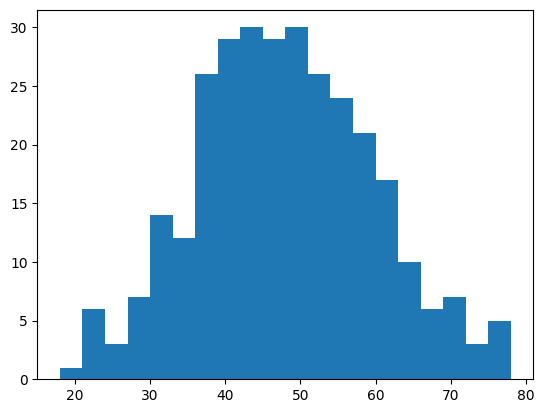

In [300]:
import pandas as pd
import matplotlib.pyplot as plt
import plotly.express as px

# Group by 'Partido' and 'Candidato' and explore counts and statistics
grouped = all_data.groupby(['Partido', 'Candidato'])

# 1. Partidos with Most Candidates
partido_candidate_count = all_data.groupby('Partido')['Candidato'].count().reset_index()
partido_candidate_count = partido_candidate_count.sort_values('Candidato', ascending=False)
fig = px.sunburst(partido_candidate_count, path=['Partido', 'Candidato'], values='Candidato')
fig.show()

# 2. Most Diverse Groups by 'Gênero', 'Idade', 'Cor'
gender_distribution = all_data.groupby(['Partido', 'Gênero'])['Candidato'].count().reset_index()
age_distribution = all_data.groupby(['Partido', 'Idade'])['Candidato'].count().reset_index()
cor_distribution = all_data.groupby(['Partido', 'Cor'])['Candidato'].count().reset_index()

# Visualize as pie/bar plots
fig = px.pie(gender_distribution, names='Partido', values='Candidato', color='Gênero')
fig.show()

# 3. Most Educated Candidates
education_distribution = all_data.groupby(['Partido', 'Grau de instrução'])['Candidato'].count().reset_index()
educated_candidates = education_distribution[education_distribution['Grau de instrução'] == 'Ensino Superior Completo']
fig = px.bar(educated_candidates, x='Partido', y='Candidato', color='Partido')
fig.show()

# 4. Candidate with the Highest Declared Assets
top_candidate_assets = all_data.loc[all_data['Total de Bens Declarados'].idxmax()]
print(f"Candidate with highest assets: {top_candidate_assets['Candidato']} from {top_candidate_assets['Partido']}")

# 5. Parties with the Most Party Funds (on average)
funding_distribution = all_data.groupby('Partido')['Fundo partidário'].mean().reset_index()
funding_distribution = funding_distribution.sort_values('Fundo partidário', ascending=False)
fig = px.bar(funding_distribution, x='Partido', y='Fundo partidário')
fig.show()

# 6. Sorted Age Values
sorted_ages = all_data['Idade'].sort_values()
plt.hist(sorted_ages, bins=20)
plt.show()
